# Sensor Fault Detection:

## 1. Problem Statement:
Data: Sensor Data
Problem statement :


The system in focus is the thumb impression system, which records lots of details of employee when logging in through the system. The datasets positive class corresponds to component failures for a specific component of the thumb impression system. The negative class corresponds to failure in attendance device for components not related to the thumb impression system.

The problem is to reduce the cost due to unnecessary repairs. So it is required to minimize the false predictions.

|True class | Positive | Negative | |
| ----------- | ----------- |   |  |
|<b>Predicted class</b>||| |
| Positive      |   -       | cost_1  |    |
| Negative   | cost_2        |  | |


Cost 1 = 10 and Cost 2 = 100

1. type 1 failure--> Failure of device was not due to thumb impression system but repair was done (false positive)
2. type 2 failure--> Failure of device was due to thumb impression system but missed the fault (false negative)

- The total cost of a prediction model the sum of `Cost_1` multiplied by the number of Instances with type 1 failure and `Cost_2` with the number of instances with type 2 failure, resulting in a `Total_cost`. In this case `Cost_1` refers to the cost that an unnessecary check needs to be done by an mechanic at an workshop, while `Cost_2` refer to the cost of missing a faulty device, which may cause a breakdown. 
- `Total_cost = Cost_1 * No_Instances + Cost_2 * No_Instances.`

- From the above problem statement we could observe that, we have to reduce false positives and false negatives. More importantly we have to **reduce false negatives, since cost incurred due to false negative is 50 times higher than the false positives.**

# Challenges and other objectives
- Need to Handle many Null values in almost all columns.
- misclassification leads the unecessary repair costs.
- misclassification leads to sudden breakdown of device.

## Basic library Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from statistics import mean
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# pre-processing:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.model_selection import  train_test_split, RepeatedStratifiedKFold, cross_val_score

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#imputers:
from sklearn.impute import SimpleImputer, KNNImputer

#imbalanced-dataset:
from imblearn.combine import SMOTETomek

#Classification-models:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


#dimensional-reduction:
from sklearn.utils import resample


#Classifiction-metrics:
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix


In [2]:
# Read Data ( as huge dataset so a subset is read for fast execution, ideally full data should be read)
df=pd.read_csv('aps_failure_dataset.csv',na_values='na')

In [3]:
df_copy=df.iloc[:5000,:]

In [4]:
df_copy.shape

(5000, 171)

In [5]:
df.columns.values

array(['class', 'aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000',
       'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004',
       'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000',
       'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000',
       'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000',
       'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003',
       'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009',
       'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005',
       'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001',
       'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007',
       'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000',
       'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000',
       'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000',
       'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000',
       'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000'

class
neg    4480
pos     520
Name: count, dtype: int64


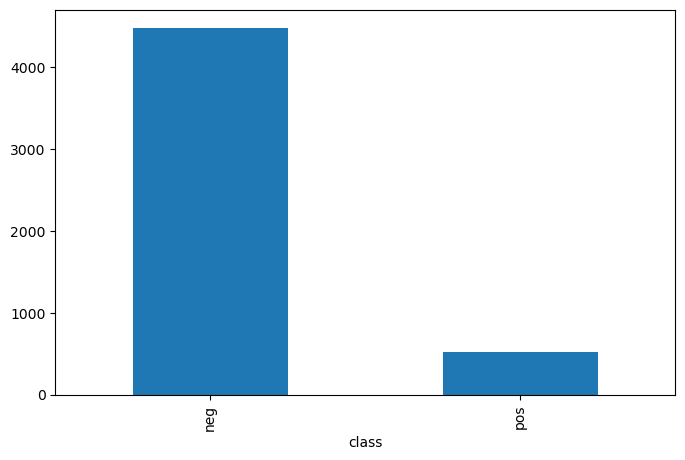

In [6]:
# Target Variable Unique counts:
print(df_copy['class'].value_counts())
plt.figure(figsize=(8,5))
df_copy['class'].value_counts().plot(kind='bar')
plt.show()
# Imbalanced dataset needs to be handled

**Report**
- The target classes are highly imbalanced
- Class imbalance is a scenario that arises when we have unequal distribution of class in a dataset i.e. the no. of data points in the negative class (majority class) very large compared to that of the positive class (minority class)
- If the imbalanced data is not treated beforehand, then this will degrade the performance of the classifier model. 
- Hence we should handle imbalanced data with certain methods.

**How to handle Imbalance Data ?**

- Resampling data is one of the most commonly preferred approaches to deal with an imbalanced dataset. There are broadly two types of methods for this i) Undersampling ii) Oversampling. In most cases, oversampling is preferred over undersampling techniques. The reason being, in undersampling we tend to remove instances from data that may be carrying some important information.
- **SMOTE:** Synthetic Minority Oversampling Technique
- SMOTE is an oversampling technique where the synthetic samples are generated for the minority class.
- Hybridization techniques involve combining both undersampling and oversampling techniques. This is done to optimize the performance of classifier models for the samples created as part of these techniques --> **SMOTOMEK**
- It only duplicates the data and it won't add and new information. Hence we look at some different techniques.

In [7]:
# define numerical & categorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 170 numerical features : ['aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'ci_000', 'cj_000', 'ck_000'

### As this is sensor data, so detailed interpretation won't be required

In [8]:
# Distribution of Numerical Features:

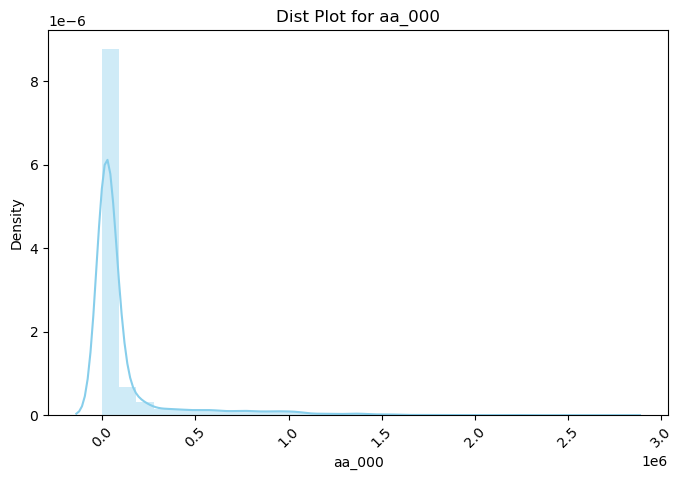

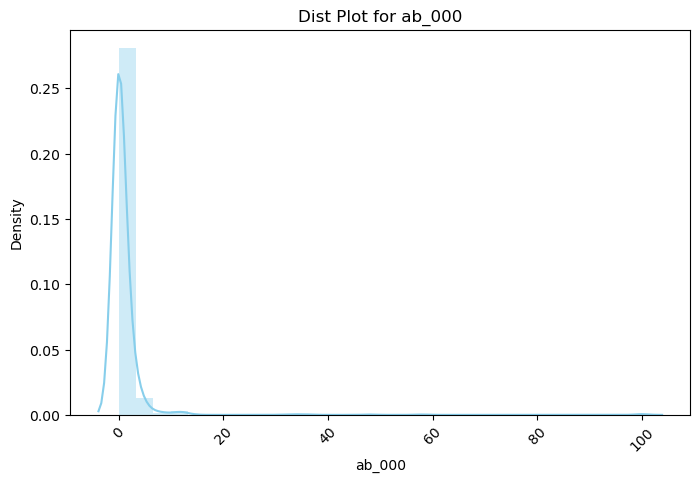

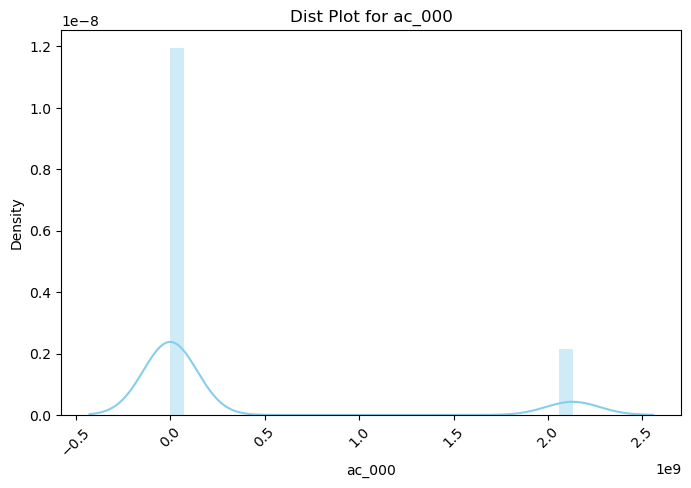

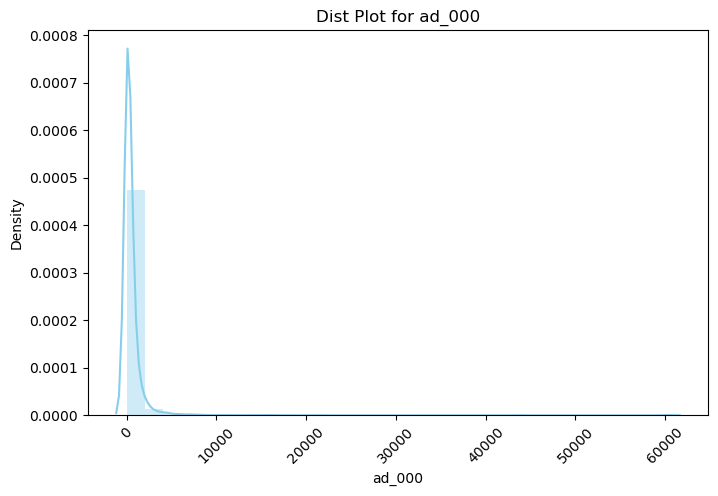

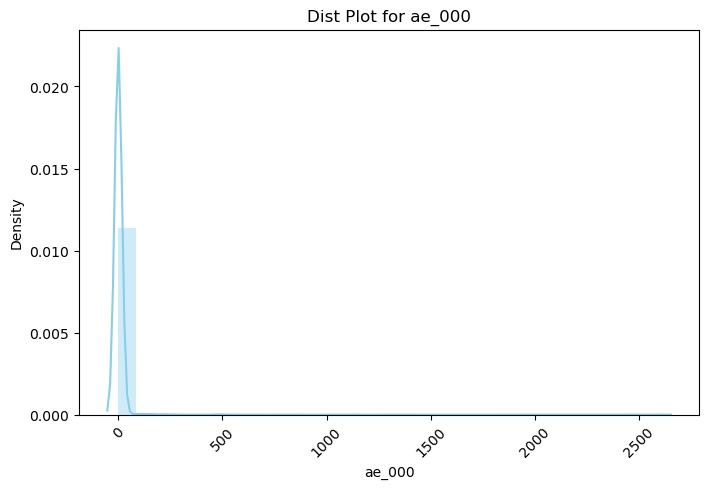

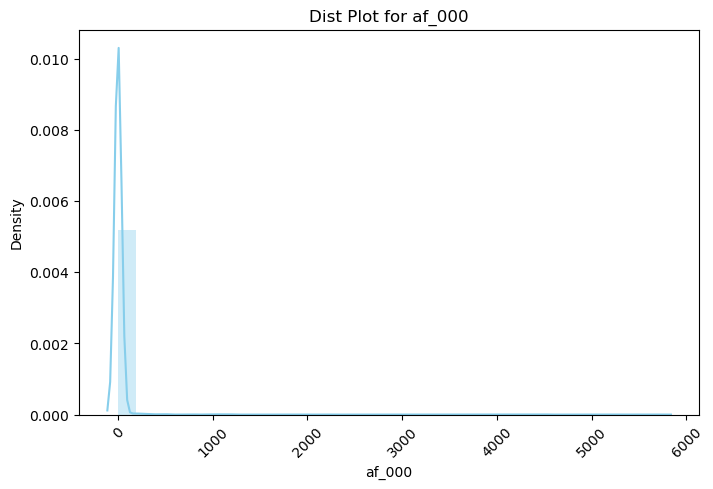

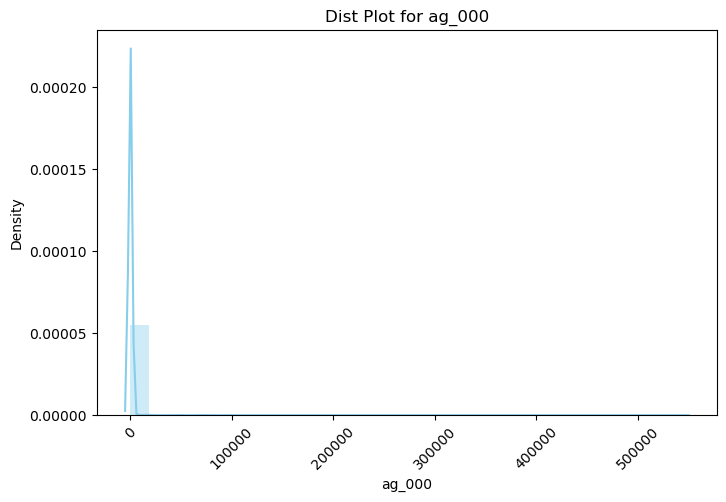

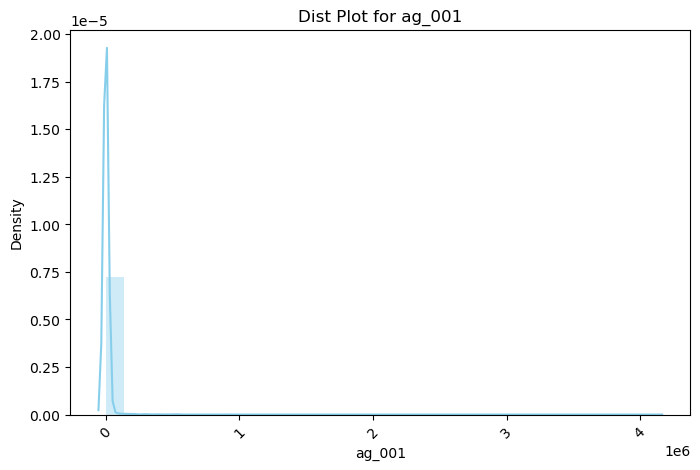

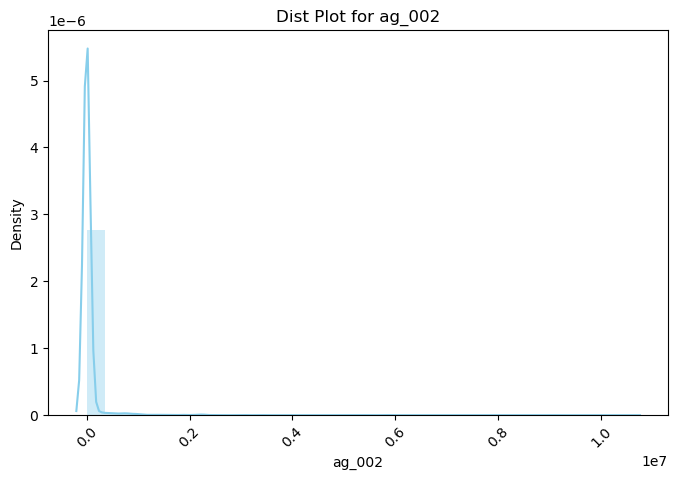

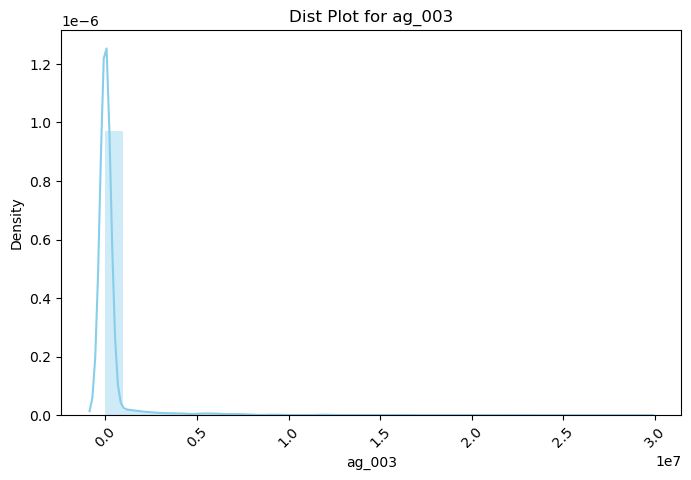

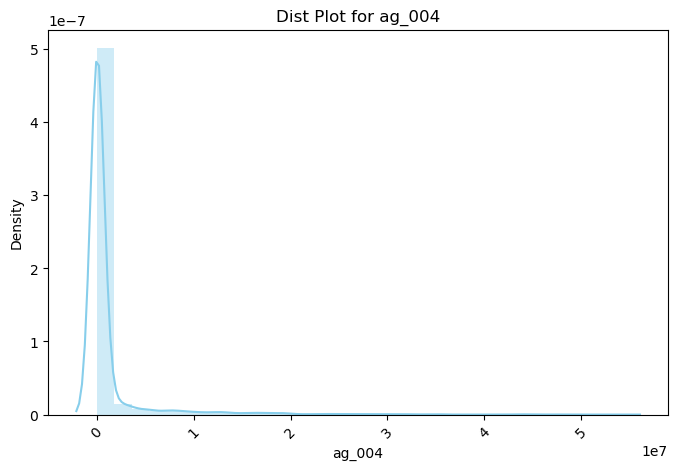

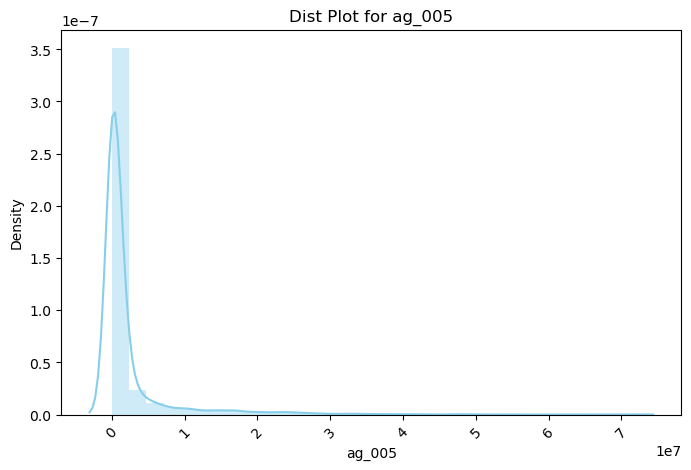

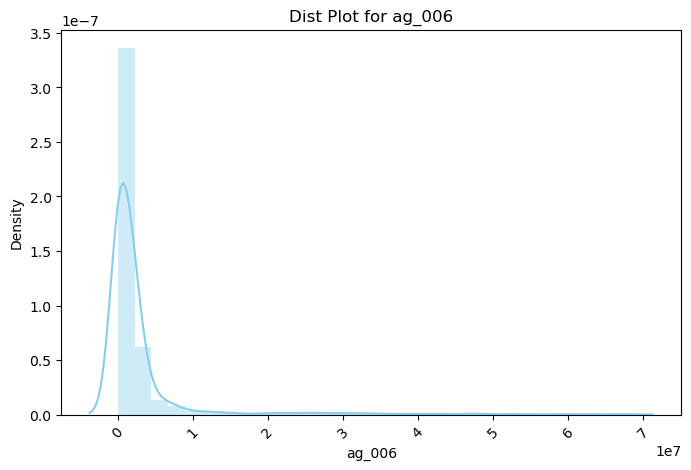

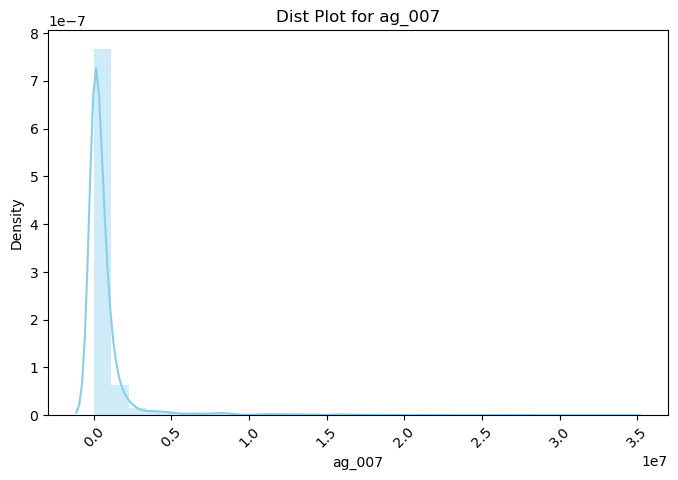

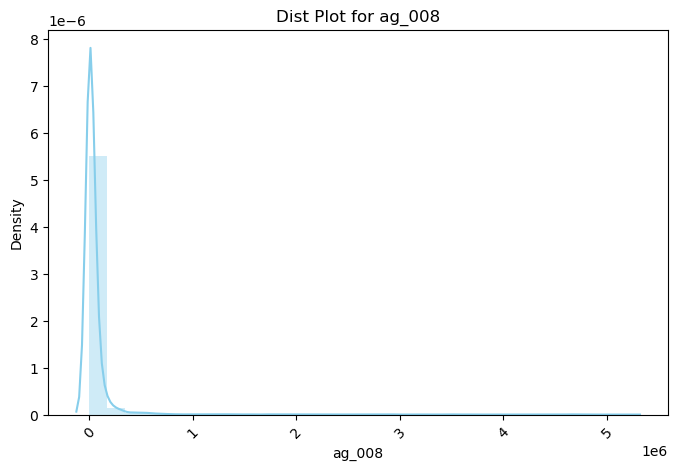

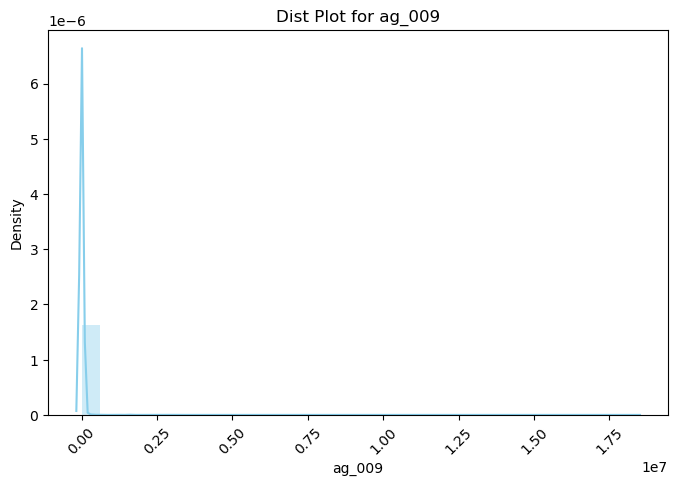

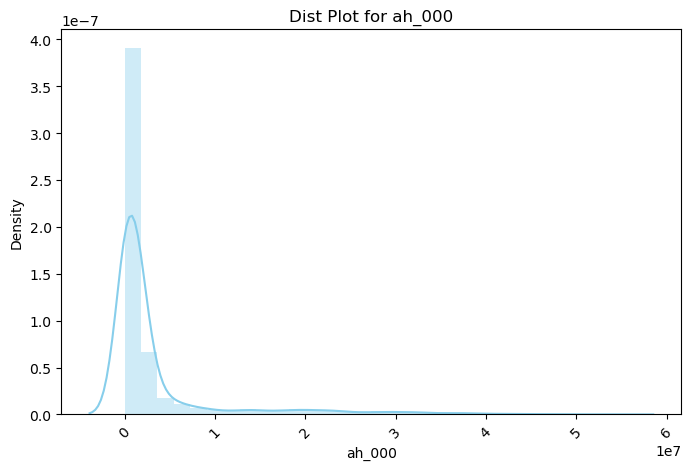

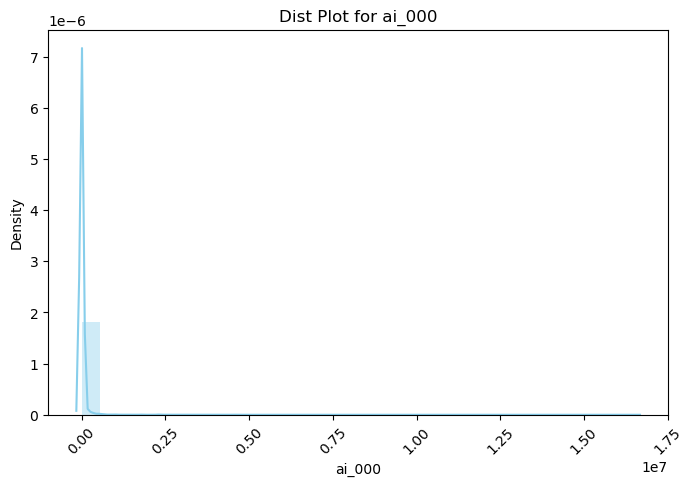

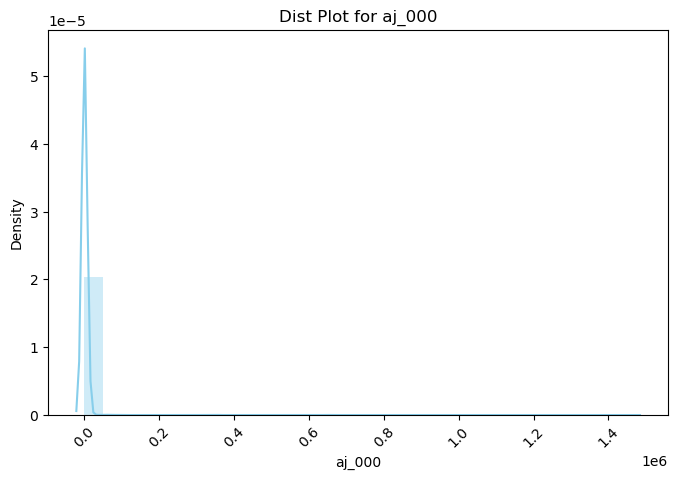

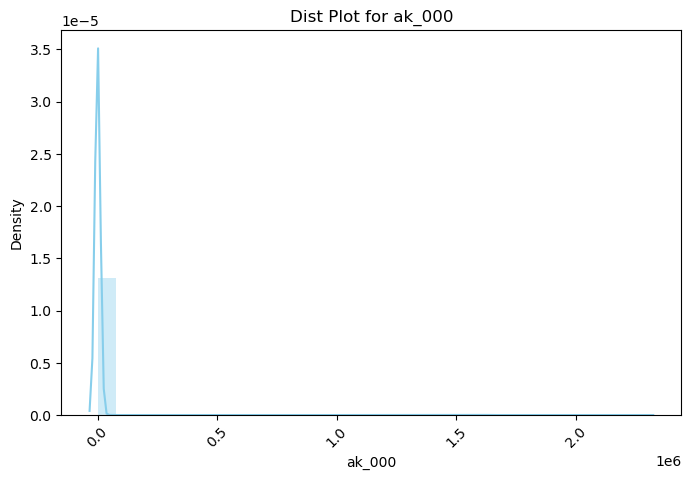

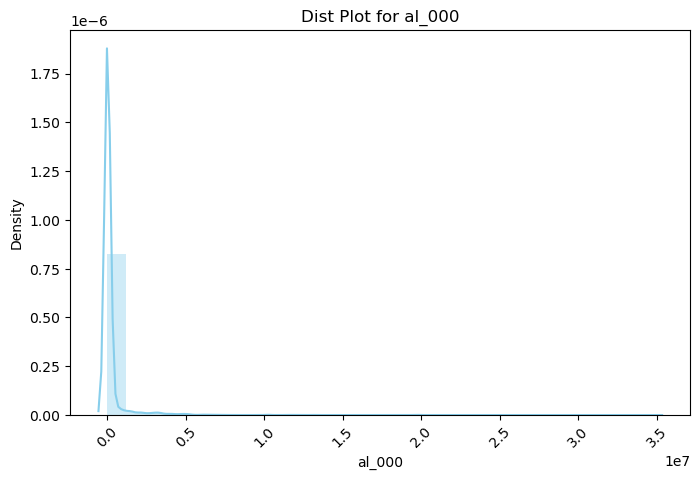

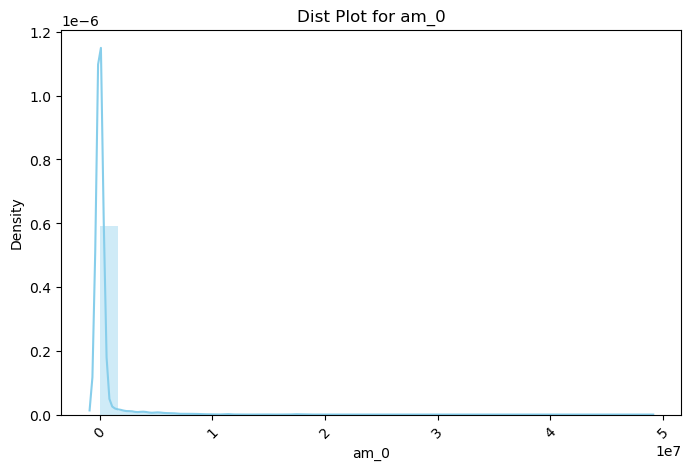

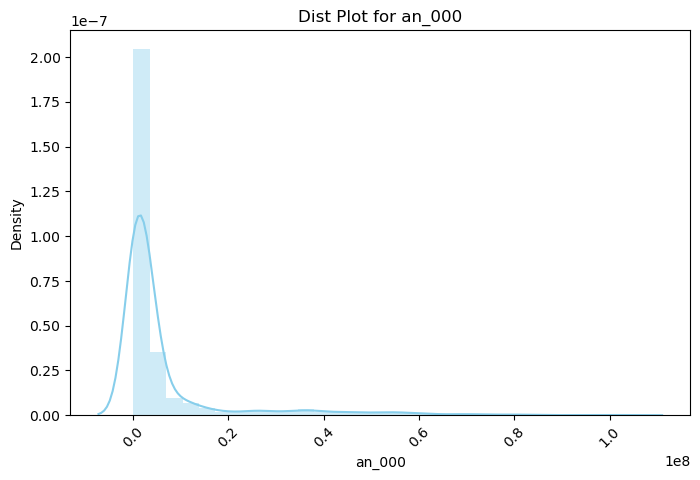

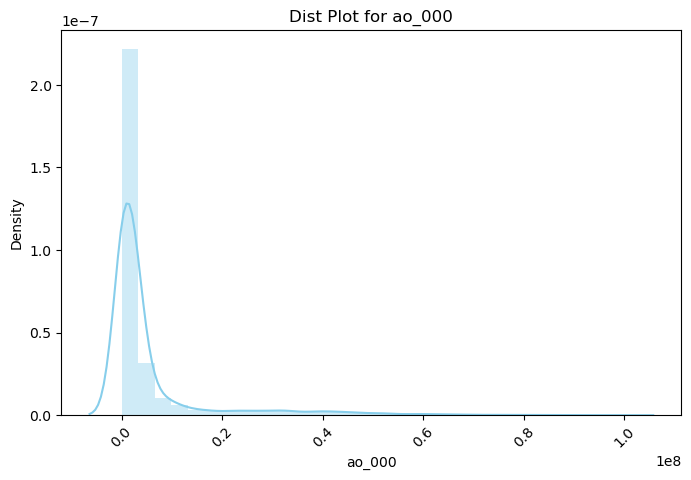

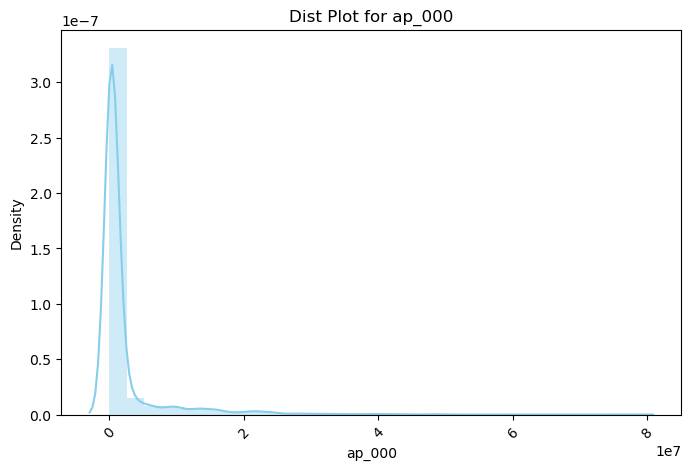

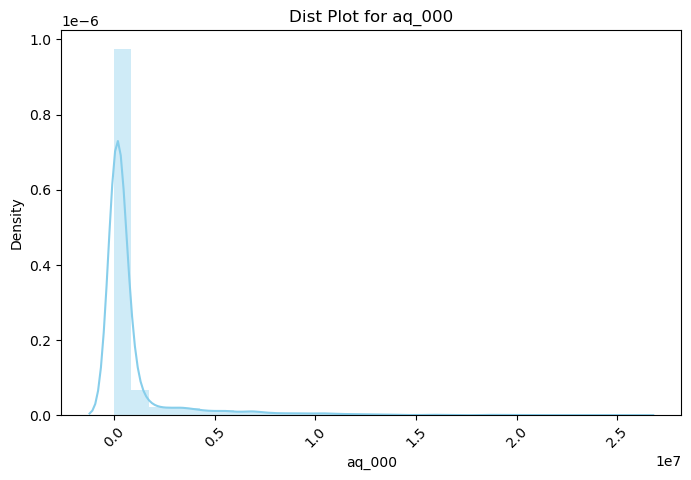

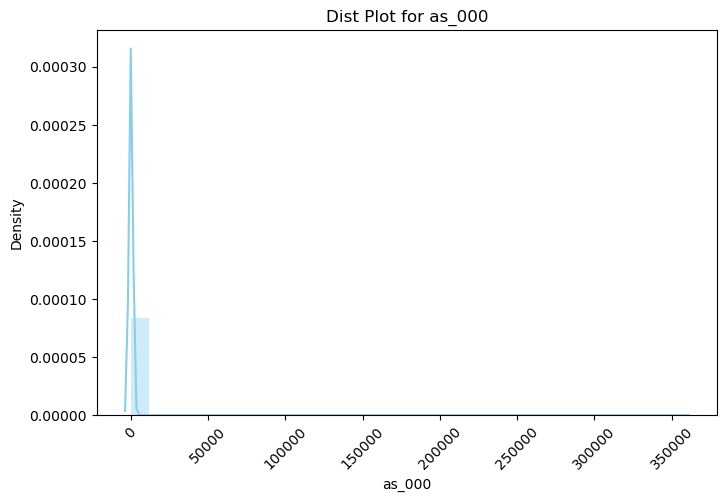

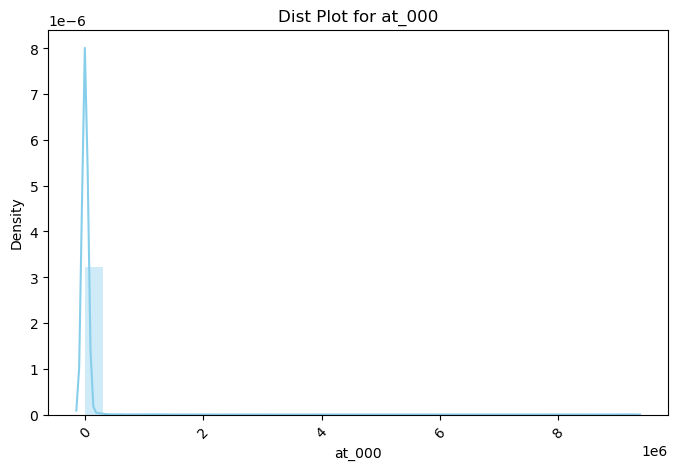

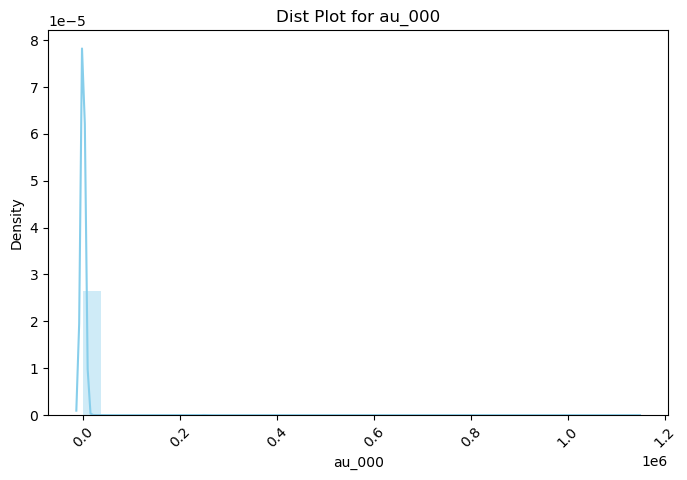

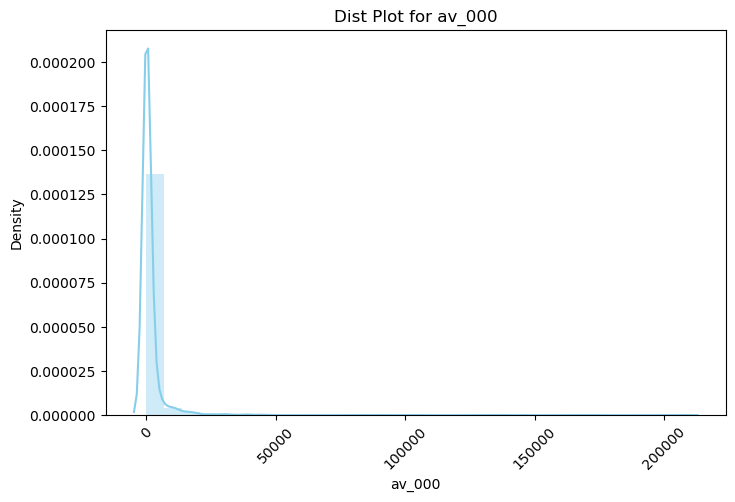

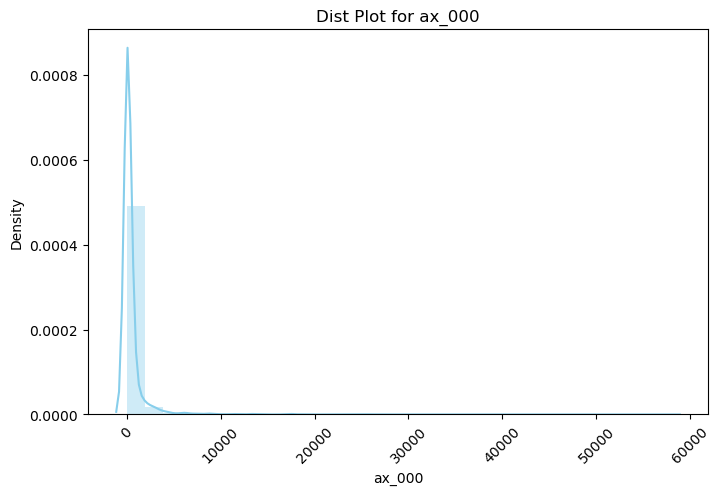

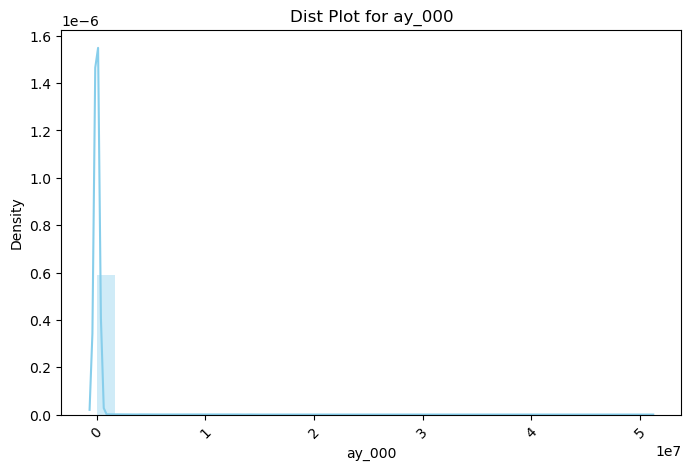

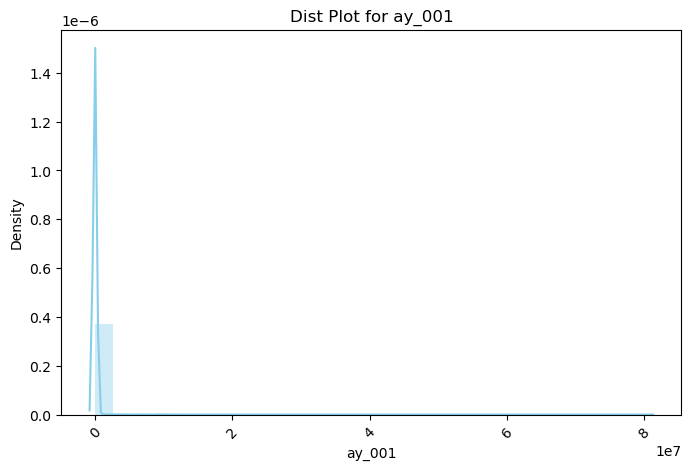

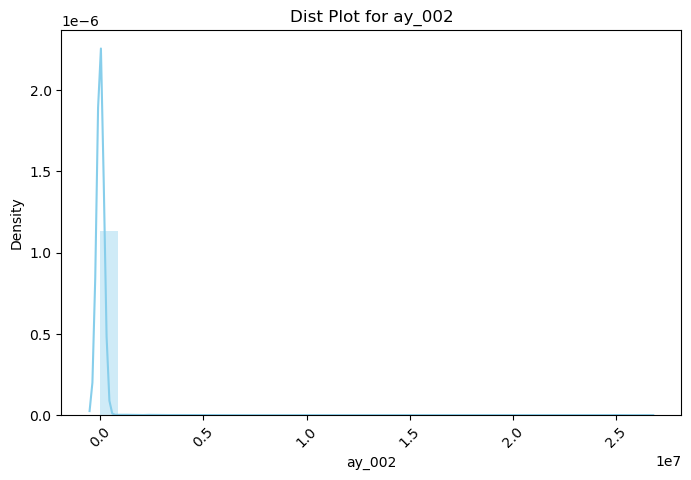

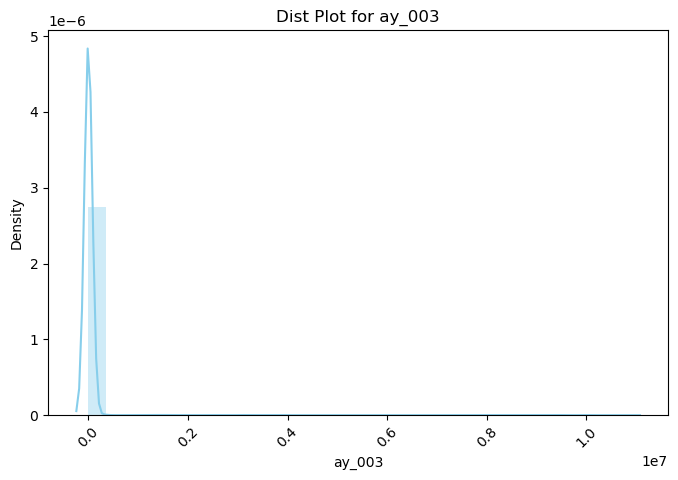

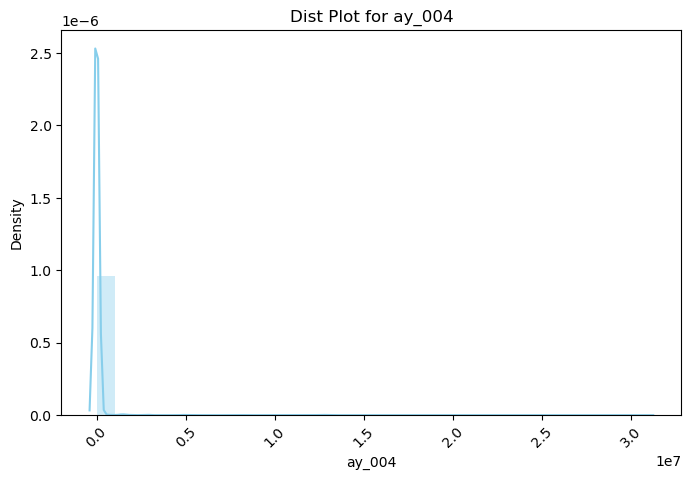

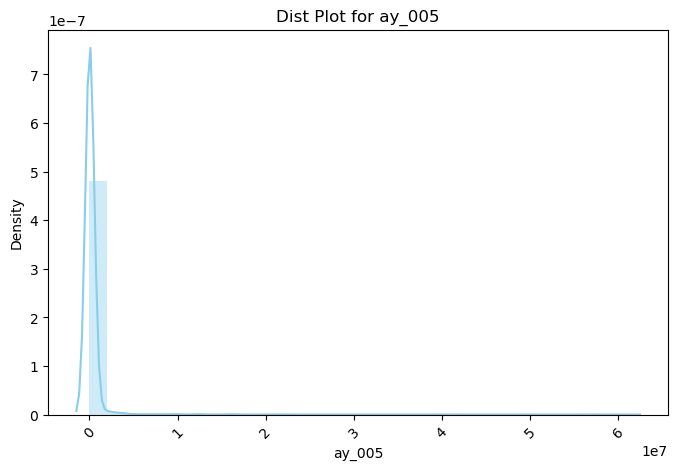

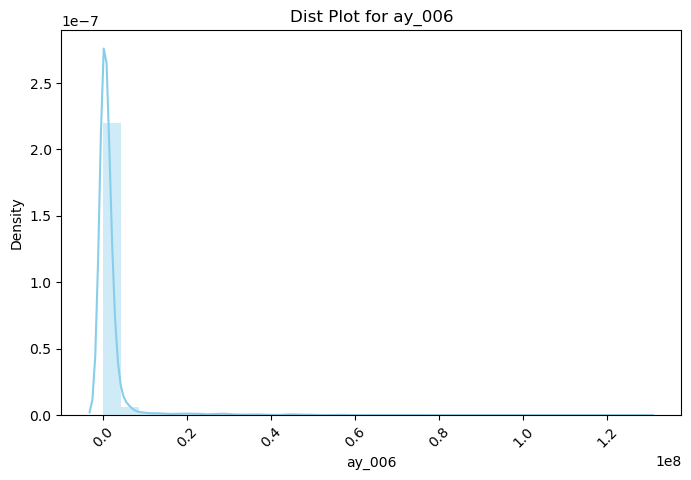

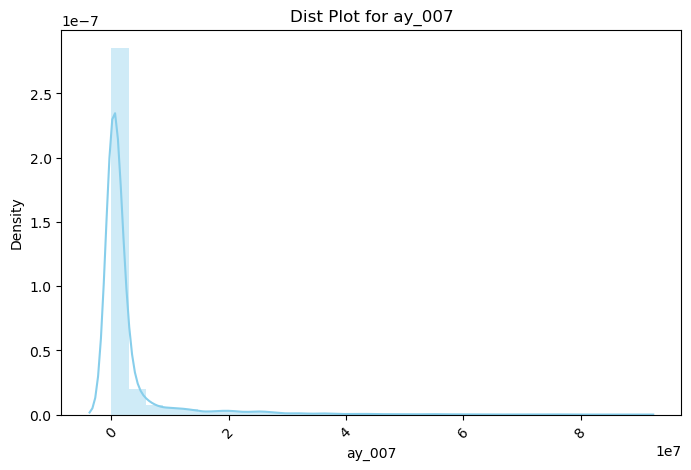

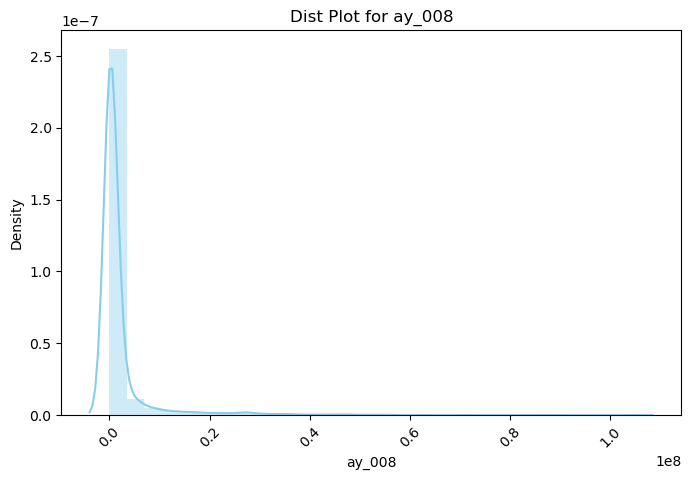

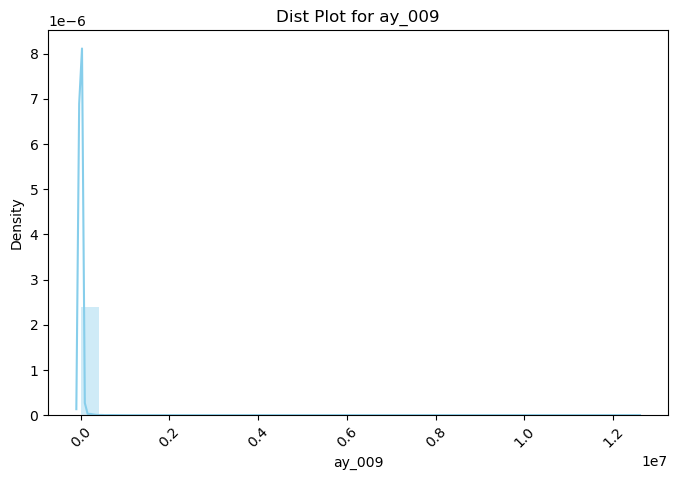

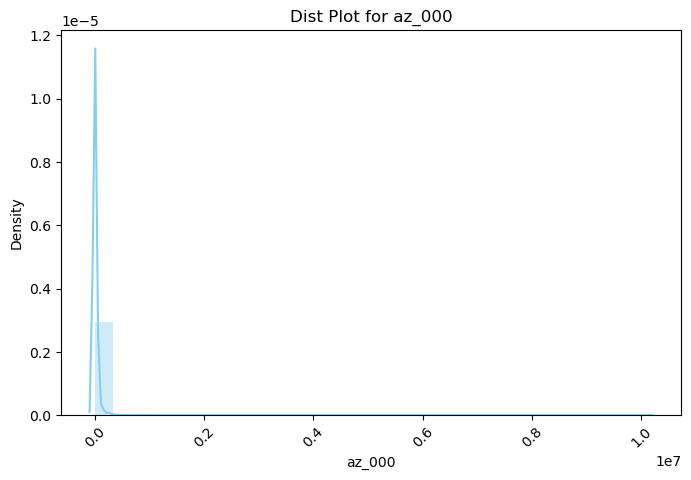

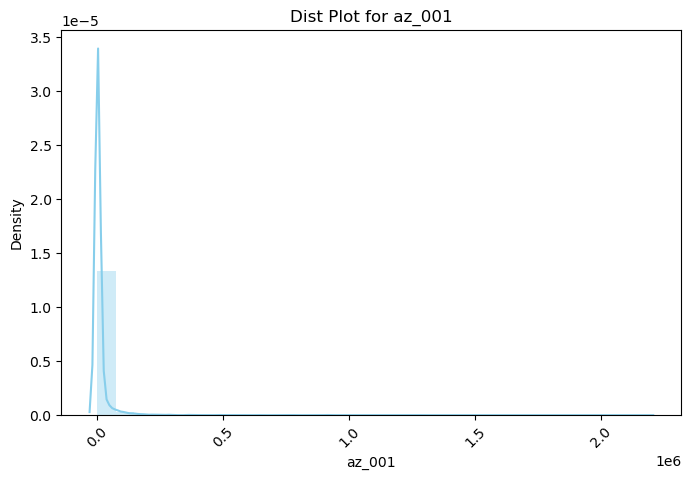

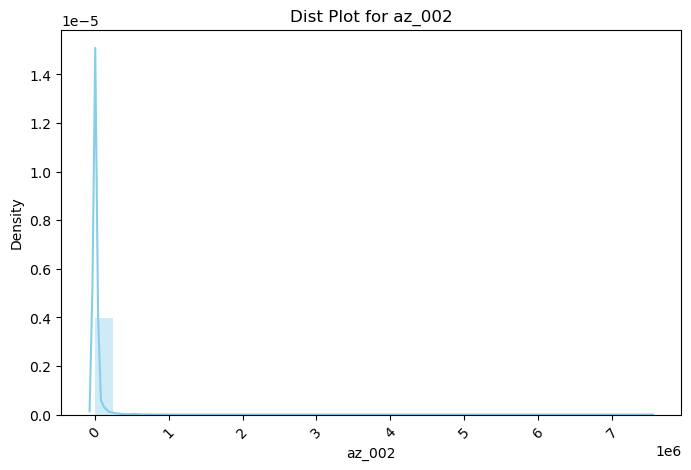

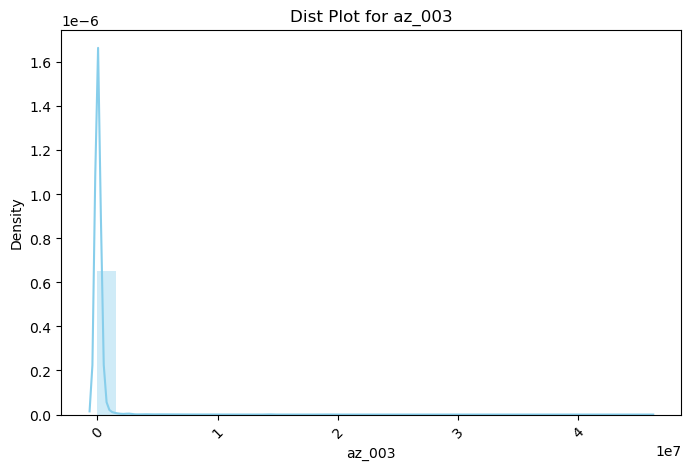

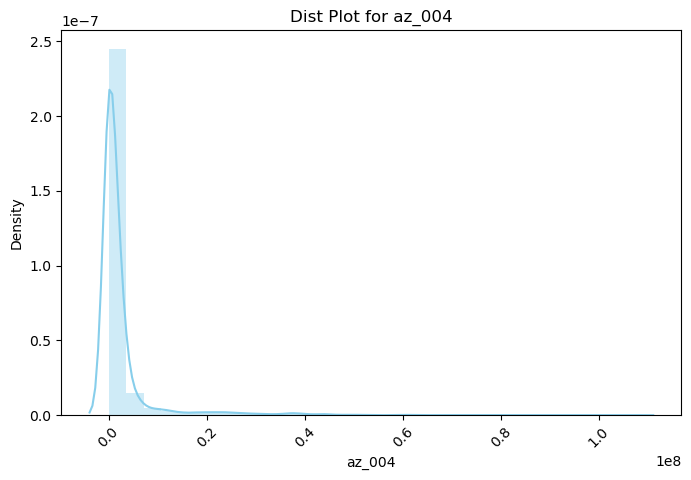

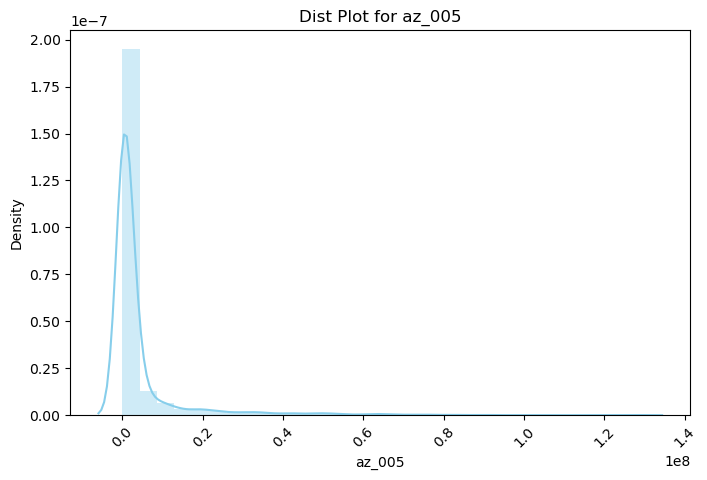

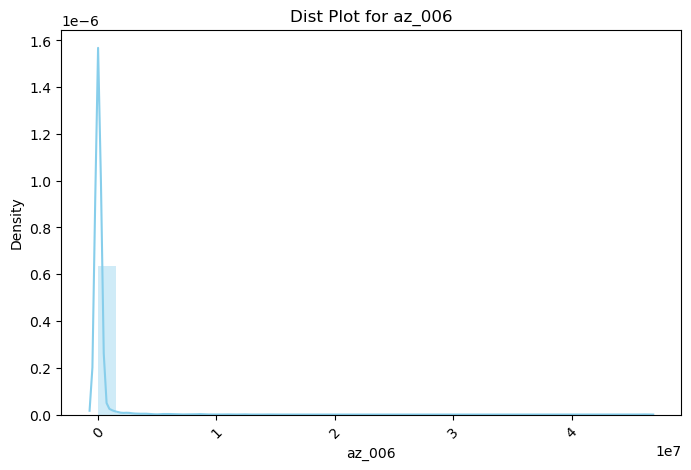

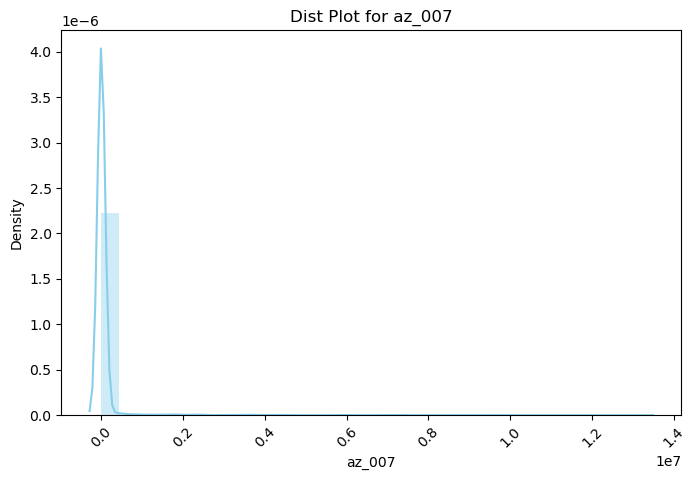

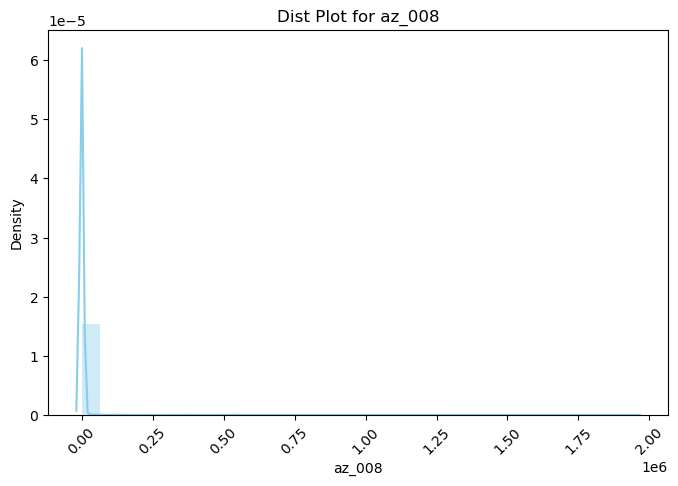

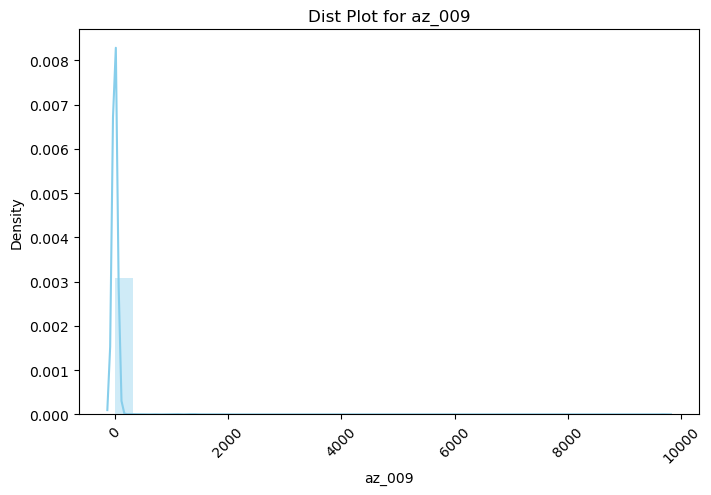

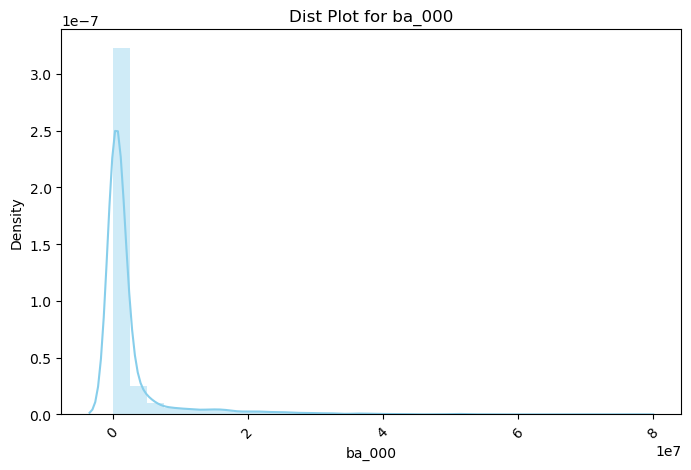

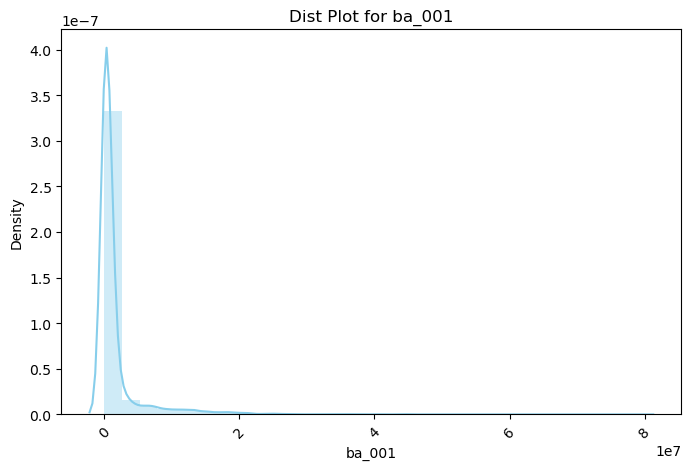

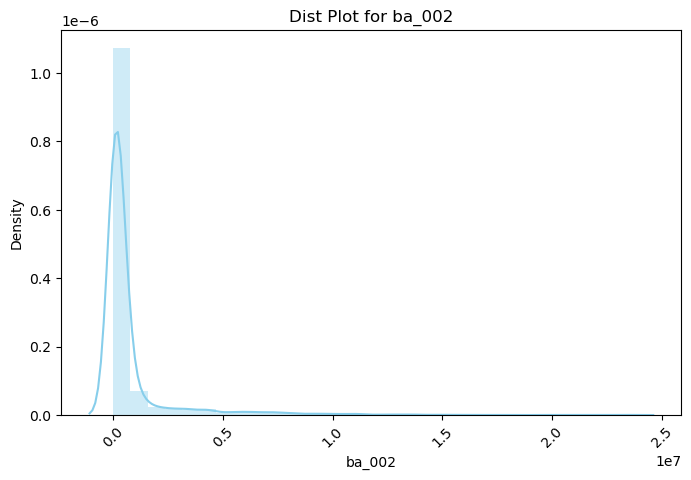

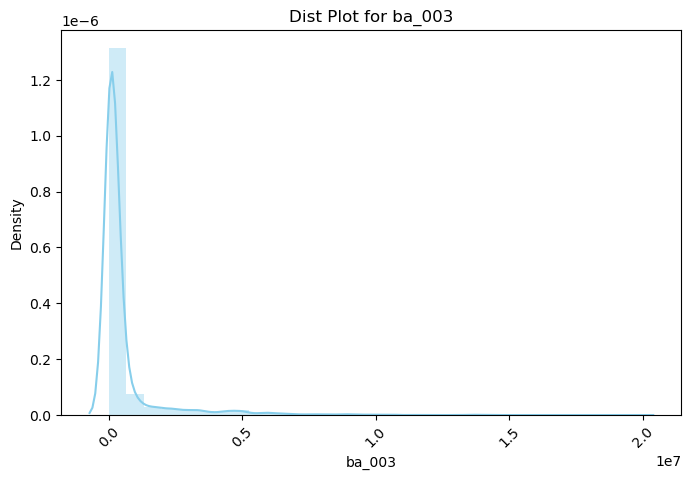

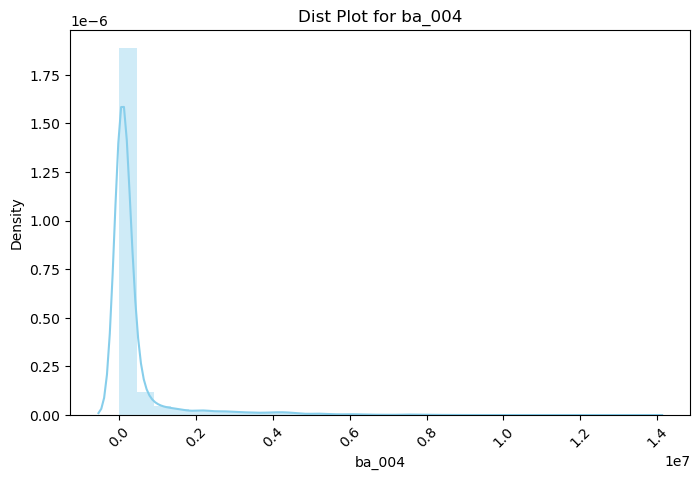

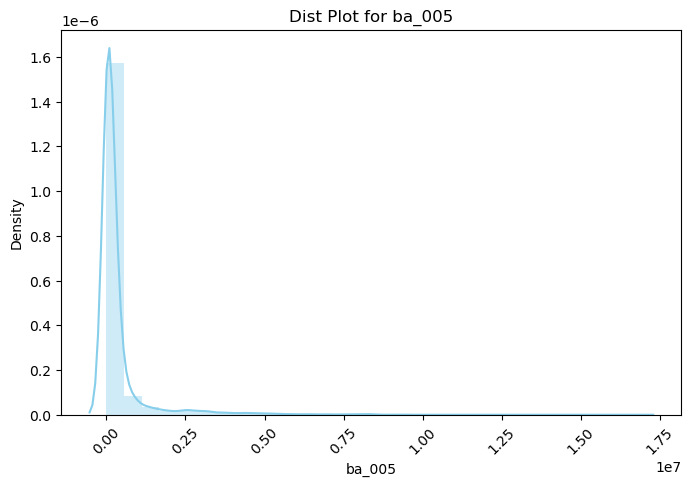

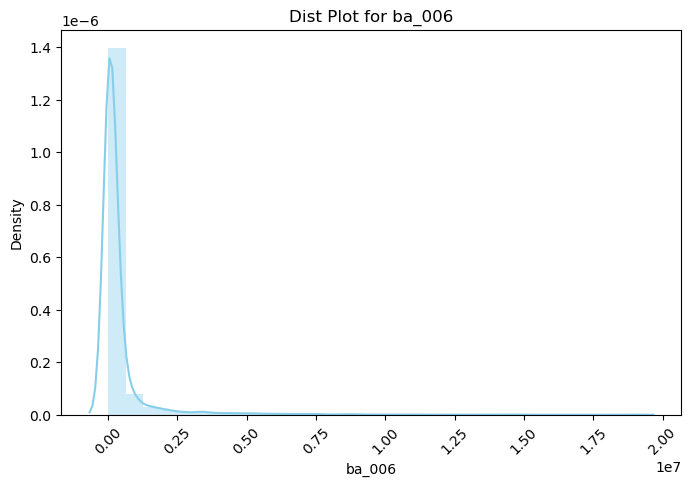

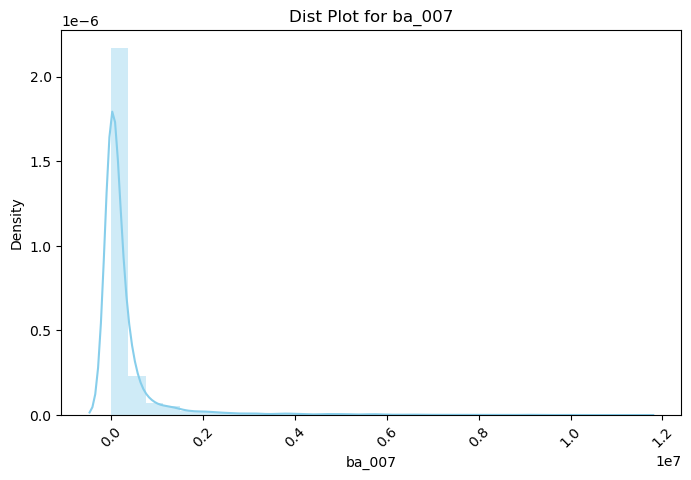

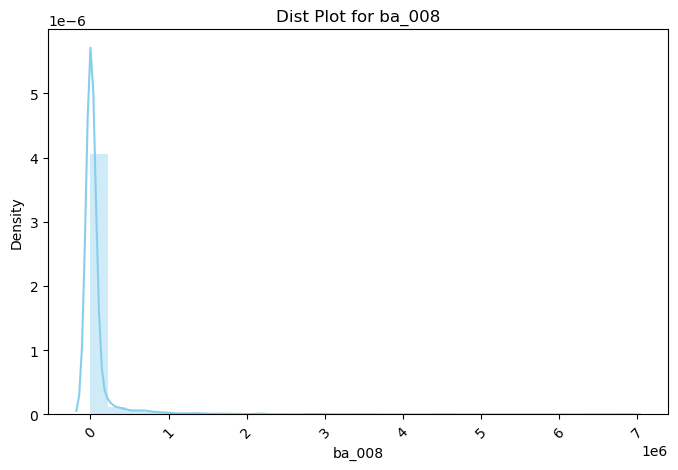

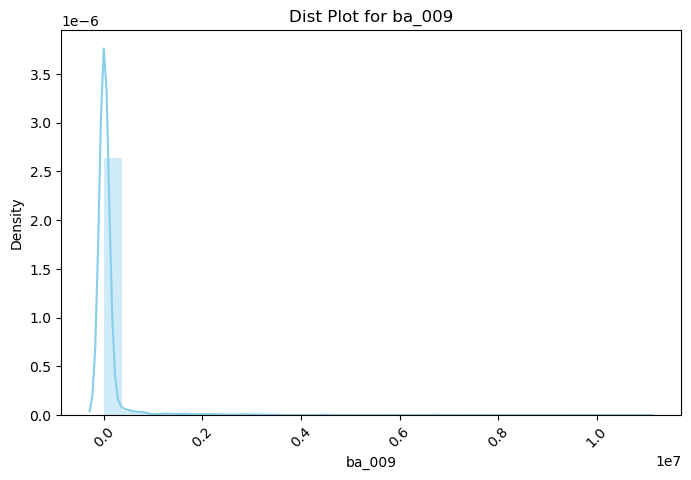

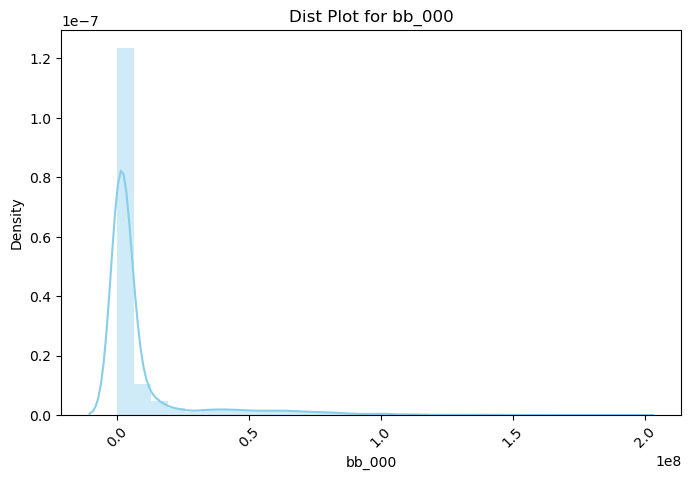

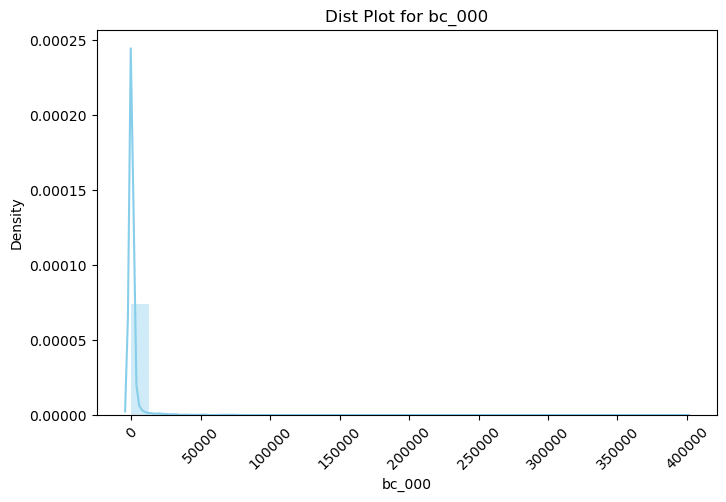

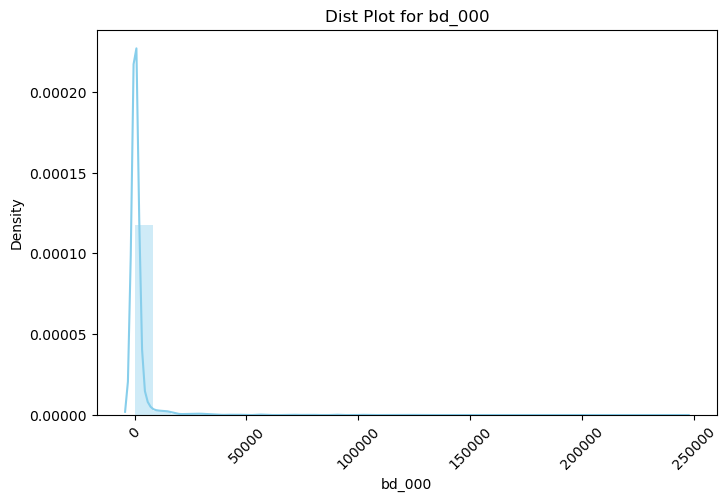

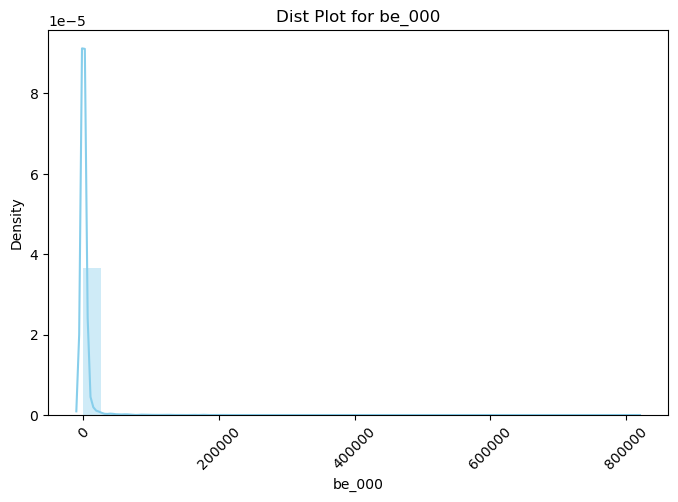

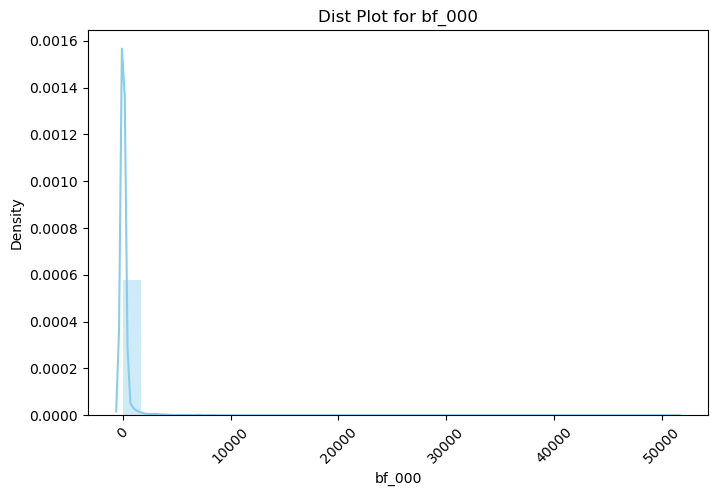

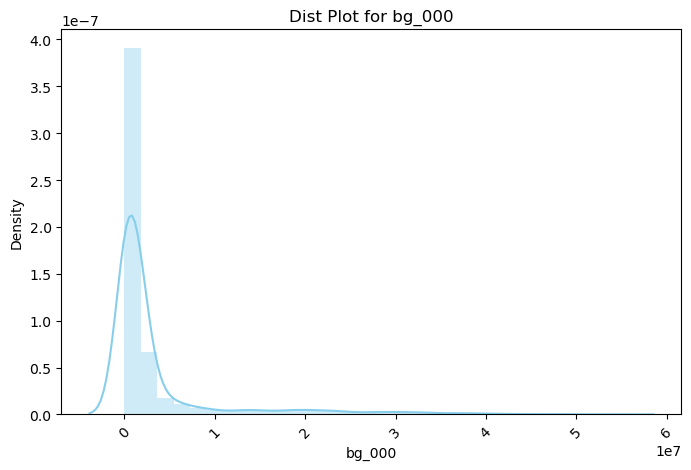

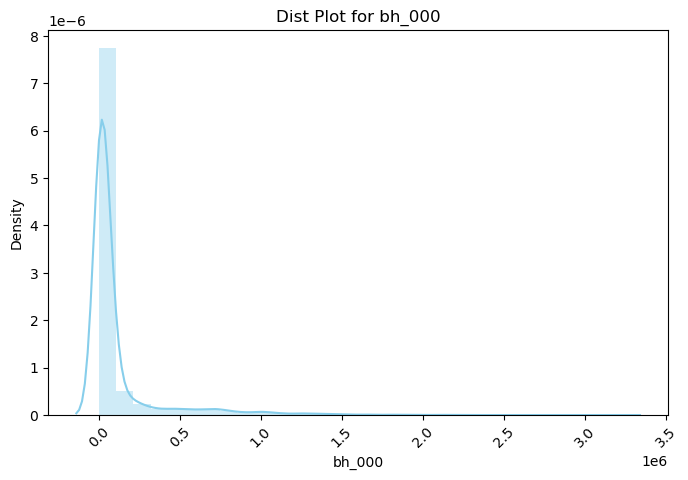

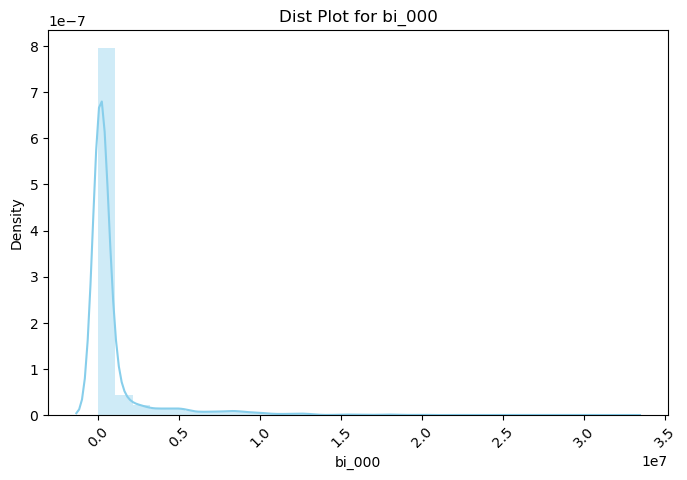

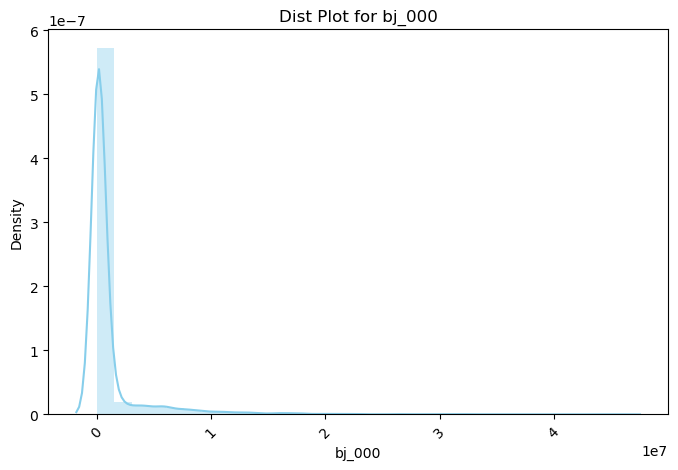

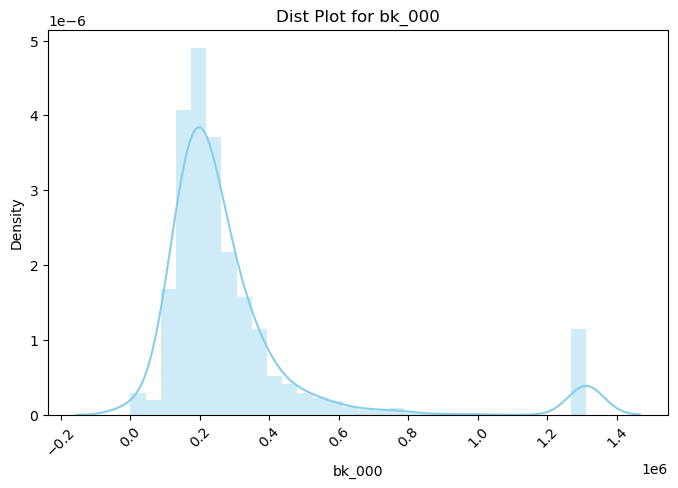

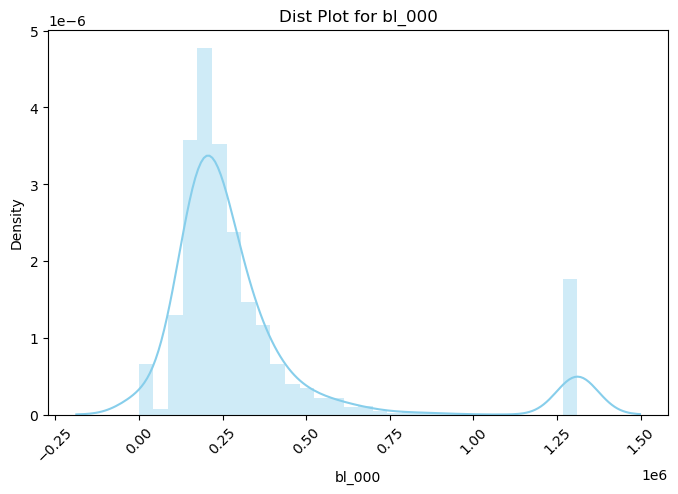

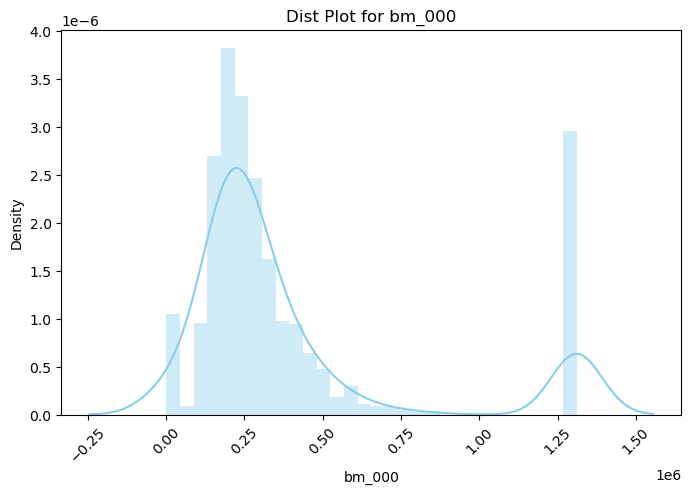

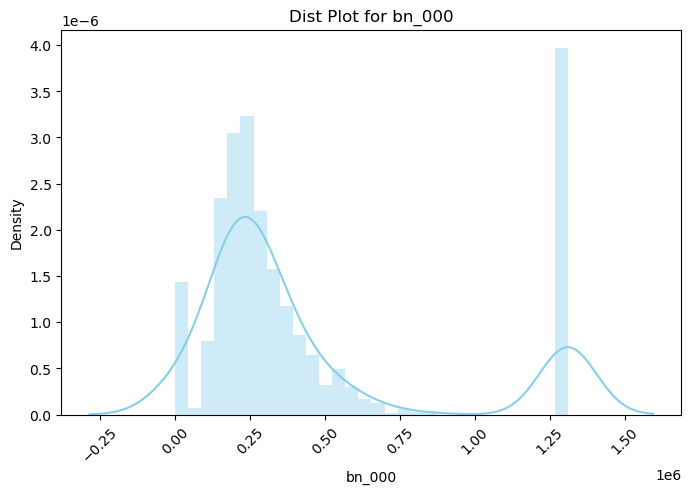

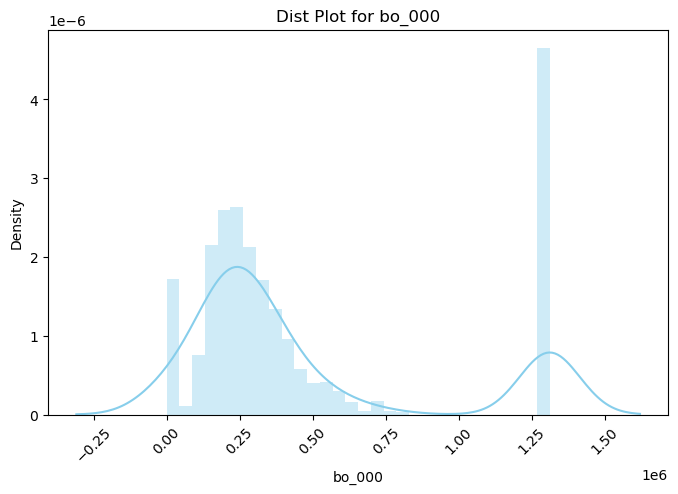

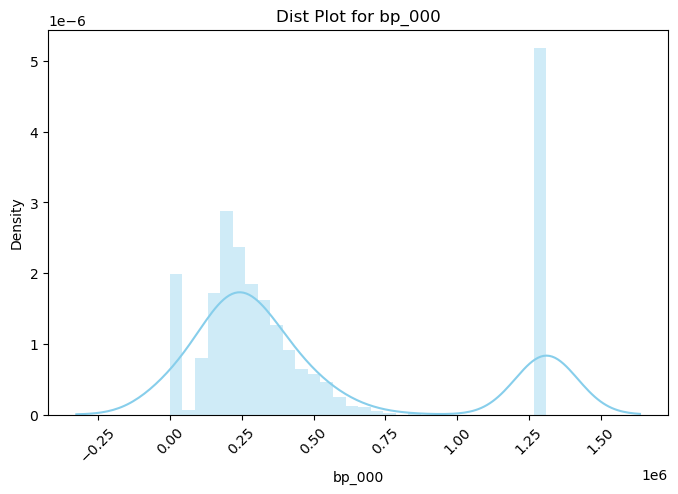

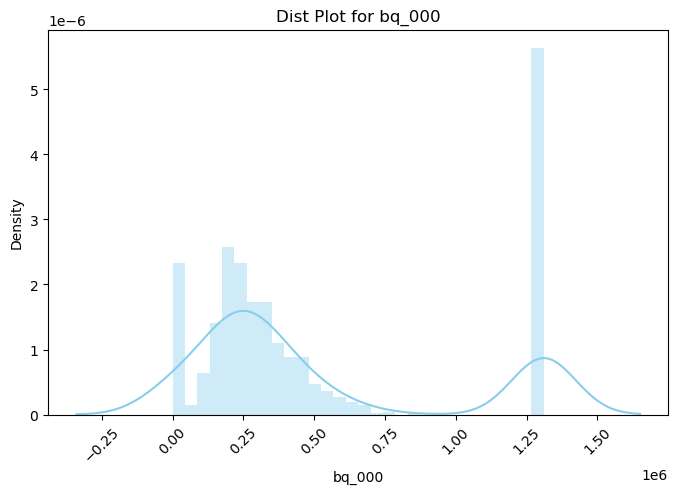

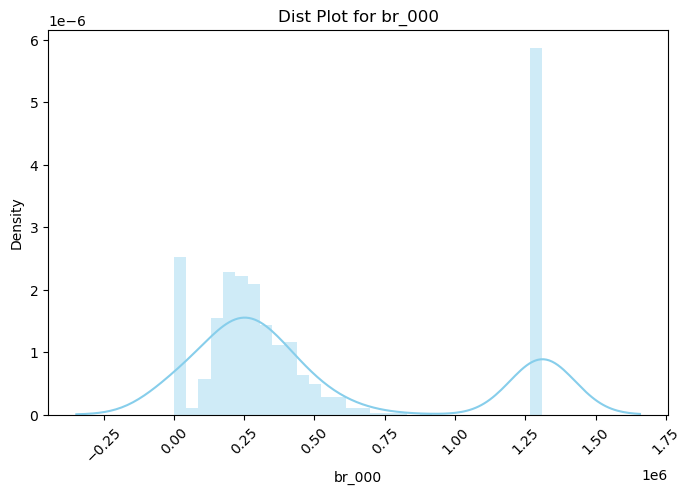

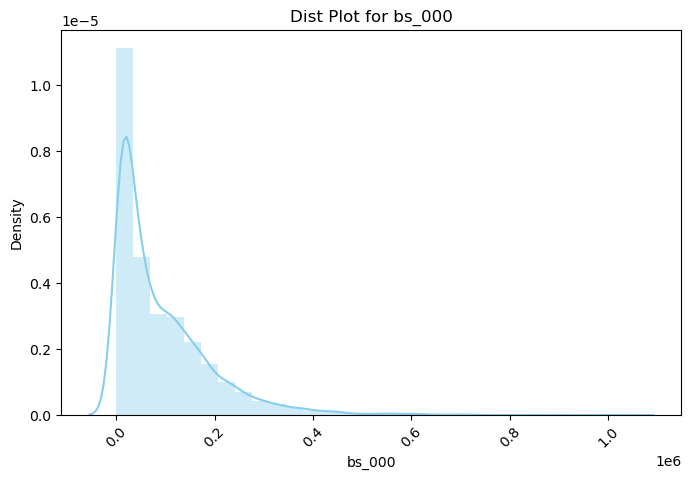

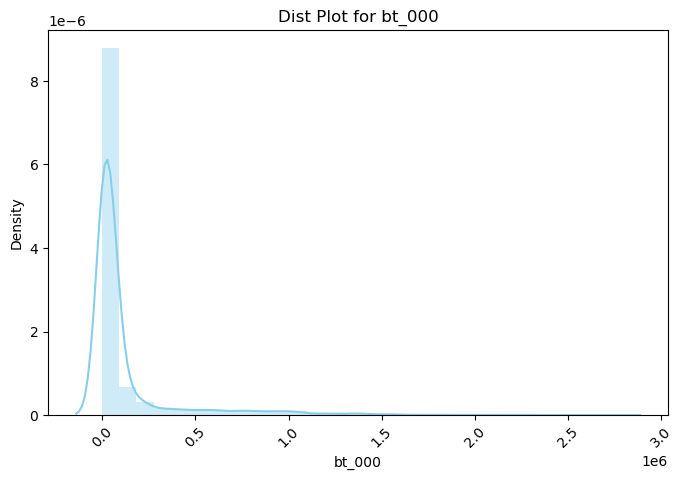

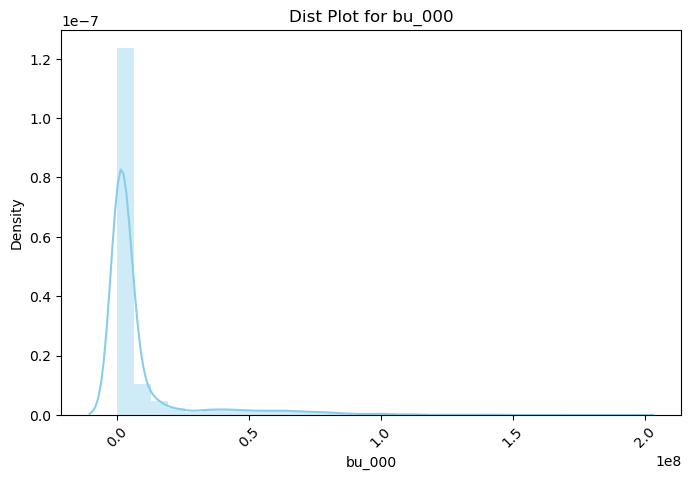

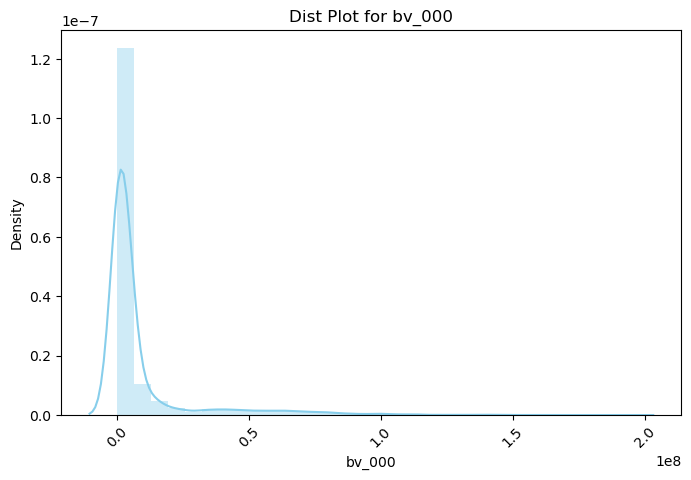

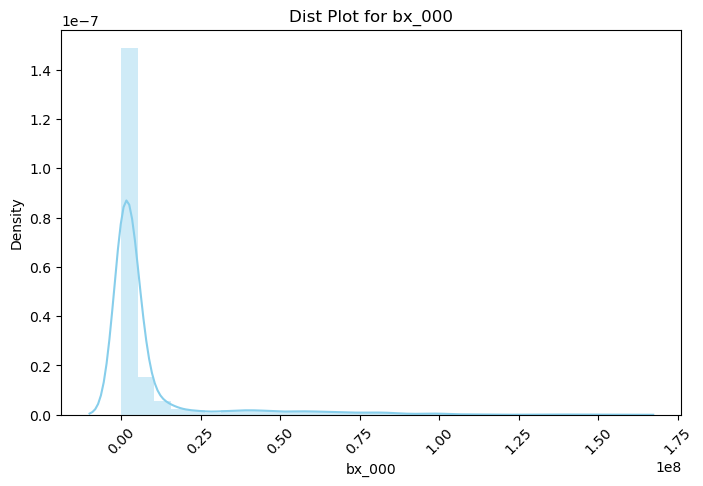

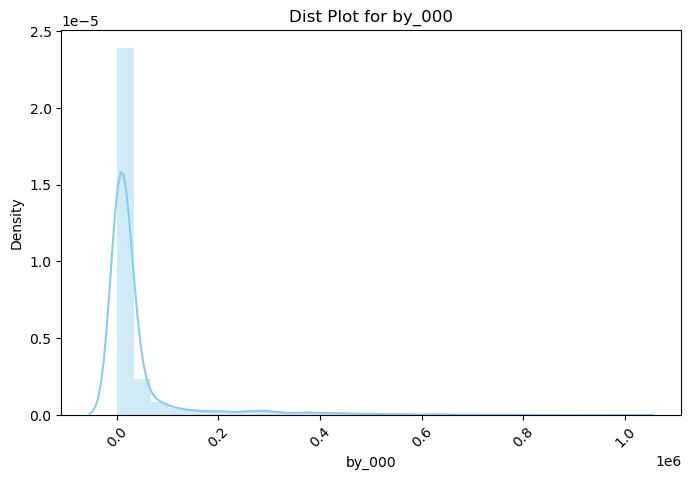

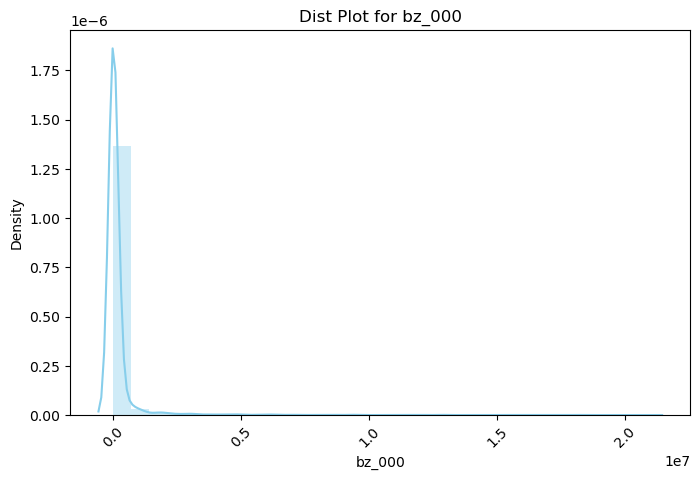

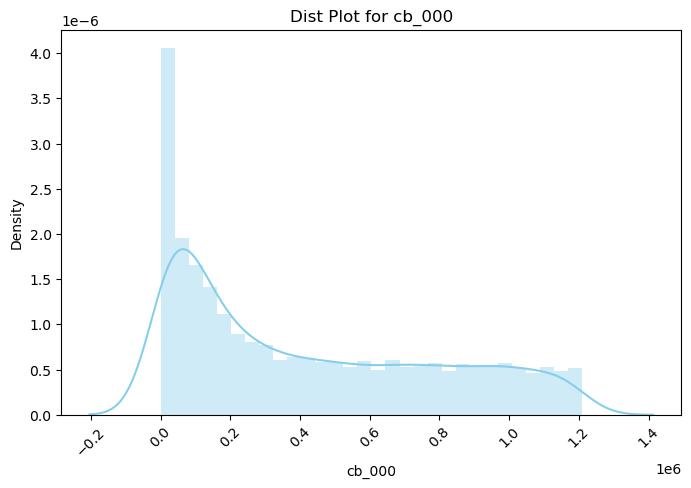

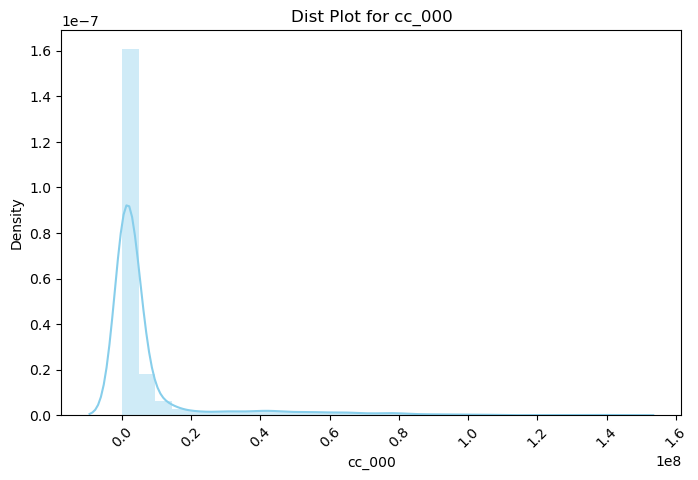

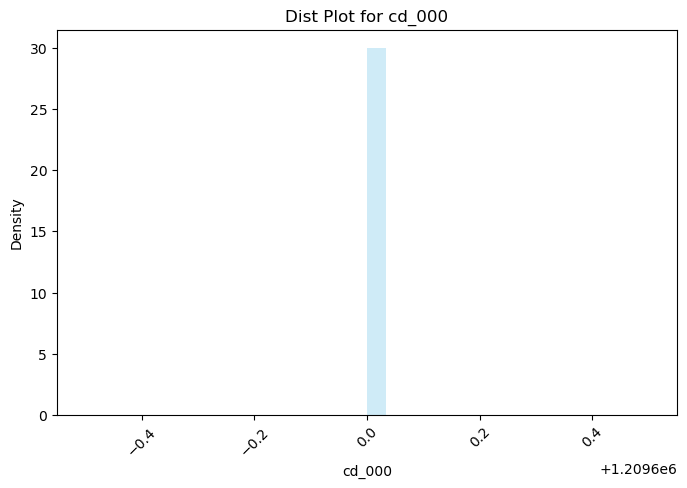

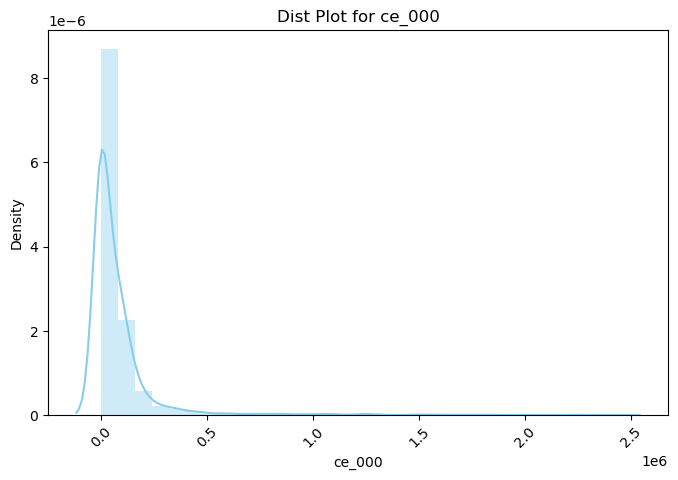

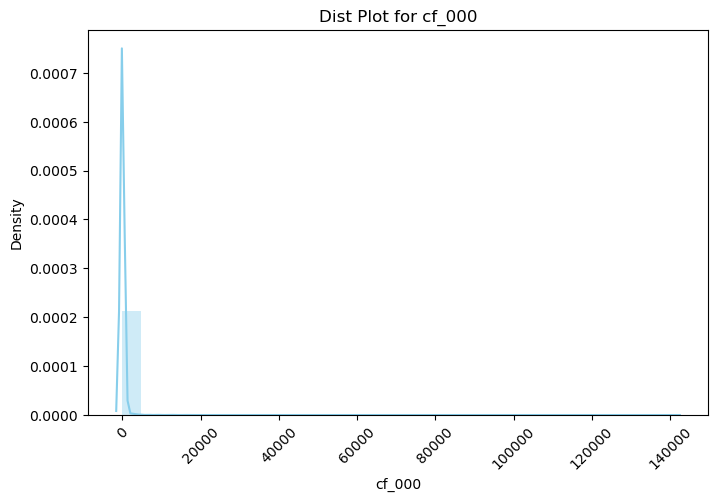

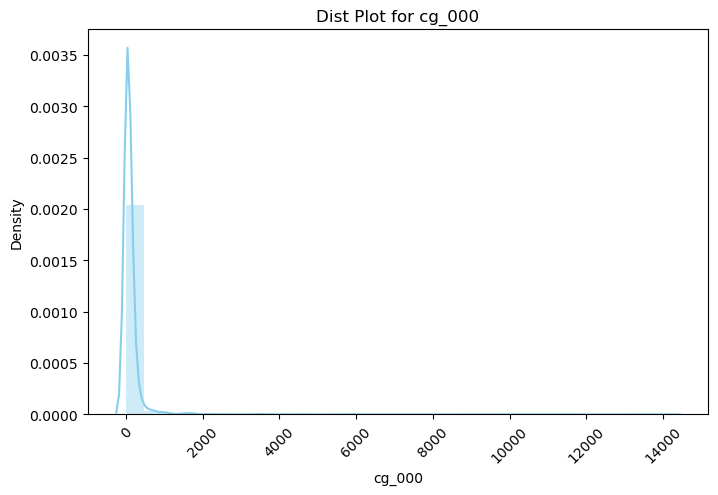

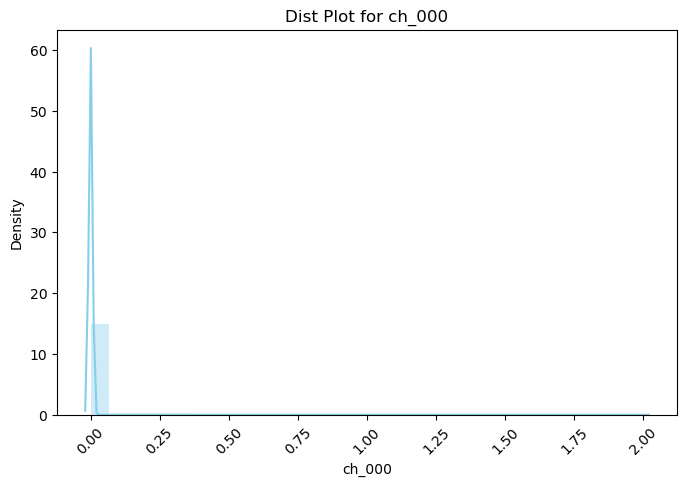

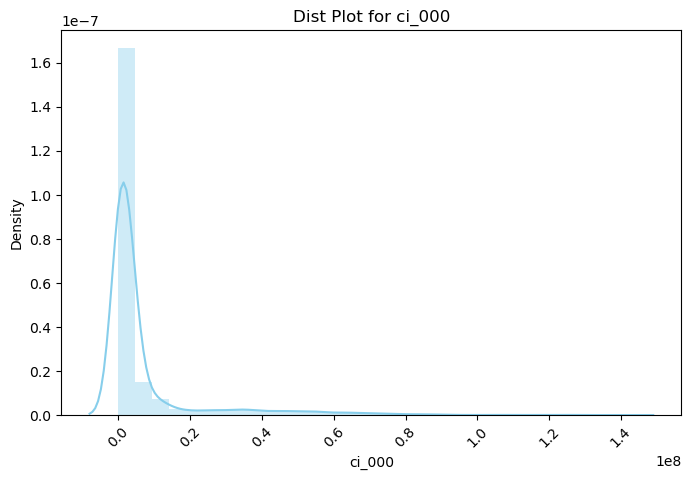

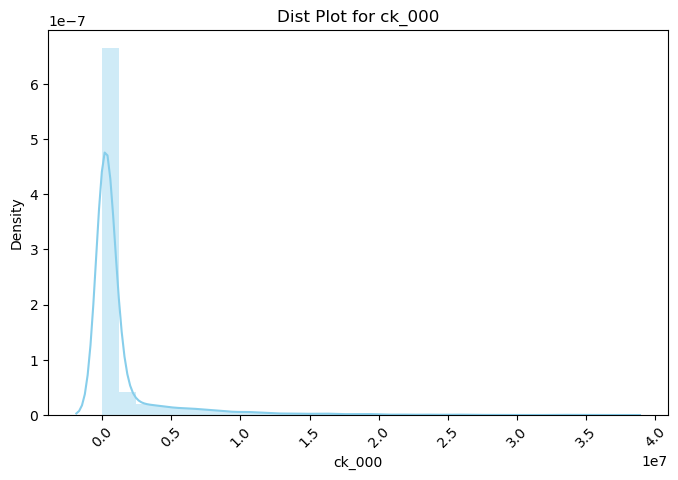

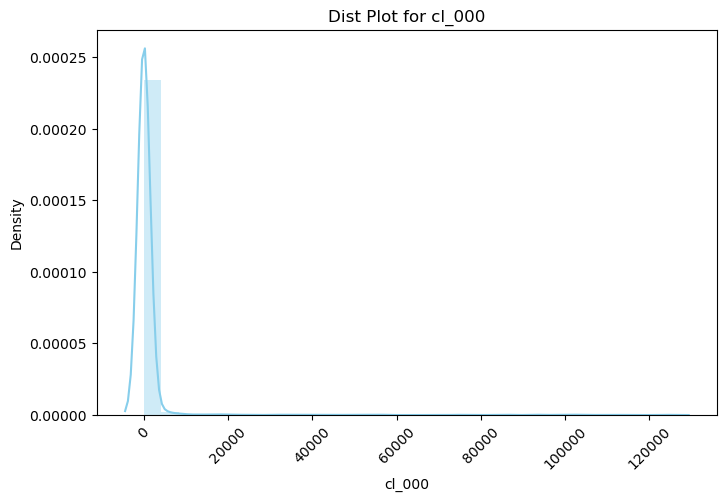

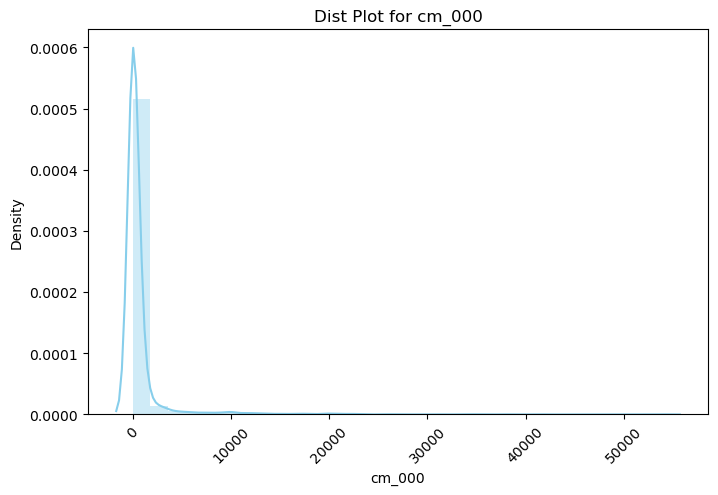

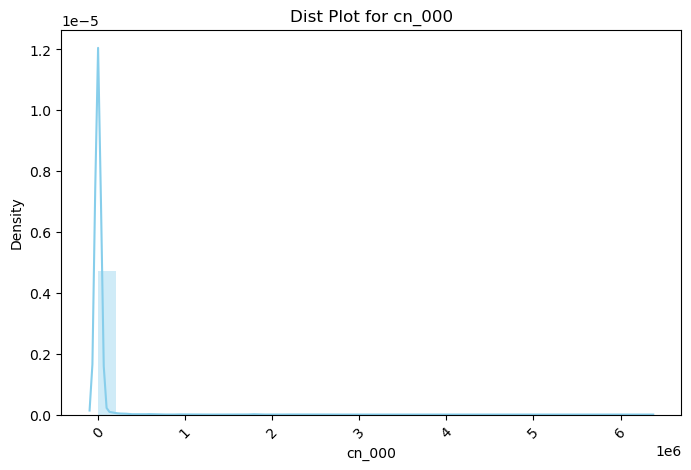

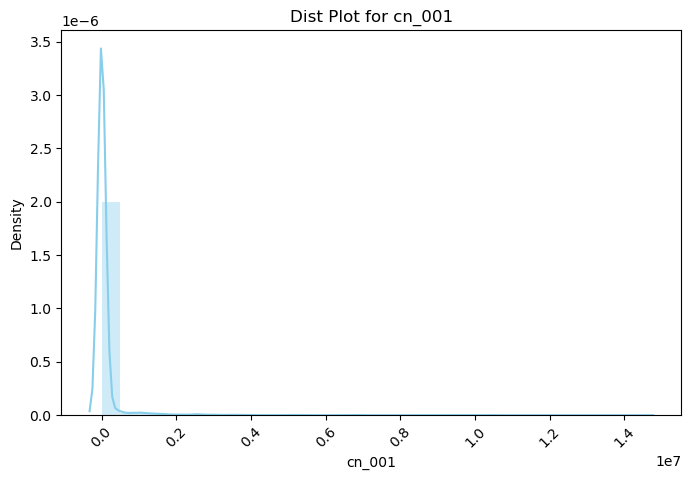

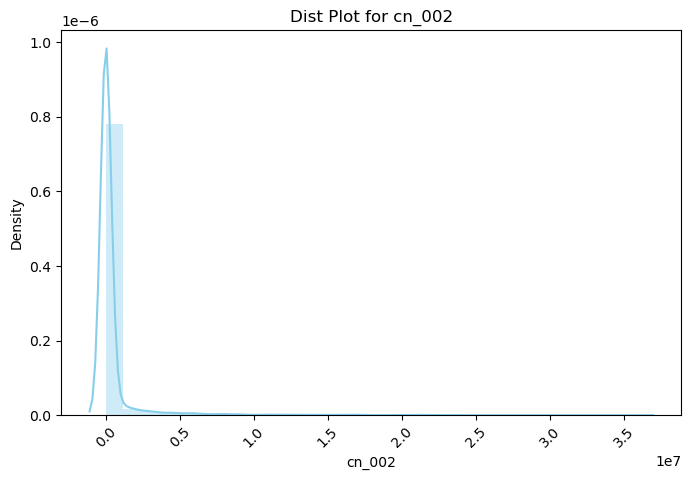

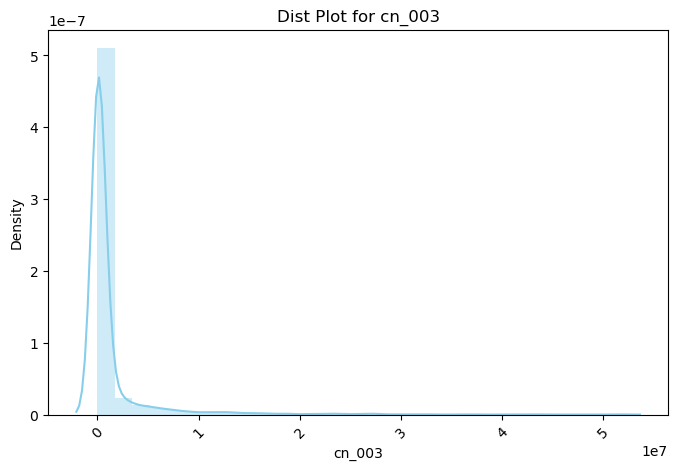

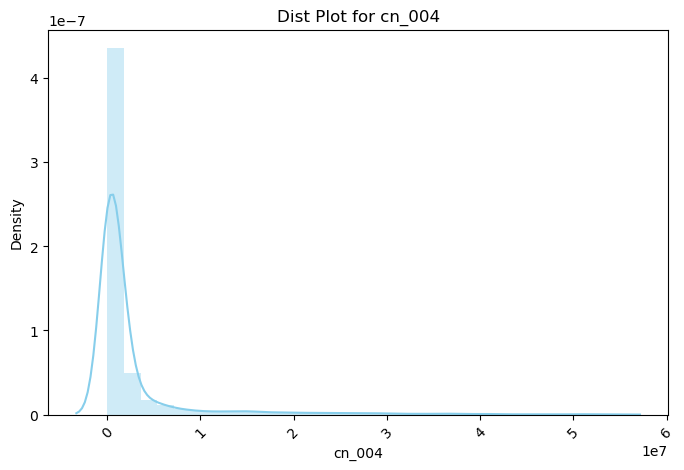

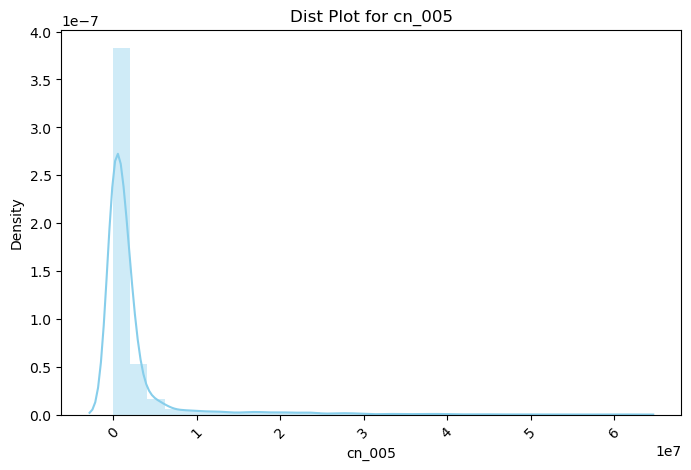

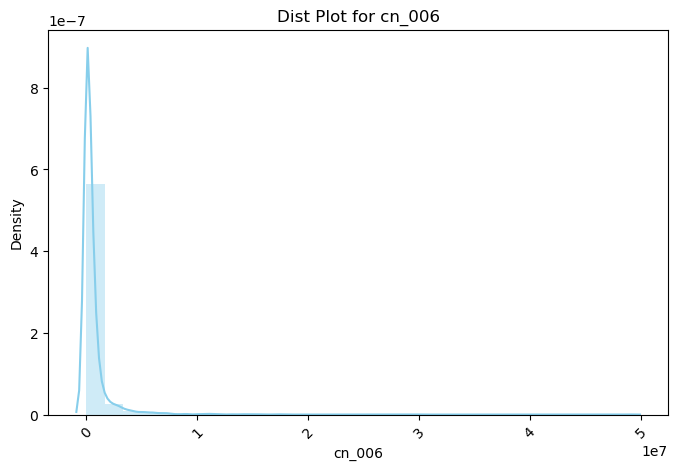

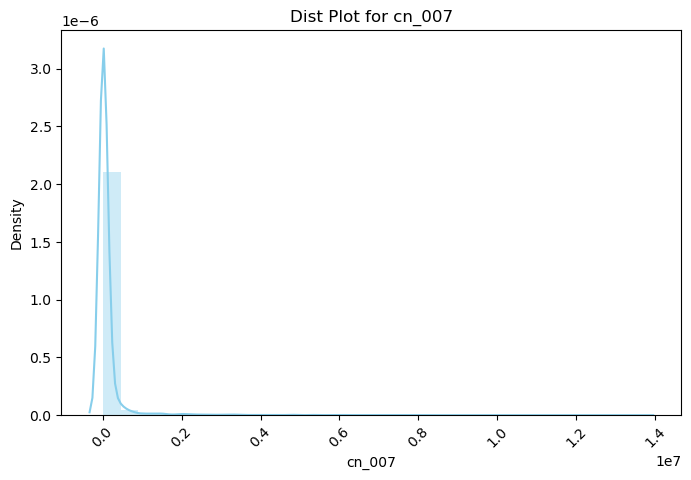

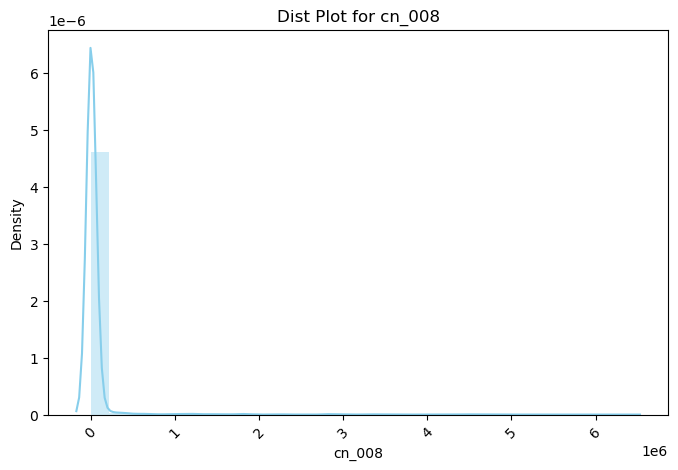

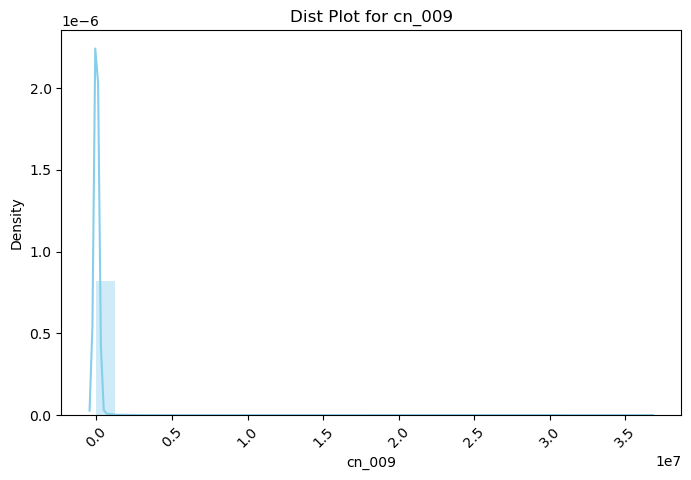

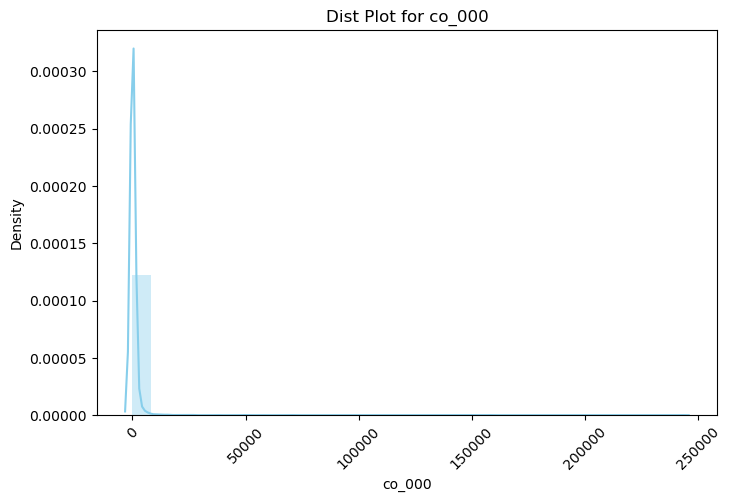

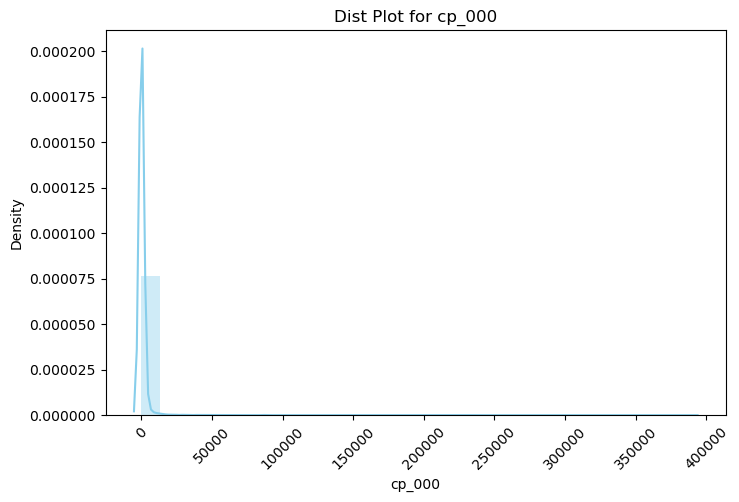

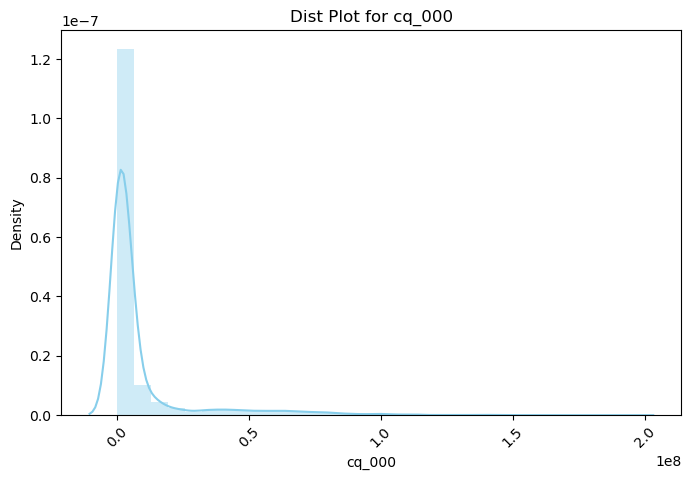

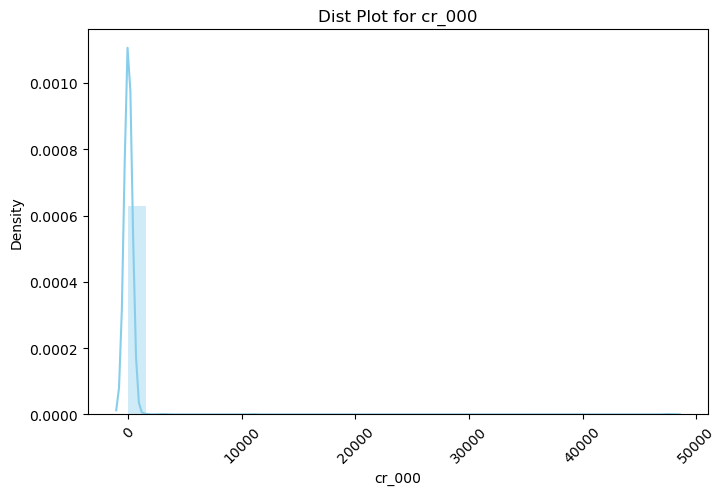

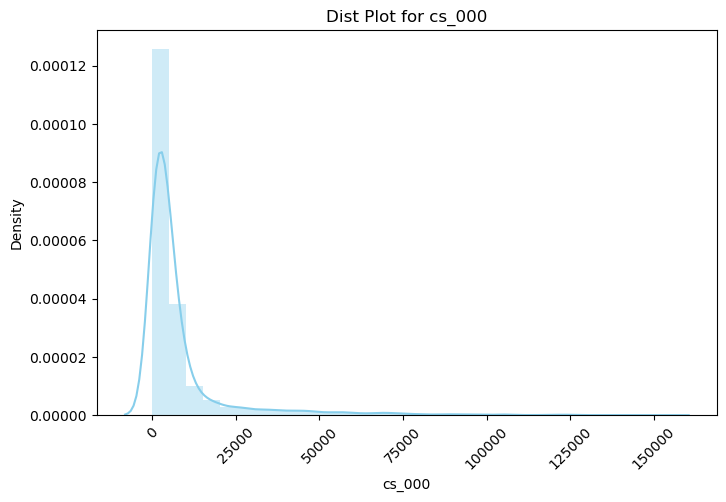

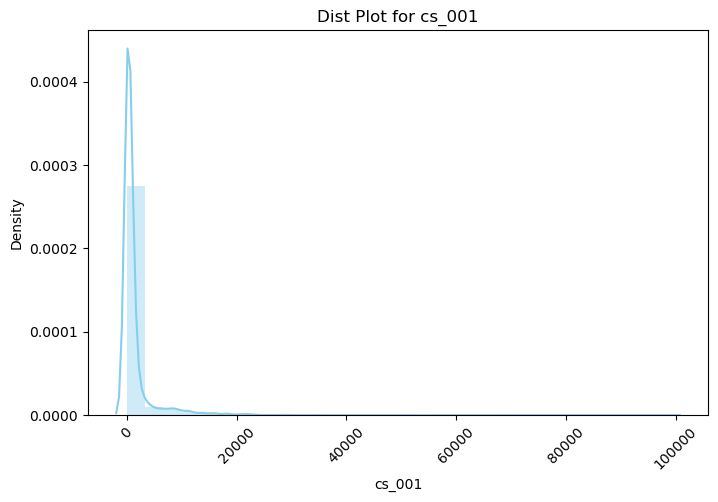

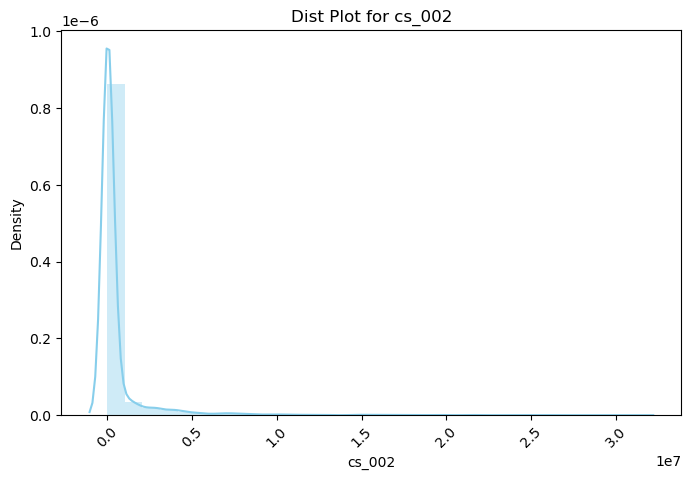

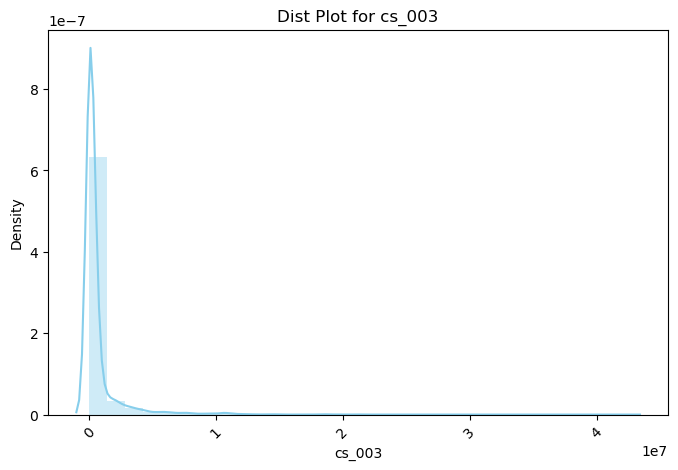

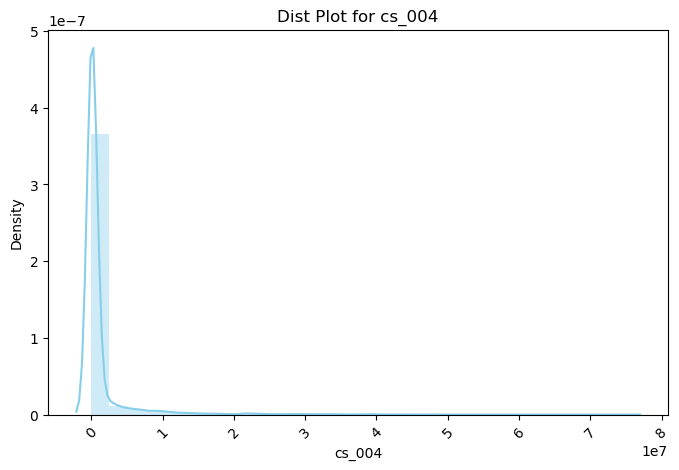

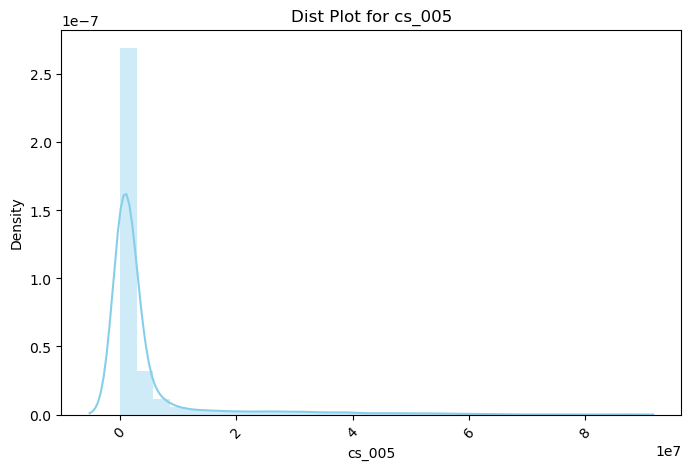

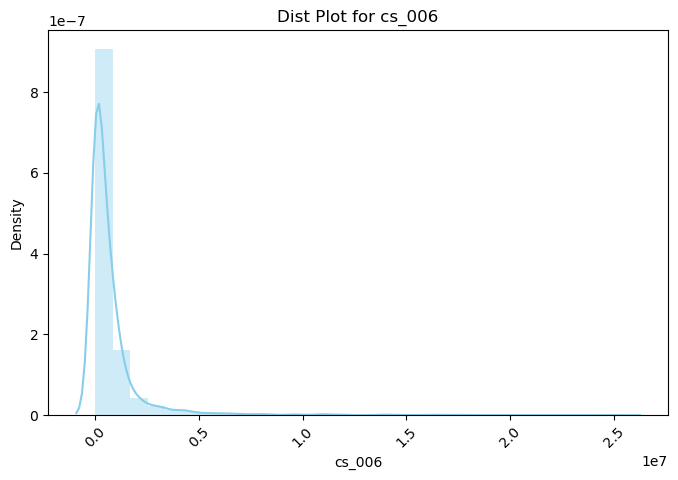

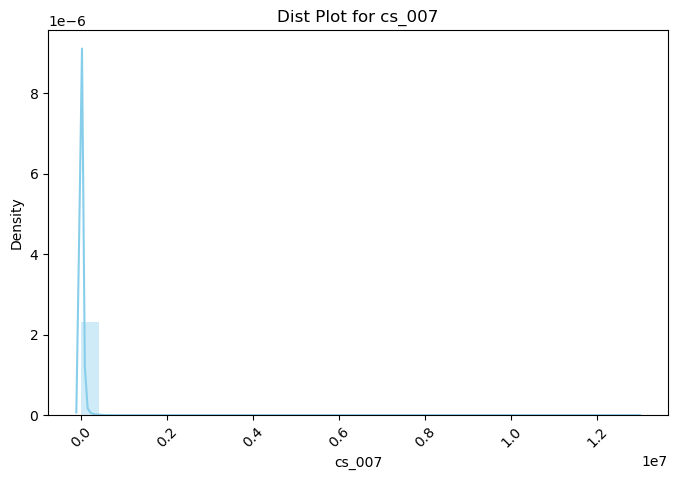

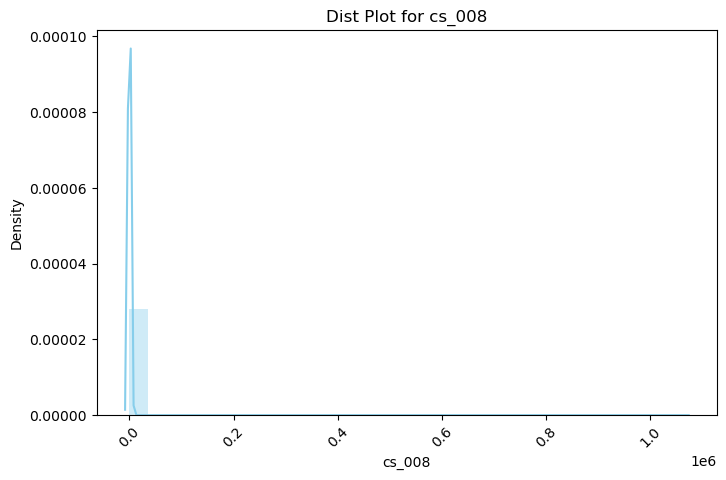

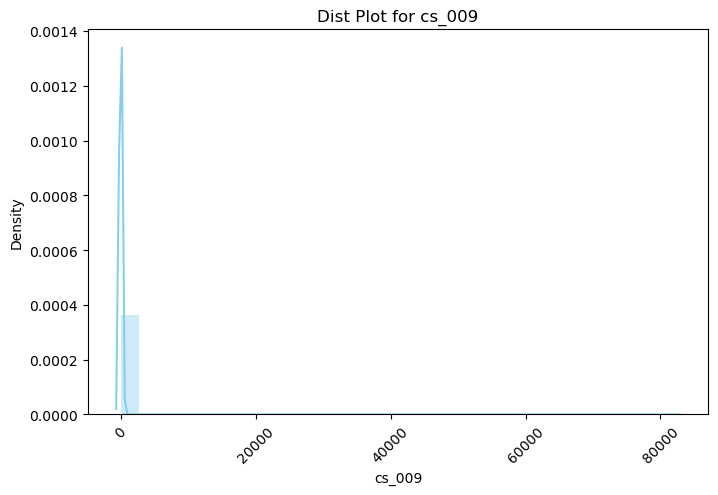

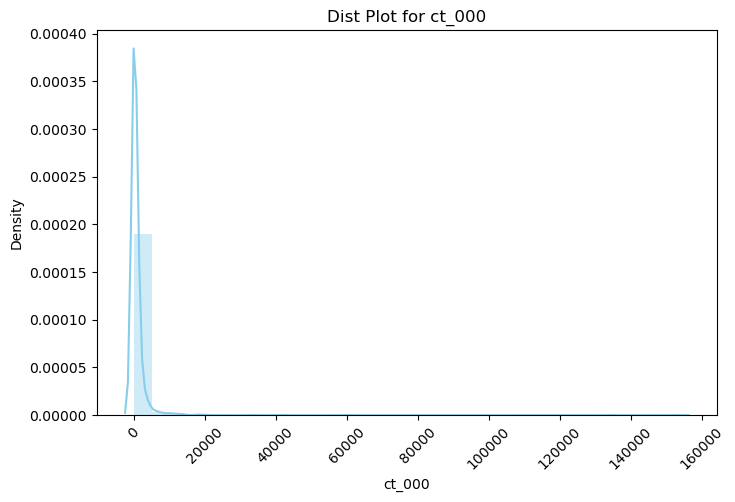

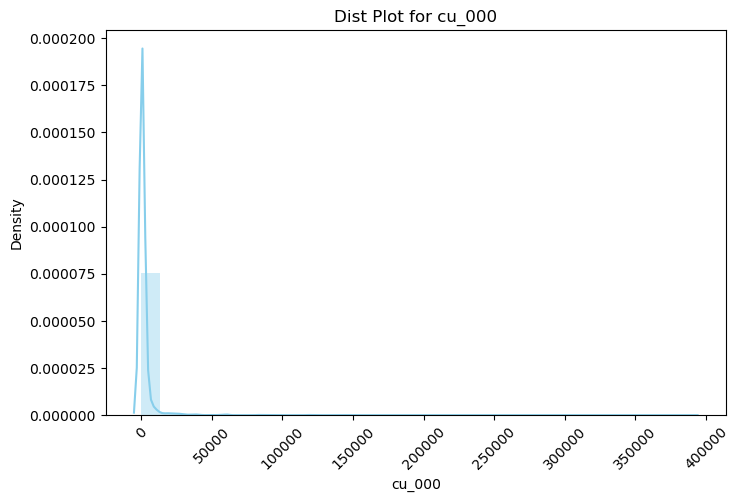

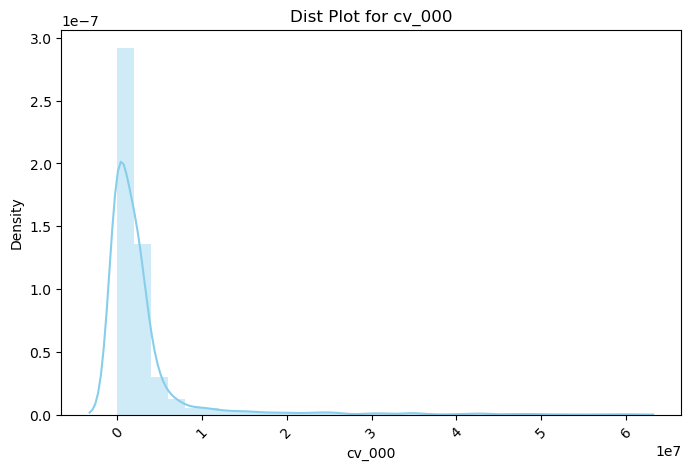

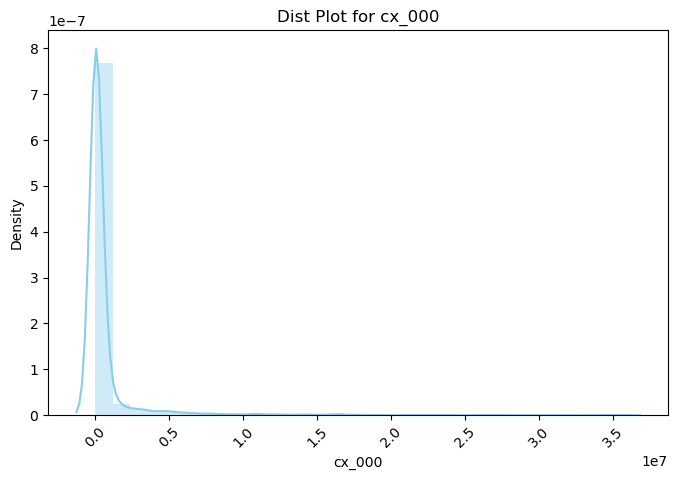

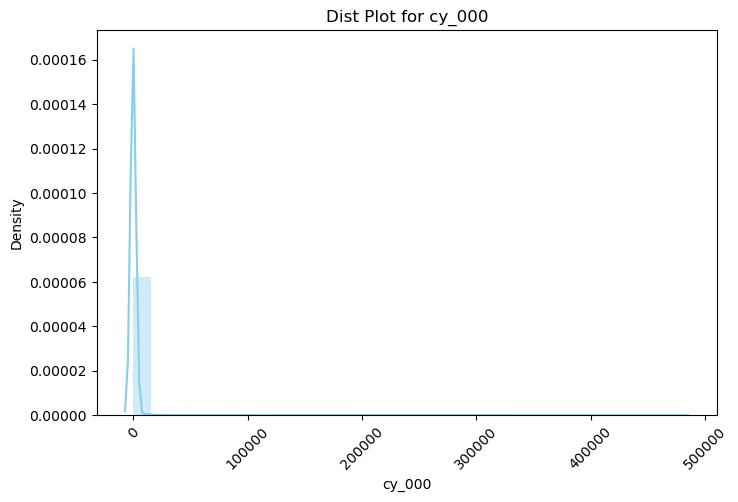

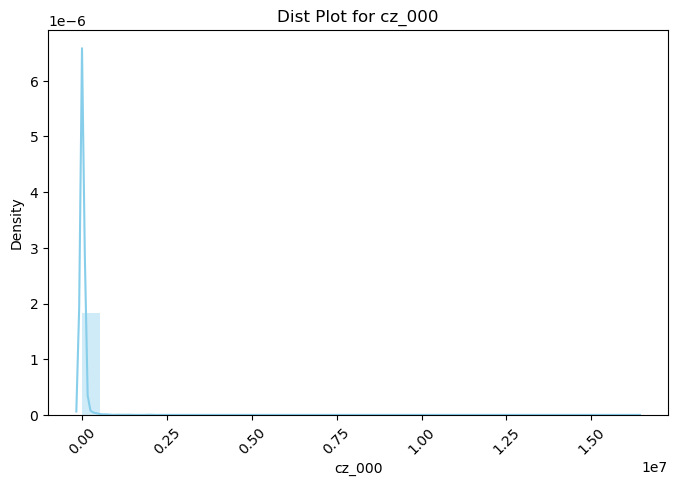

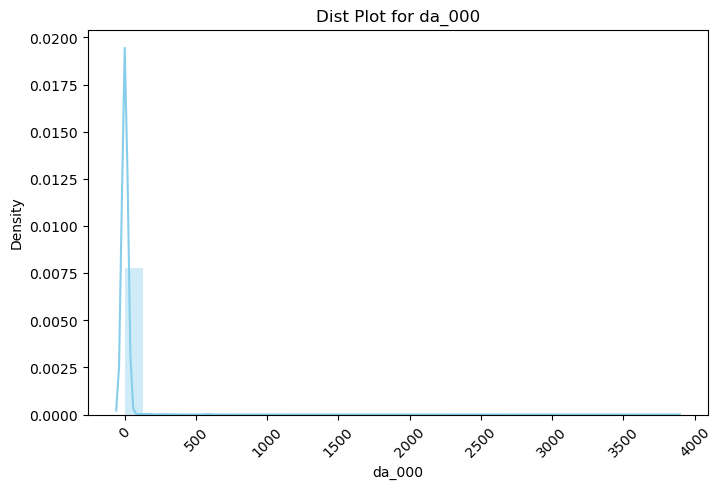

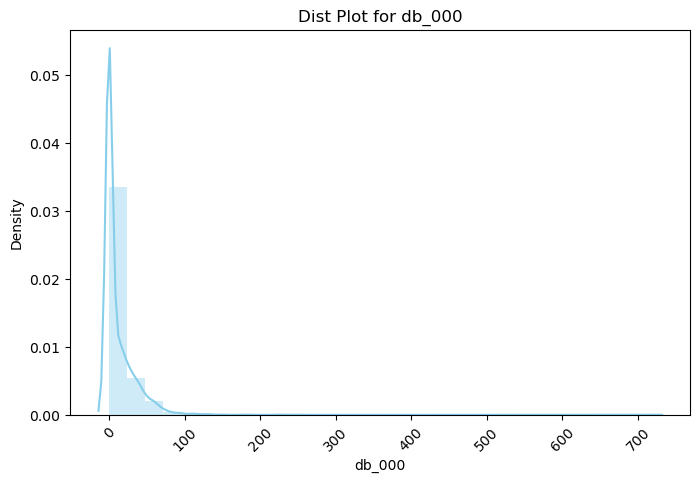

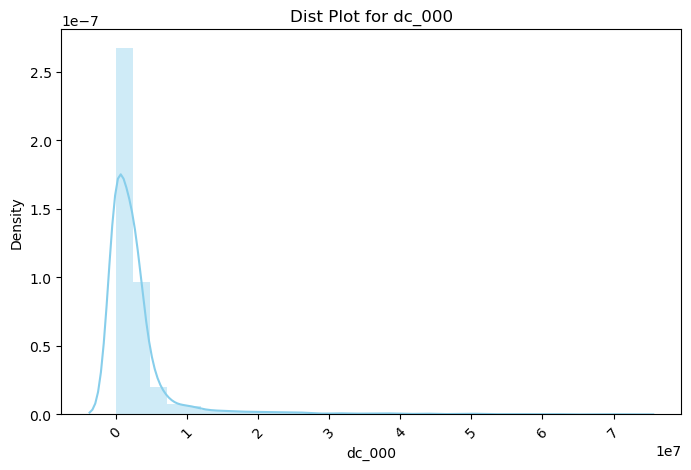

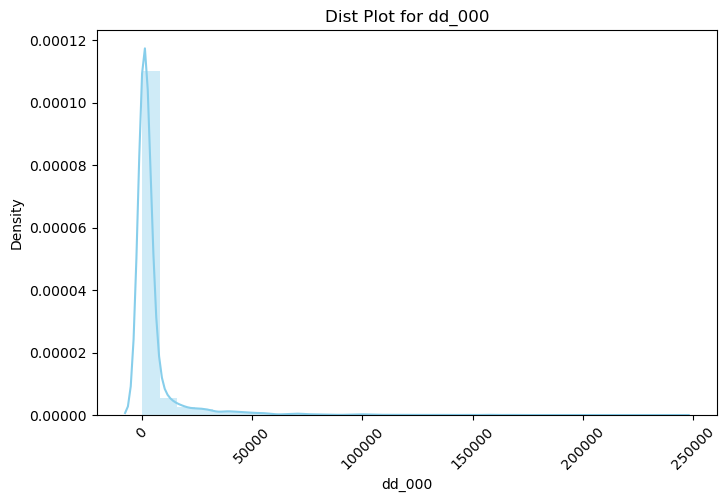

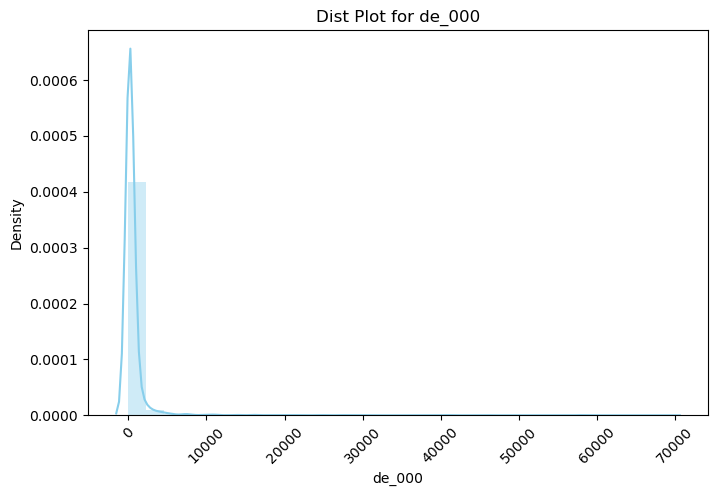

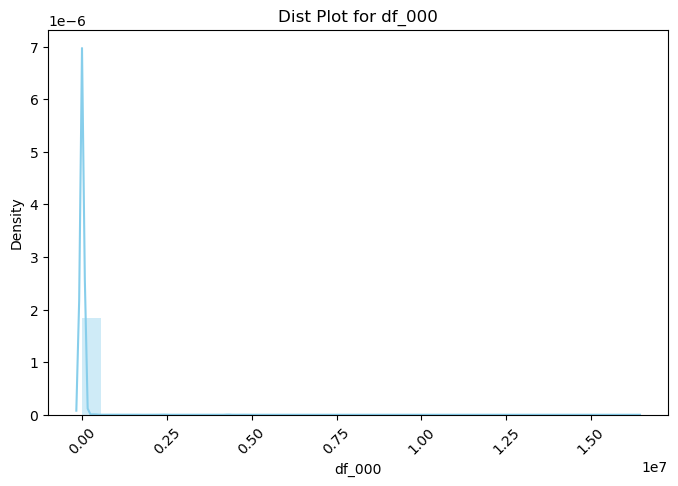

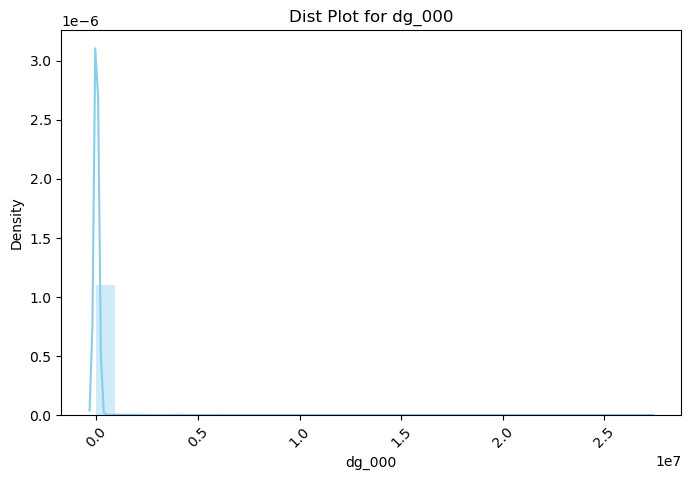

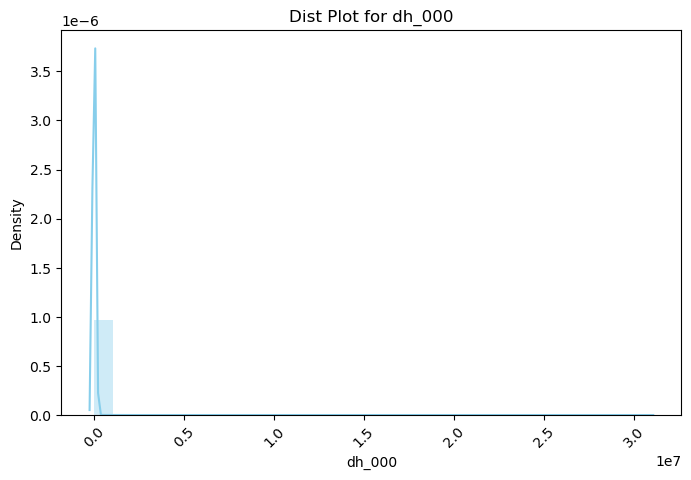

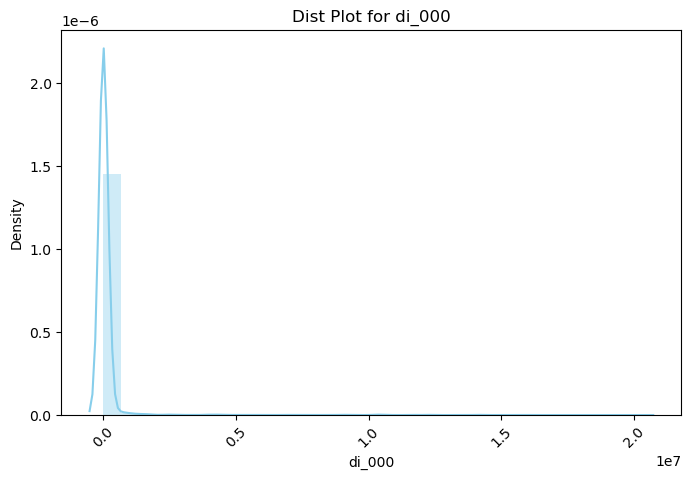

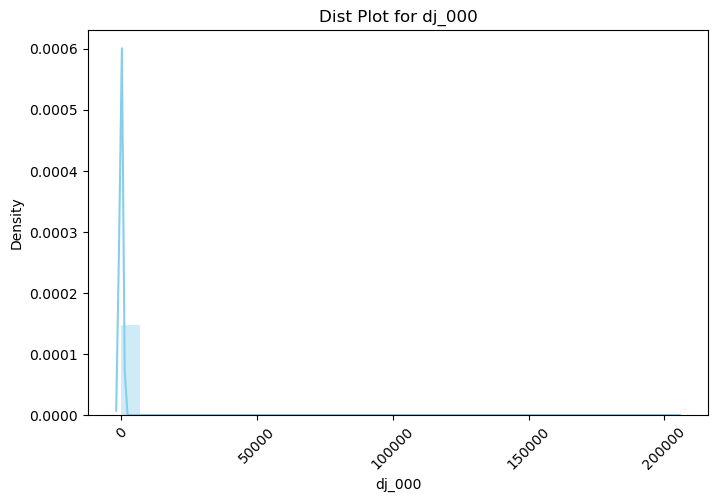

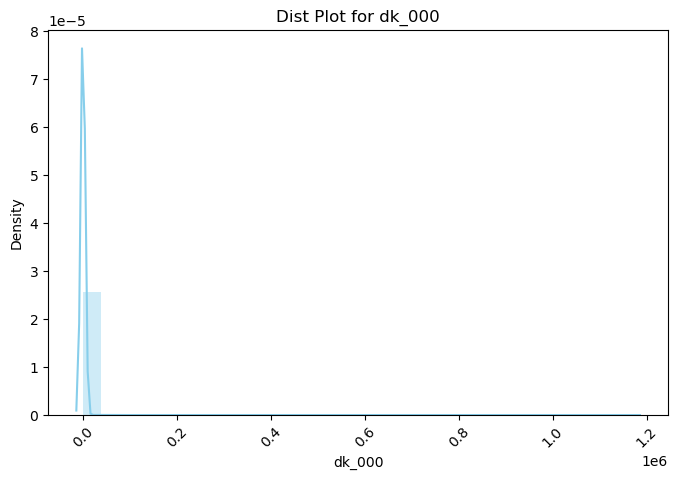

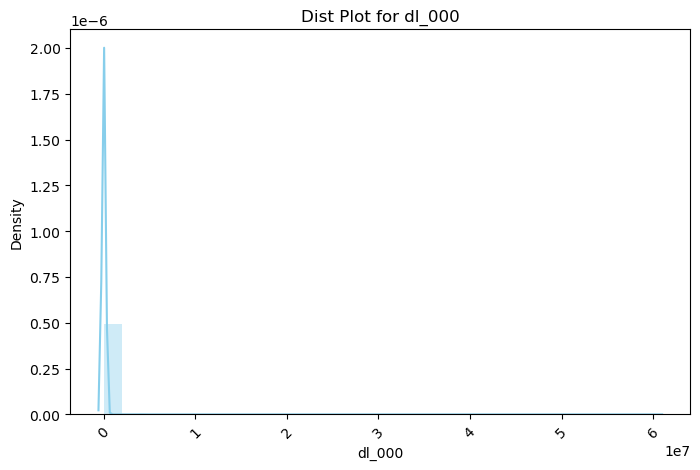

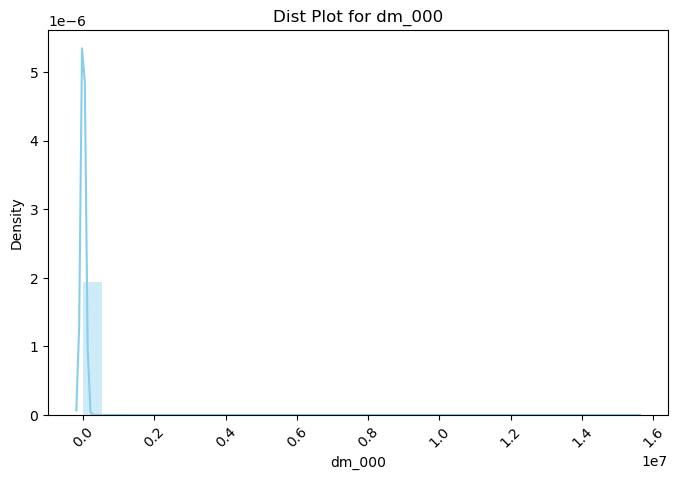

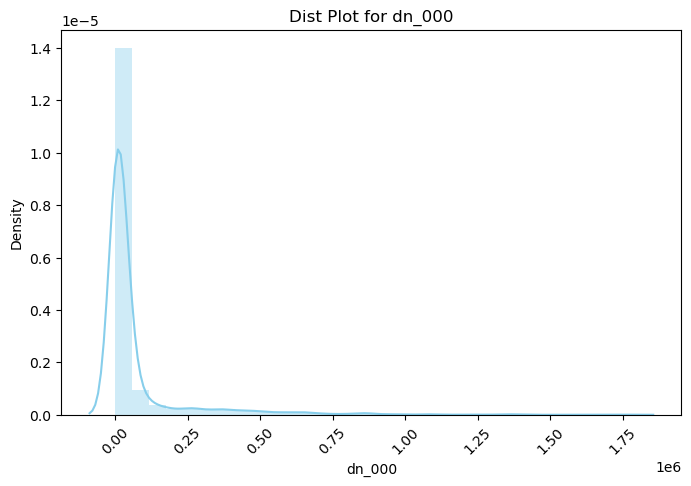

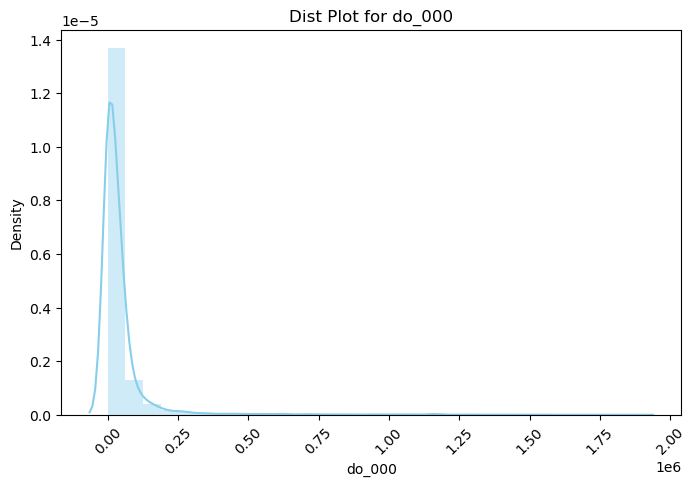

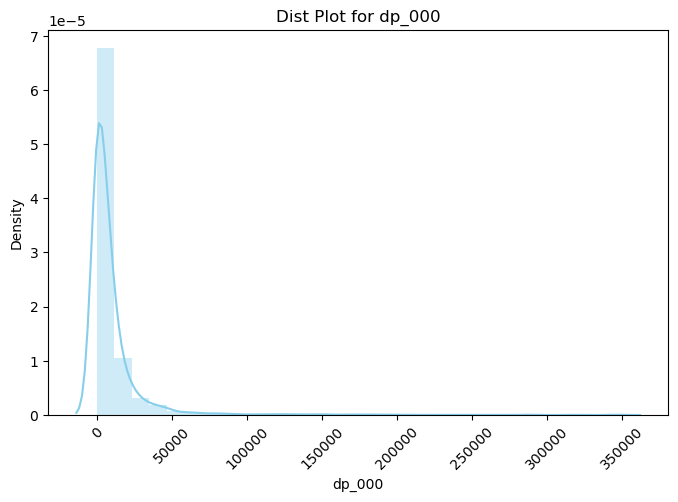

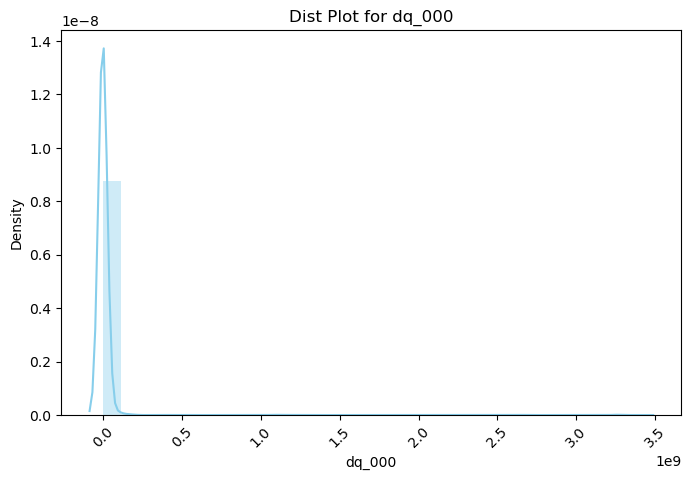

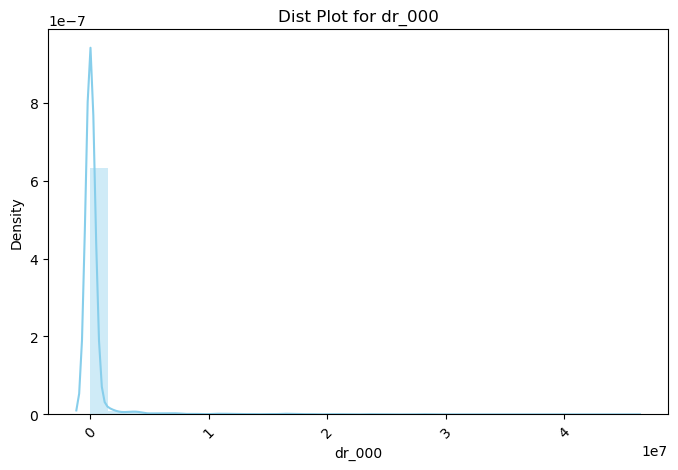

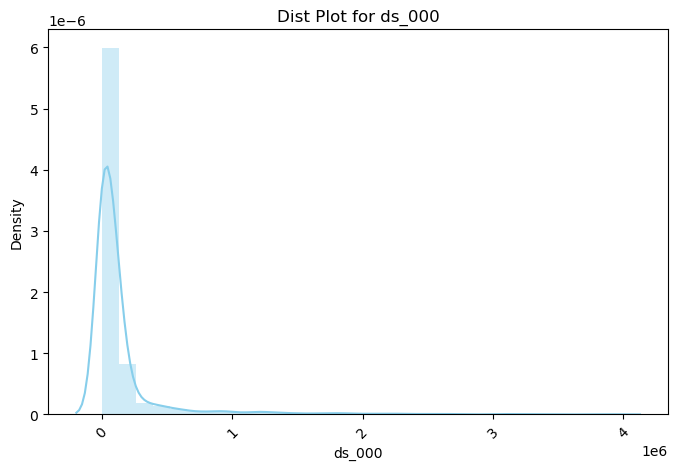

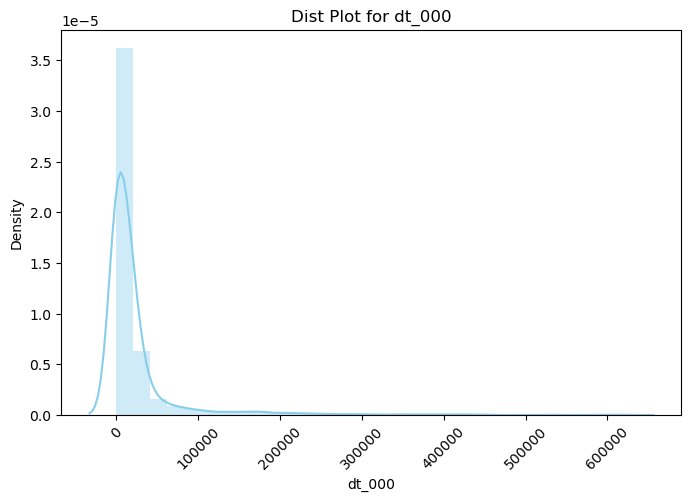

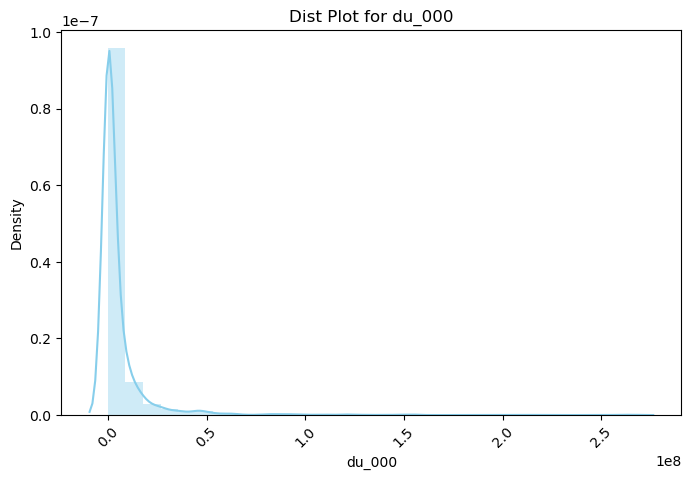

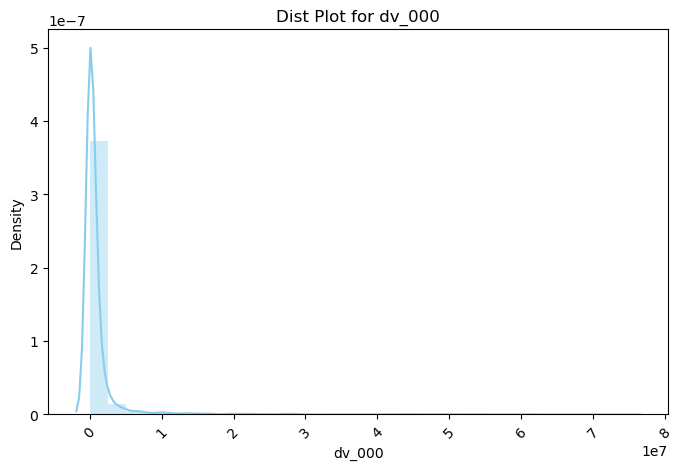

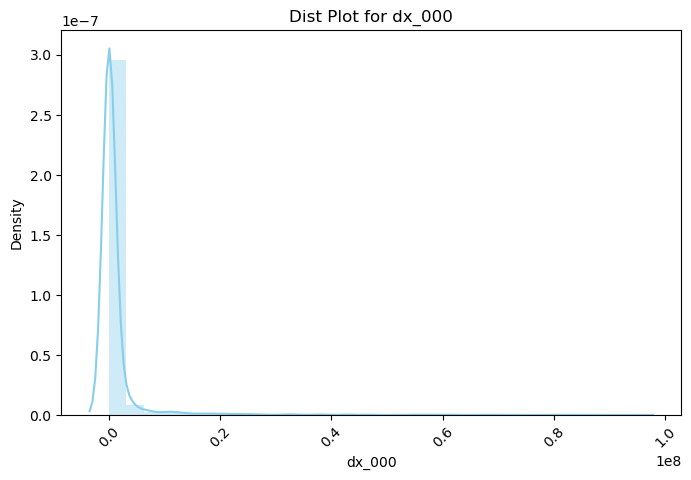

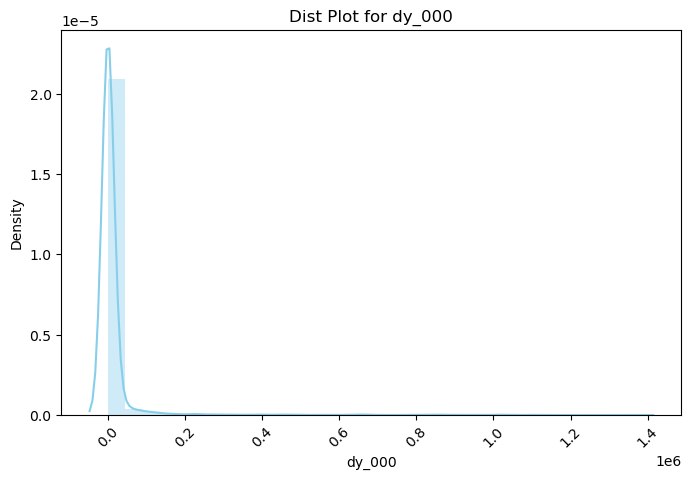

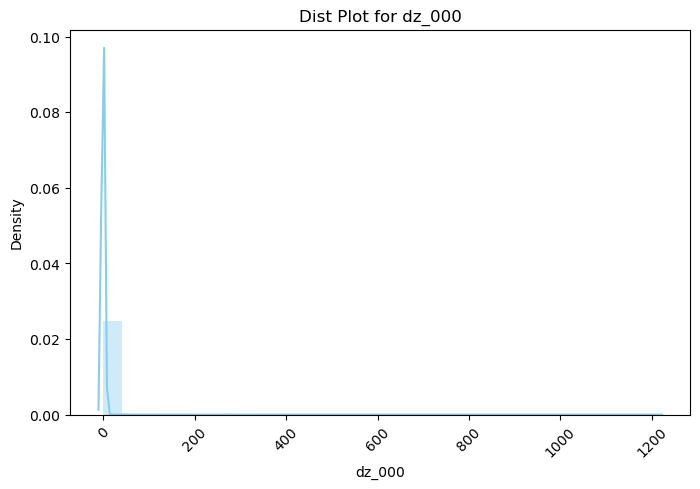

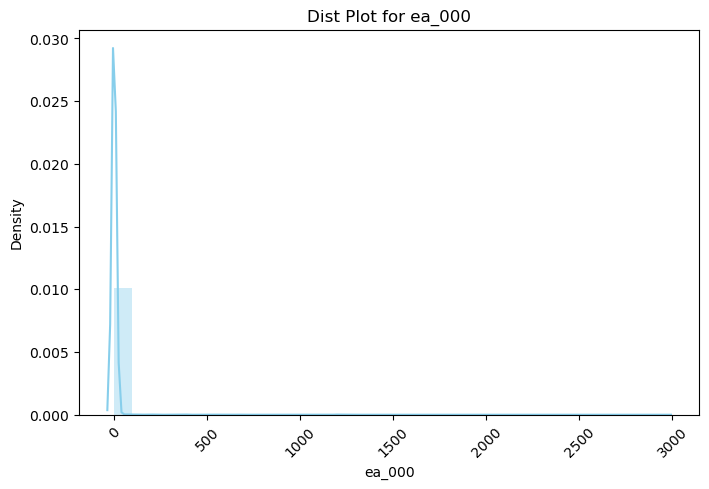

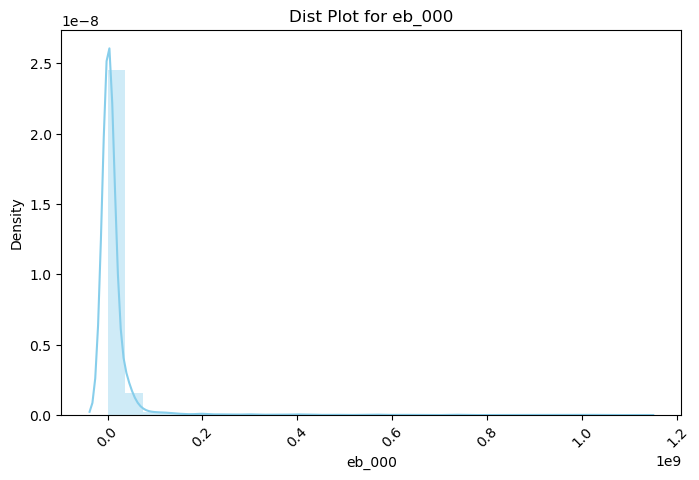

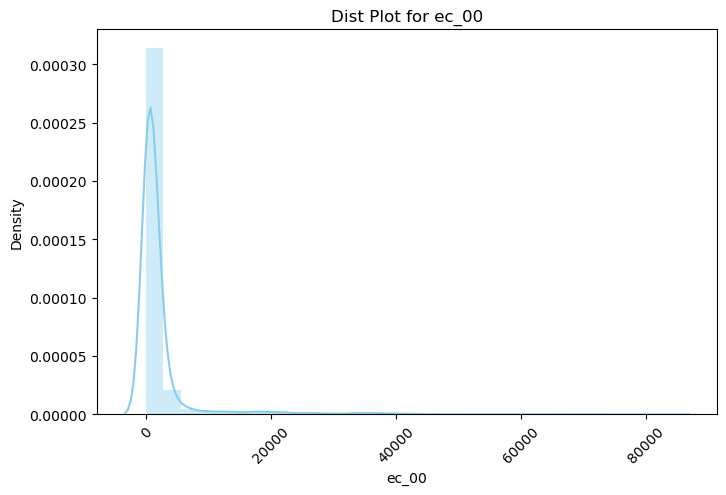

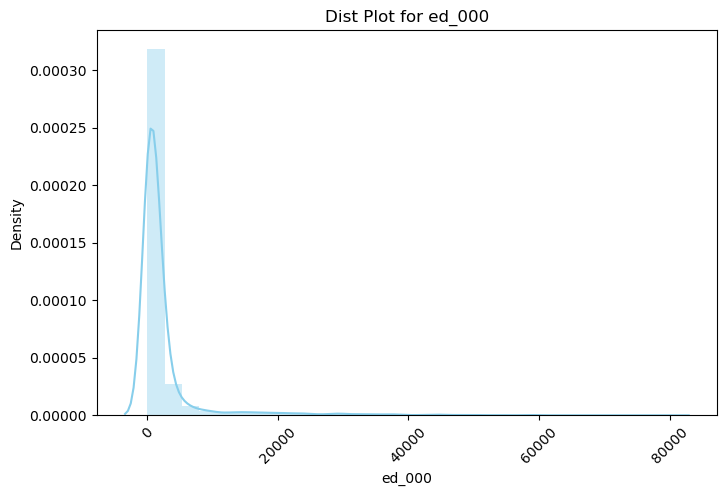

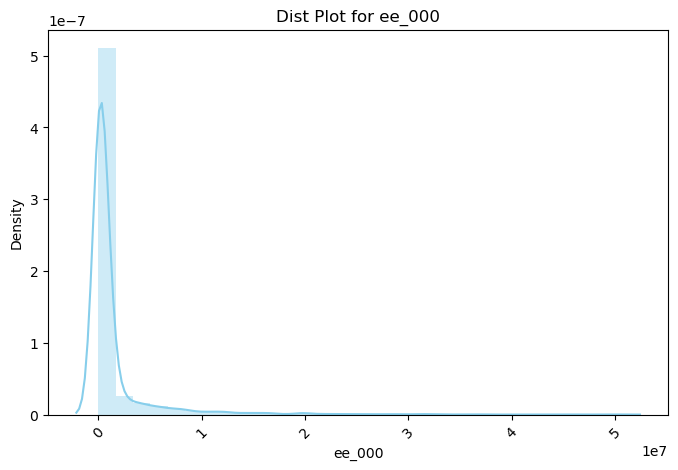

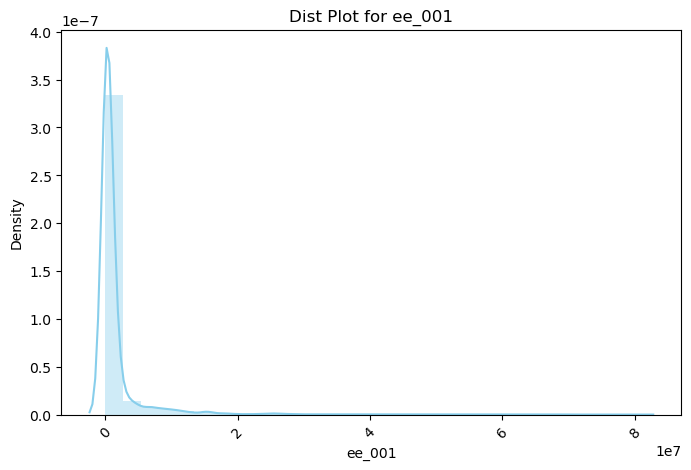

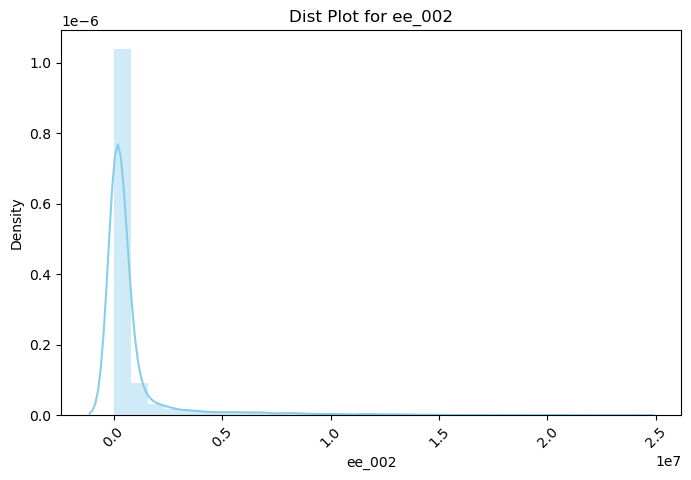

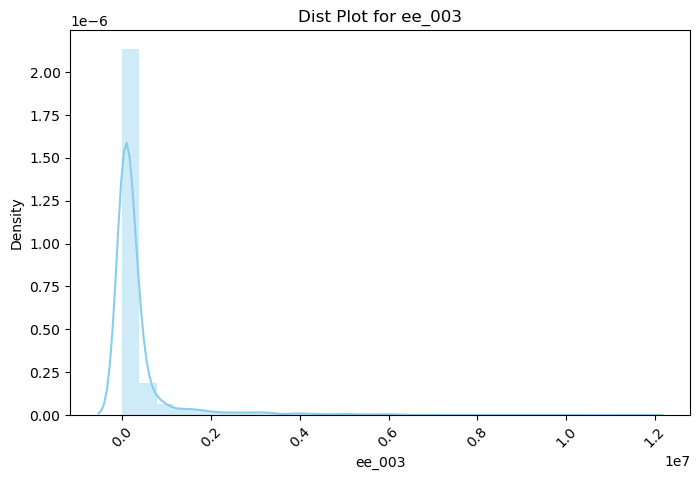

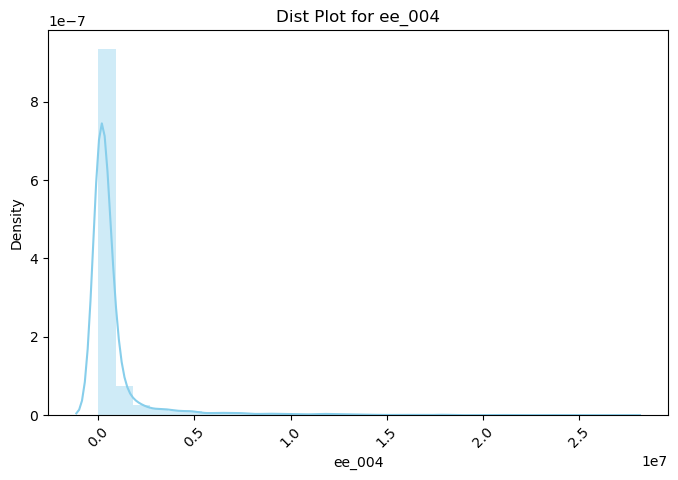

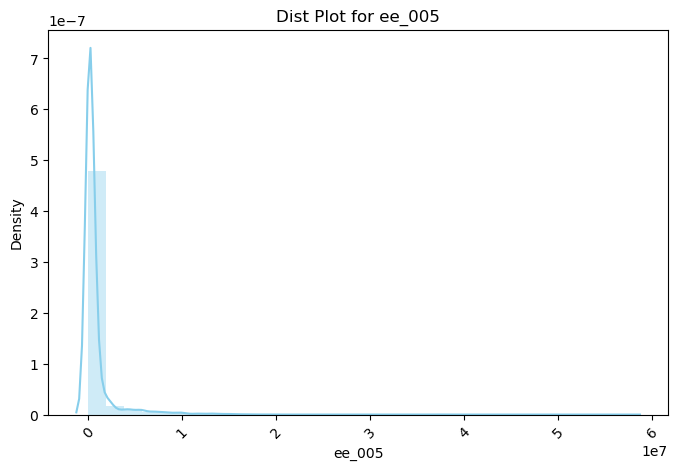

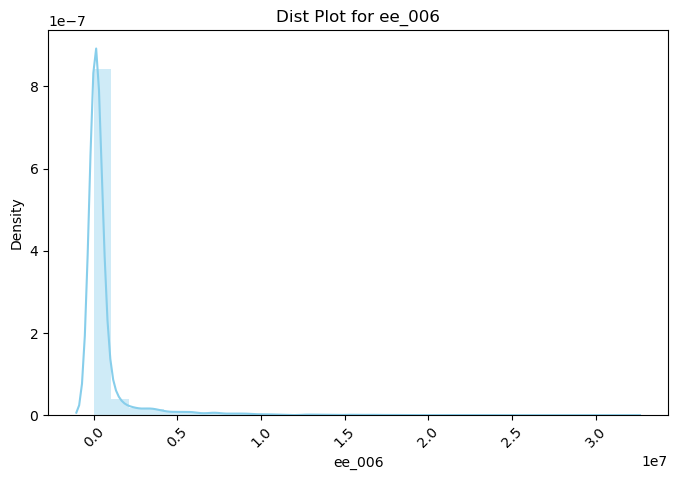

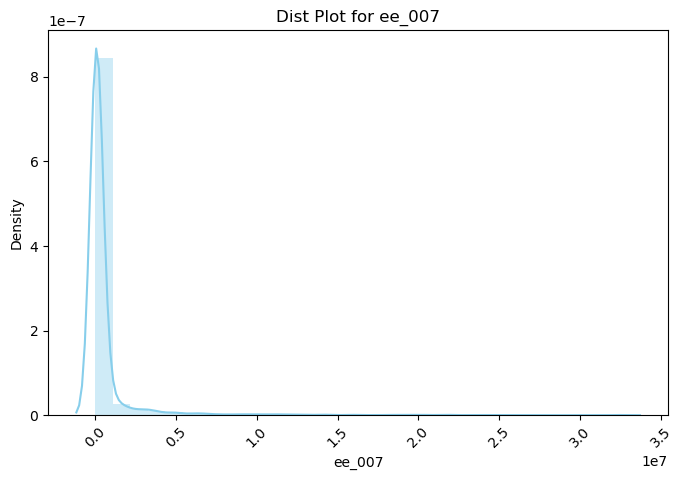

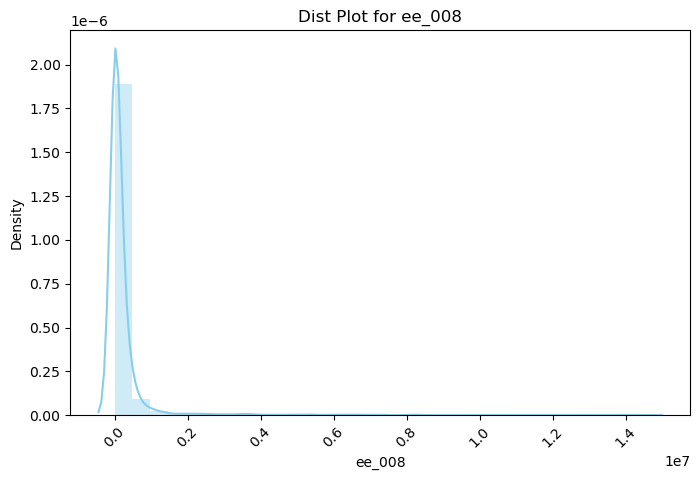

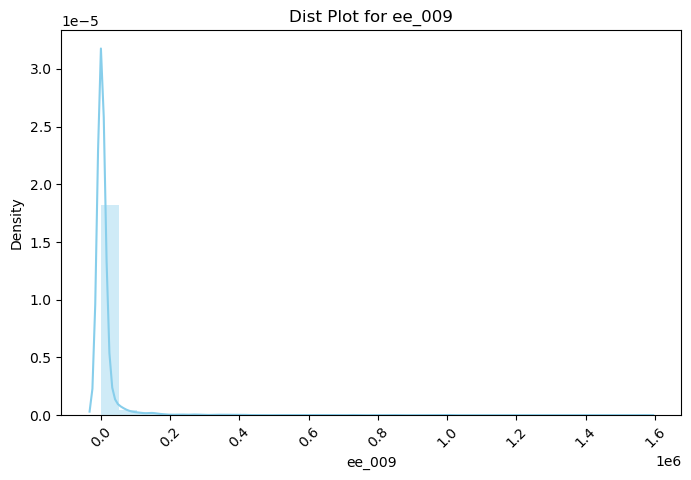

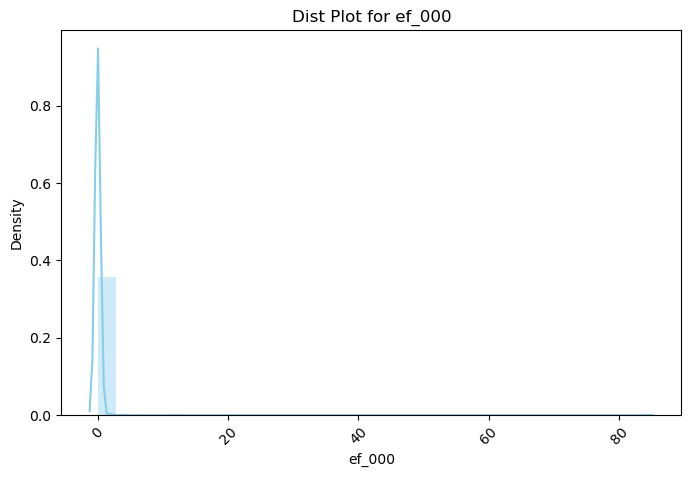

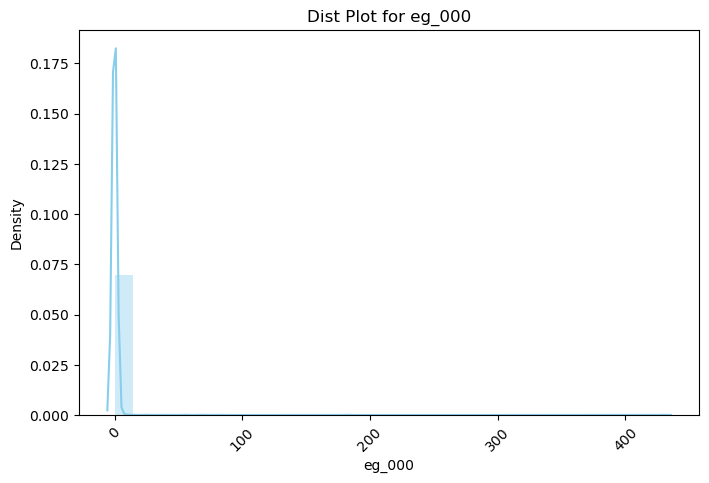

In [9]:
for features in numeric_features:
    plt.figure(figsize=(8,5))
    sns.distplot(df_copy[features], color='skyblue',bins=30,kde=True)
    plt.title(f'Dist Plot for {features}')
    plt.xticks(rotation=45)
    plt.show()

# Outliers present
# Not Normally distributed data --> Robust Scaler for scaling data

**Report**
- As per the above plot most of the features are not normally distributed.
- Transformation of data is not of prime importance since it is a classification problem.

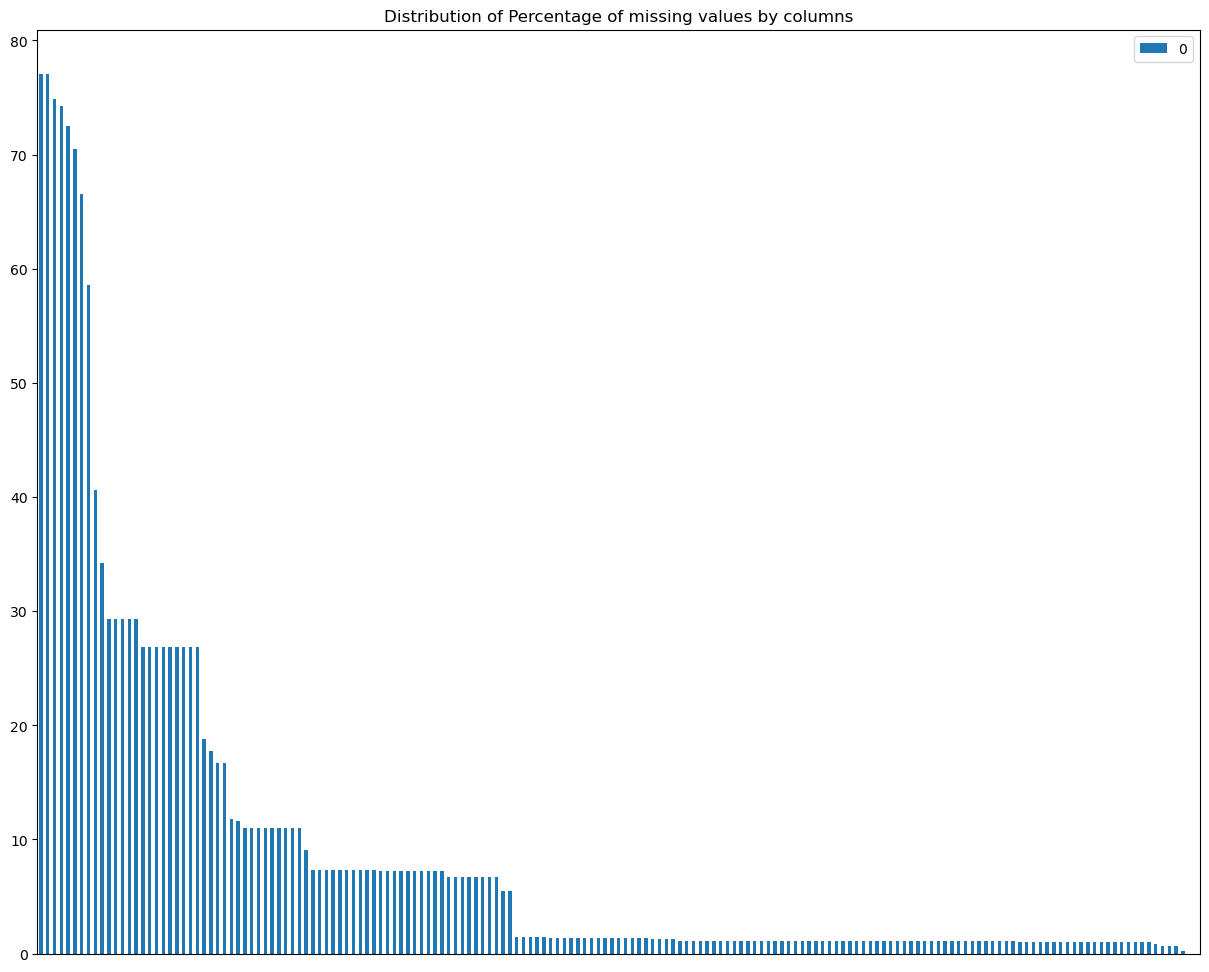

In [10]:
# Check Missing Values
df_copy.isnull().sum().div(df_copy.shape[0]).mul(100).to_frame().sort_values(by=0,ascending=False).plot(kind='bar',figsize=(15,12))
plt.xticks([])
plt.title('Distribution of Percentage of missing values by columns')
plt.show()

In [11]:
# Drop columns having missing value percentage >70

In [12]:
missing_percent=df_copy.isnull().sum().div(df_copy.shape[0]).mul(100).to_frame().sort_values(by=0,ascending=False)

In [13]:
drop_cols=missing_percent[missing_percent[0]>70].index.values

In [14]:
print(drop_cols)

['ab_000' 'cr_000' 'br_000' 'bq_000' 'bp_000' 'bo_000']


In [15]:
df_copy.drop(columns=drop_cols,axis=1,inplace=True)

In [16]:
df_copy.shape

(5000, 165)

### Check the total percentage of missing values of full dataset after dropping columns with more than 70% of missing values

In [17]:
total_cells = np.product(df.shape)
total_cells

6188148

In [18]:
missing_value_counts=df_copy.isnull().sum()
missing_values=missing_value_counts.sum()
missing_values

55457

In [19]:
print(f'Missing value percentage in the whole datset: {round((missing_values/total_cells)*100,4)}')

Missing value percentage in the whole datset: 0.8962


**Report**
- Interpreting each and every column is not necessary as this is sensor data

## Create Functions for model training and evaluation
1. Function to calculate accuracy scores
2. Function to calculate total cost (false positive and false negatives)
3. Function to evaluate model

In [20]:
'''
This function takes in true values and predicted values
Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
'''
def calculate_score(actual,predicted):
    acc=accuracy_score(actual,predicted)
    prec=precision_score(actual,predicted)
    recall=recall_score(actual,predicted) 
    f1=f1_score(actual,predicted)
    roc=roc_auc_score(actual,predicted)
    return acc, prec, recall, f1, roc

In [21]:
'''
This function takes y_ture, y_predicted, and prints Total cost due to misclassification
Cost_1=10, Cost_2=100
- The total cost of a prediction model the sum of `Cost_1` multiplied by the number of Instances with type 1 failure and `Cost_2` with the number of instances with type 2 failure, resulting in a `Total_cost`. In this case `Cost_1` refers to the cost that an unnessecary check needs to be done by an mechanic at an workshop, while `Cost_2` refer to the cost of missing a faulty device, which may cause a breakdown. 
- `Total_cost = Cost_1 * No_Instances + Cost_2 * No_Instances.`
'''
def total_cost(actual, predicted):
    tn,fp,fn,tp=confusion_matrix(actual, predicted).ravel()
    cost = 10*fp + 100*fn
    return cost

In [22]:
# Dictionary which contains models for experiment
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "SVC":SVC(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
    "AdaBoost Classifier": AdaBoostClassifier()
}
#"CatBoosting Classifier": CatBoostClassifier(verbose=False),

In [59]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

    # Create list useful for the report artifact
    cost_list=[]
    model_list = []
    f1_score_list = []

    for i in range(len(models)):
    #Train Model function:
        model=list(models.values())[i]
    #Train dataset
        model.fit(X_train,y_train)
    #Predict classification using model
        y_train_pred=model.predict(X_train)
        y_test_pred=model.predict(X_test)
        
    #Training Set performance
        acc_train, prec_train, recall_train, f1_train, roc_train=calculate_score(y_train, y_train_pred)
        total_cost_train=total_cost(y_train, y_train_pred)
        
    #Test Set performance
        acc_test, prec_test, recall_test, f1_test, roc_test=calculate_score(y_test, y_test_pred)
        total_cost_test=total_cost(y_test, y_test_pred)
        
    #Print Performance for each model
        print(list(models.keys())[i])
        print('Model Performance for Training Dataset:')
        print('Accuracy Score : {:.4f}'.format(acc_train))
        print('Precision Score : {:.4f}'.format(prec_train))
        print('Recall Score : {:.4f}'.format(recall_train))
        print('F1 Score : {:.4f}'.format(f1_train))
        print('ROC Score : {:.4f}'.format(roc_train))
        print('Total Cost : {:.4f}'.format(total_cost_train))
        print('-'*35)

        print(list(models.keys())[i])
        print('Model Performance for Test Dataset:')
        print('Accuracy Score : {:.4f}'.format(acc_test))
        print('Precision Score : {:.4f}'.format(prec_test))
        print('Recall Score : {:.4f}'.format(recall_test))
        print('F1 Score : {:.4f}'.format(f1_test))
        print('ROC Score : {:.4f}'.format(roc_test))
        print('Total Cost : {:.4f}'.format(total_cost_test))
        print('-'*35)

        cost_list.append(total_cost_test)
        model_list.append(list(models.keys())[i])
        f1_score_list.append(f1_test)
        
#Generate Report
    report=pd.DataFrame(list(zip(model_list,cost_list)),columns=['Model Name', 'Cost']).sort_values(by=["Cost"])
    report=report.reset_index(drop=True)
    return report

# Splitting x and y: independent and dependent features for all experiment:

In [24]:

X=df_copy.drop(columns=['class'],axis =1)
y=df_copy['class']

In [25]:
X.head()

aa_000  ac_000  ad_000  ae_000  af_000  ag_000    ag_001     ag_002  \
0  153204   182.0     NaN     0.0     0.0     0.0       0.0        0.0   
1  453236  2926.0     NaN     0.0     0.0     0.0       0.0      222.0   
2   72504  1594.0  1052.0     0.0     0.0     0.0     244.0   178226.0   
3  762958     NaN     NaN     NaN     NaN   776.0  281128.0  2186308.0   
4  695994     NaN     NaN     NaN     NaN     0.0       0.0        0.0   

      ag_003      ag_004  ...     ee_002     ee_003     ee_004     ee_005  \
0    11804.0    684444.0  ...   129862.0    26872.0    34044.0    22472.0   
1   323436.0   2999280.0  ...  7908038.0  3026002.0  5025350.0  2025766.0   
2  1249396.0   3813464.0  ...  1432098.0   372252.0   527514.0   358274.0   
3  8123016.0  18022646.0  ...        NaN        NaN        NaN        NaN   
4    55620.0   1190014.0  ...  1397742.0   495544.0   361646.0    28610.0   

      ee_006    ee_007    ee_008  ee_009  ef_000  eg_000  
0    34362.0       0.0       0.0     0.0     0.0     0.0  
1  1160638.0  533834.0  493800.0  6914.0     0.0     0.0  
2   332818.0  284178.0    3742.0     0.0     0.0     0.0  
3        NaN       NaN       NaN     NaN     NaN     NaN  
4     5130.0     212.0       0.0     0.0     NaN     NaN  

[5 rows x 164 columns]

In [26]:
y.head()

0    pos
1    pos
2    pos
3    pos
4    pos
Name: class, dtype: object

# Encoding Target feature value: 
- Manual Encoding

In [27]:
mapper={'pos':1, 'neg':0}
y=y.map(mapper)

In [28]:
y.unique()

array([1, 0], dtype=int64)

## Experiment: 1 = KNN Imputer for Null values

### 1. Scaling - to have independent dataset in the same scale
#### Why Robust scaler and not standard scaler?
- The Independent feature values donot follow normal distribution, so standard scaler won't be used
#### Why Robust scaler and not Minmax scaler?
- The Independent feature values have outliers, which can be handled by Robust Scaler, as it uses IQR to scale, while minmax scaler can't be used as it uses the max value
### 2. Handle Missing values:
- KNN imputer - missing value replaced by nearest neighbor concept

### 3. Handle Imbalanced dataset
- SMOTOMEK is to be used which user hybrid technique of oversampling and undersampling

### 4. Evaluate Model and hyperparameter tuning
- Evaluate models when missing value imputed by KNN imputer

### 5. Generate Report
- Generate various metrics for models and choose the best model performed

In [29]:
#1. Fit with Robust Scaler 
robustScaler=RobustScaler()
X_scaled=robustScaler.fit_transform(X)

 **2. Why KNN Imputer**?
- KNNImputer by scikit-learn is a widely used method to impute missing values. It is widely being observed as a replacement for traditional imputation techniques.
- KNNImputer helps to impute missing values present in the observations by finding the nearest neighbors with the Euclidean distance matrix.
- Here we Iterates through different K values and get accuracy and choose best K values.


**Finding the optimal n_neighbour value for KNN imputer**

In [30]:
result_score=[]
n_values=[str(i) for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]]

for n in n_values:
    pipeline=Pipeline(steps=[
        ('knn_imputer',KNNImputer(n_neighbors=int(n))),
        ('lr_model',LogisticRegression())
    ])
    scores=cross_val_score(pipeline, X_scaled, y, scoring='accuracy',cv=5)
    #scores = cross_val_score(pipeline, X_scaled, y, scoring='accuracy', cv=2, n_jobs=-1)
    result_score.append(scores)
    print('n_neighbors: {} and accuracy {:.4f}'.format(n, mean(scores)))

n_neighbors: 1 and accuracy 0.5886
n_neighbors: 2 and accuracy 0.5900
n_neighbors: 3 and accuracy 0.5846
n_neighbors: 4 and accuracy 0.5578
n_neighbors: 5 and accuracy 0.5262
n_neighbors: 6 and accuracy 0.5128
n_neighbors: 7 and accuracy 0.5090
n_neighbors: 8 and accuracy 0.5132
n_neighbors: 9 and accuracy 0.5110
n_neighbors: 10 and accuracy 0.5066
n_neighbors: 11 and accuracy 0.4998
n_neighbors: 12 and accuracy 0.5012
n_neighbors: 13 and accuracy 0.5054
n_neighbors: 14 and accuracy 0.5106
n_neighbors: 15 and accuracy 0.4922
n_neighbors: 16 and accuracy 0.5122
n_neighbors: 17 and accuracy 0.4922
n_neighbors: 18 and accuracy 0.4964
n_neighbors: 19 and accuracy 0.4926
n_neighbors: 20 and accuracy 0.4856


##### n_neighbors: 2 gives the highest accuracy

In [31]:
# Pipeline for KNN Imputer: First impute, then scale
knn_pipeline=Pipeline(steps=[
    ('knn_imputer',KNNImputer(n_neighbors=3,weights='uniform', metric='nan_euclidean')),
    ('robust_scaler',RobustScaler())
])
X_knn=knn_pipeline.fit_transform(X)

#### 3. Handle Imbalanced Dataset - somtomek
 **SMOTE+TOMEK** is one of such a hybrid technique that aims to clean overlapping data points for each of the classes distributed in sample space.
 
 - This method combines the SMOTE ability to generate synthetic data for minority class and Tomek Links ability to remove the data that are identified as Tomek links from the majority class
 
 - To add new data of minority class
 1. Choose random data from the minority class.
 2. Calculate the distance between the random data and its k nearest neighbors.
 3. Multiply the difference with a random number between 0 and 1, then add the result to the minority class as a synthetic sample.
 4. Repeat step number 2–3 until the desired proportion of minority class is met.
 
 - To remove the tomek links of the majority class
 1. Choose random data from the majority class.
 2. If the random data’s nearest neighbor is the data from the minority class (i.e. create the Tomek Link), then remove the Tomek Link.
 
 - This is method instead of adding duplicate data it synthesises the new data based on the already avalialble classes. Hence we choose this as our imputer method for this problem.

In [32]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='auto',n_jobs=-1)
# Fit the model to generate the data.
X_res,y_res=smt.fit_resample(X_knn,y)

### 4. Evaluate Models by fitting knn imputed scaled and balanced dataset

In [60]:
report_knn=evaluate_models(X_res,y_res,models)

Random Forest
Model Performance for Training Dataset:
Accuracy Score : 1.0000
Precision Score : 1.0000
Recall Score : 1.0000
F1 Score : 1.0000
ROC Score : 1.0000
Total Cost : 0.0000
-----------------------------------
Random Forest
Model Performance for Test Dataset:
Accuracy Score : 0.9690
Precision Score : 0.9606
Recall Score : 0.9804
F1 Score : 0.9704
ROC Score : 0.9686
Total Cost : 2170.0000
-----------------------------------
Decision Tree
Model Performance for Training Dataset:
Accuracy Score : 1.0000
Precision Score : 1.0000
Recall Score : 1.0000
F1 Score : 1.0000
ROC Score : 1.0000
Total Cost : 0.0000
-----------------------------------
Decision Tree
Model Performance for Test Dataset:
Accuracy Score : 0.9662
Precision Score : 0.9653
Recall Score : 0.9695
F1 Score : 0.9674
ROC Score : 0.9661
Total Cost : 3120.0000
-----------------------------------
Gradient Boosting
Model Performance for Training Dataset:
Accuracy Score : 0.9897
Precision Score : 0.9884
Recall Score : 0.9909
F

### Report for Experiment 1: KNN Imputer for Robust Scaled Data and handle imbanced dataset by SMOKETomek

In [61]:
report_knn

Model Name   Cost
0           XGBClassifier   1330
1           Random Forest   2170
2     AdaBoost Classifier   2540
3       Gradient Boosting   2830
4           Decision Tree   3120
5  K-Neighbors Classifier   3590
6     Logistic Regression   7670
7                     SVC  30130

In [64]:
str(report_knn['Cost'][0])

'1330'

In [62]:
str(report_knn.sort_values(by='Cost',ascending=False)['Cost'][0])

'1330'

In [63]:
str(report_knn.sort_values(by='Cost',ascending=False)['Model Name'][0])

'XGBClassifier'

### - XGBClassifier performs best when imputed by KNN imputer

# Experiment 2: Simple Imputer with Strategy Median
### 1. Scaling - to have independent dataset in the same scale
#### Why Robust scaler and not standard scaler?
- The Independent feature values donot follow normal distribution, so standard scaler won't be used
#### Why Robust scaler and not Minmax scaler?
- The Independent feature values have outliers, which can be handled by Robust Scaler, as it uses IQR to scale, while minmax scaler can't be used as it uses the max value
### 2. Handle Missing values:
- Median imputer: SimpleImputer is a class in the sklearn.impute module that can be used to replace missing values in a dataset, using a variety of input strategies.
- Here we use SimpleImputer can also be used to impute multiple columns at once by passing in a list of column names. SimpleImputer will then replace missing values in all of the specified columns.

### 3. Handle Imbalanced dataset
- SMOTOMEK is to be used which user hybrid technique of oversampling and undersampling

### 4. Evaluate Model and hyperparameter tuning
- Evaluate models when missing value imputed by KNN imputer

### 5. Generate Report
- Generate various metrics for models and choose the best model performed

In [160]:
X.head()

aa_000  ac_000  ad_000  ae_000  af_000  ag_000    ag_001     ag_002  \
0  153204   182.0     NaN     0.0     0.0     0.0       0.0        0.0   
1  453236  2926.0     NaN     0.0     0.0     0.0       0.0      222.0   
2   72504  1594.0  1052.0     0.0     0.0     0.0     244.0   178226.0   
3  762958     NaN     NaN     NaN     NaN   776.0  281128.0  2186308.0   
4  695994     NaN     NaN     NaN     NaN     0.0       0.0        0.0   

      ag_003      ag_004  ...     ee_002     ee_003     ee_004     ee_005  \
0    11804.0    684444.0  ...   129862.0    26872.0    34044.0    22472.0   
1   323436.0   2999280.0  ...  7908038.0  3026002.0  5025350.0  2025766.0   
2  1249396.0   3813464.0  ...  1432098.0   372252.0   527514.0   358274.0   
3  8123016.0  18022646.0  ...        NaN        NaN        NaN        NaN   
4    55620.0   1190014.0  ...  1397742.0   495544.0   361646.0    28610.0   

      ee_006    ee_007    ee_008  ee_009  ef_000  eg_000  
0    34362.0       0.0       0.0     0.0     0.0     0.0  
1  1160638.0  533834.0  493800.0  6914.0     0.0     0.0  
2   332818.0  284178.0    3742.0     0.0     0.0     0.0  
3        NaN       NaN       NaN     NaN     NaN     NaN  
4     5130.0     212.0       0.0     0.0     NaN     NaN  

[5 rows x 164 columns]

In [161]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64

### 1. & 2. Scaling and Handling missing values:

In [162]:
median_pipeline=Pipeline(steps=[
    ('Simple Imputer',SimpleImputer(strategy='median')),
    ('Robust Scaling',RobustScaler())
])

X_scaled_median=median_pipeline.fit_transform(X)

### 3. Handling Imbalanced Dataset: 

In [163]:
smt=SMOTETomek(random_state=42,sampling_strategy='auto')
X_res, y_res=smt.fit_resample(X_scaled_median,y)

### 4. Model Evaluation

In [165]:
report=evaluate_models(X_res,y_res,models)

Random Forest
Model Performance for Training Dataset:
Accuracy Score : 1.0000
Precision Score : 1.0000
Recall Score : 1.0000
F1 Score : 1.0000
ROC Score : 1.0000
Total Cost : 0.0000
-----------------------------------
Random Forest
Model Performance for Test Dataset:
Accuracy Score : 0.9763
Precision Score : 0.9682
Recall Score : 0.9855
F1 Score : 0.9768
ROC Score : 0.9762
Total Cost : 1590.0000
-----------------------------------
Decision Tree
Model Performance for Training Dataset:
Accuracy Score : 1.0000
Precision Score : 1.0000
Recall Score : 1.0000
F1 Score : 1.0000
ROC Score : 1.0000
Total Cost : 0.0000
-----------------------------------
Decision Tree
Model Performance for Test Dataset:
Accuracy Score : 0.9645
Precision Score : 0.9582
Recall Score : 0.9721
F1 Score : 0.9651
ROC Score : 0.9644
Total Cost : 2880.0000
-----------------------------------
Gradient Boosting
Model Performance for Training Dataset:
Accuracy Score : 0.9917
Precision Score : 0.9899
Recall Score : 0.9935
F

### 5. Generate Report:

In [166]:
report

Model Name   Cost
6           XGBClassifier   1320
0           Random Forest   1590
2       Gradient Boosting   1810
7     AdaBoost Classifier   2530
5  K-Neighbors Classifier   2840
1           Decision Tree   2880
3     Logistic Regression   9250
4                     SVC  65990

#### Insight
- XGBClassifier Model is the best model when simply imputed by median, balanced by smotetomek and scaled by robust scaler

# Experiment 3 : MICE for imputing null values:
- MICE stands for Multivariate Imputation By Chained Equations algorithm
- This technique by which we can effortlessly impute missing values in a dataset by looking at data from other columns and trying to estimate the best prediction for each missing value.
- `ImputationKernel` Creates a kernel dataset. This dataset can perform MICE on itself, and impute new data from models obtained during MICE.

1. Handling missing values using mf.imputationkernel, kernel.complete_data()
2. Scale data using robust Scaler
3. SMOTETomek to handle imbalanced dataset
4. Evaluate Model
5. Report

### 1. Handling missing values using mf.imputationkernel, kernel.complete_data()

In [167]:
import miceforest as mf

X_mice = X.copy()
kernel = mf.ImputationKernel(X_mice, save_all_iterations=True,random_state=1989)


In [168]:
X_mice = kernel.complete_data()

### 2. Scale data using robust Scaler

In [171]:
pipeline=Pipeline(steps=[
    ('robustScaler',RobustScaler())
])
X_scaled=pipeline.fit_transform(X_mice)

### 3. SMOTETomek to handle imbalanced dataset

In [173]:
smt=SMOTETomek(random_state=40,sampling_strategy='auto')
X_res,y_res=smt.fit_resample(X_scaled,y)

### 4. Evaluate Models

In [174]:
report=evaluate_models(X_res,y_res,models)

Random Forest
Model Performance for Training Dataset:
Accuracy Score : 1.0000
Precision Score : 1.0000
Recall Score : 1.0000
F1 Score : 1.0000
ROC Score : 1.0000
Total Cost : 0.0000
-----------------------------------
Random Forest
Model Performance for Test Dataset:
Accuracy Score : 0.9773
Precision Score : 0.9689
Recall Score : 0.9864
F1 Score : 0.9776
ROC Score : 0.9773
Total Cost : 1480.0000
-----------------------------------
Decision Tree
Model Performance for Training Dataset:
Accuracy Score : 1.0000
Precision Score : 1.0000
Recall Score : 1.0000
F1 Score : 1.0000
ROC Score : 1.0000
Total Cost : 0.0000
-----------------------------------
Decision Tree
Model Performance for Test Dataset:
Accuracy Score : 0.9609
Precision Score : 0.9594
Recall Score : 0.9626
F1 Score : 0.9610
ROC Score : 0.9609
Total Cost : 3660.0000
-----------------------------------
Gradient Boosting
Model Performance for Training Dataset:
Accuracy Score : 0.9916
Precision Score : 0.9912
Recall Score : 0.9921
F

### 5. Report

In [175]:
report

Model Name   Cost
6           XGBClassifier    680
0           Random Forest   1480
2       Gradient Boosting   2070
7     AdaBoost Classifier   2570
5  K-Neighbors Classifier   3620
1           Decision Tree   3660
3     Logistic Regression   9410
4                     SVC  62490

#### Insight
- XGBClassifier Model is the best model when simply imputed by mice, balanced by smotetomek and scaled by robust scaler

# Experiment 4 : SimpleImputer by constant strategy
- Another strategy which can be used is replacing missing values with a fixed (constant) value.
- To do this, specify “constant” for strategy and specify the fill value using the fill_value parameter

1. Handle Missing Values
2. Robust Scaler
3. SMOTETomek
4. Evaluate Model
5. Report

### Handle missing value and robust scaler

In [179]:
pipeline=Pipeline(steps=[
    ('Simple Imputer',SimpleImputer(strategy='constant',fill_value=0)),
    ('Robust Scaler',RobustScaler())
])
x_scaled=pipeline.fit_transform(X)

### Handle Imbalanced Data

In [182]:
smt=SMOTETomek(random_state=433,sampling_strategy='auto')
X_res,y_res=smt.fit_resample(x_scaled,y)

### Evaluate Model

In [185]:
report=evaluate_models(X_res,y_res,models)

Random Forest
Model Performance for Training Dataset:
Accuracy Score : 1.0000
Precision Score : 1.0000
Recall Score : 1.0000
F1 Score : 1.0000
ROC Score : 1.0000
Total Cost : 0.0000
-----------------------------------
Random Forest
Model Performance for Test Dataset:
Accuracy Score : 0.9751
Precision Score : 0.9736
Recall Score : 0.9779
F1 Score : 0.9757
ROC Score : 0.9751
Total Cost : 2240.0000
-----------------------------------
Decision Tree
Model Performance for Training Dataset:
Accuracy Score : 1.0000
Precision Score : 1.0000
Recall Score : 1.0000
F1 Score : 1.0000
ROC Score : 1.0000
Total Cost : 0.0000
-----------------------------------
Decision Tree
Model Performance for Test Dataset:
Accuracy Score : 0.9666
Precision Score : 0.9597
Recall Score : 0.9757
F1 Score : 0.9676
ROC Score : 0.9664
Total Cost : 2570.0000
-----------------------------------
Gradient Boosting
Model Performance for Training Dataset:
Accuracy Score : 0.9907
Precision Score : 0.9898
Recall Score : 0.9915
F

### Report

In [186]:
report

Model Name   Cost
6           XGBClassifier   1150
2       Gradient Boosting   2110
0           Random Forest   2240
1           Decision Tree   2570
7     AdaBoost Classifier   2670
5  K-Neighbors Classifier   4880
3     Logistic Regression   7430
4                     SVC  65130

### Insight:
- XGBClassifier Model is the best model when simply imputed by constant, balanced by smotetomek and scaled by robust scaler

# Experiment 4 : SimpleImputer by mean strategy
- Another strategy which can be used is replacing missing values with mean value.

1. Handling Missing values
2. Robust Scaler
3. Imbalanced dataset
4. Evaluate Model
5. Report

In [190]:
mean_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='mean')),
    ('RobustScaler', RobustScaler())
])
x_scaled=mean_pipeline.fit_transform(X)



In [192]:
smt=SMOTETomek(random_state=56,sampling_strategy='auto')
X_res,y_res=smt.fit_resample(x_scaled,y)

In [193]:
report=evaluate_models(X_res,y_res,models)

Random Forest
Model Performance for Training Dataset:
Accuracy Score : 1.0000
Precision Score : 1.0000
Recall Score : 1.0000
F1 Score : 1.0000
ROC Score : 1.0000
Total Cost : 0.0000
-----------------------------------
Random Forest
Model Performance for Test Dataset:
Accuracy Score : 0.9853
Precision Score : 0.9765
Recall Score : 0.9943
F1 Score : 0.9853
ROC Score : 0.9853
Total Cost : 710.0000
-----------------------------------
Decision Tree
Model Performance for Training Dataset:
Accuracy Score : 1.0000
Precision Score : 1.0000
Recall Score : 1.0000
F1 Score : 1.0000
ROC Score : 1.0000
Total Cost : 0.0000
-----------------------------------
Decision Tree
Model Performance for Test Dataset:
Accuracy Score : 0.9756
Precision Score : 0.9707
Recall Score : 0.9806
F1 Score : 0.9756
ROC Score : 0.9757
Total Cost : 1960.0000
-----------------------------------
Gradient Boosting
Model Performance for Training Dataset:
Accuracy Score : 0.9914
Precision Score : 0.9910
Recall Score : 0.9918
F1

In [194]:
report

Model Name   Cost
0           Random Forest    710
6           XGBClassifier    920
2       Gradient Boosting   1160
1           Decision Tree   1960
5  K-Neighbors Classifier   2610
7     AdaBoost Classifier   2680
3     Logistic Regression   7900
4                     SVC  31040

### Insight:
- Random Forest Model is the best model when simply imputed by mean, balanced by smotetomek and scaled by robust scaler

### Experiment 5 : PCA with MICE imputation
- Principal component analysis is a technique for feature extraction — so it combines our input variables in a specific way, then we can drop the “least important” variables while still retaining the most valuable parts of all of the variables! 
- As the dataset has 164 columns we can try PCA and check our metrics Cost

1. Handling missing values using mf.ImputationKernel, kernel.complete_data()
2. Scale data using robust Scaler
3. PCA
4. SMOTETomek
5. Evaluate Model
6. Report

In [198]:
import miceforest as mf
X_mice=X.copy()
kernel=mf.ImputationKernel(X_mice,save_all_iterations=True,random_state=4666)
X_mice=kernel.complete_data()

In [199]:
X_mice.isnull().sum().unique()

array([0], dtype=int64)

In [200]:
pca_pipeline=Pipeline(steps=[
    ('RobustS',RobustScaler())
])
X_scaled=pca_pipeline.fit_transform(X_mice)

### PCA

In [201]:
#Applying PCA
from sklearn.decomposition import PCA
var_ratio={}
for n in range(2,150):
    pc=PCA(n_components=n)
    df_pca=pc.fit(X_scaled)
    var_ratio[n]=sum(df_pca.explained_variance_ratio_)

In [235]:
var_ratio

{2: 0.9994226956573481,
 3: 0.9995720613391021,
 4: 0.9996947311328306,
 5: 0.9997594426830771,
 6: 0.99982344874299,
 7: 0.9998673004860031,
 8: 0.9998991141811933,
 9: 0.9999254731075912,
 10: 0.9999466382158733,
 11: 0.9999610148030806,
 12: 0.9999720009072017,
 13: 0.9999794084486054,
 14: 0.9999833660877055,
 15: 0.9999867248467909,
 16: 0.9999899531988466,
 17: 0.9999927024168677,
 18: 0.9999946339565867,
 19: 0.9999962571821553,
 20: 0.999997721372525,
 21: 0.9999990287095716,
 22: 0.9999995244202504,
 23: 0.9999997504678951,
 24: 0.9999998367091981,
 25: 0.9999998836027468,
 26: 0.9999999282862819,
 27: 0.9999999558360002,
 28: 0.9999999739054516,
 29: 0.9999999899659376,
 30: 0.9999999960406802,
 31: 0.9999999979490659,
 32: 0.9999999986607186,
 33: 0.9999999989841526,
 34: 0.9999999992966424,
 35: 0.999999999497049,
 36: 0.9999999996657499,
 37: 0.9999999997988406,
 38: 0.9999999998936833,
 39: 0.999999999961423,
 40: 0.9999999999767818,
 41: 0.9999999999855443,
 42: 0.999999

<Axes: >

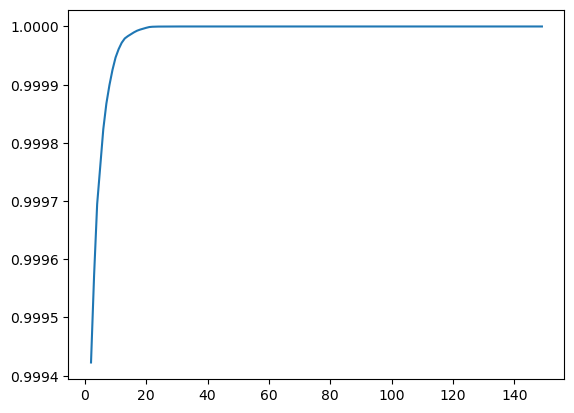

In [202]:
# plotting variance ratio
pd.Series(var_ratio).plot()

<Figure size 500x500 with 0 Axes>

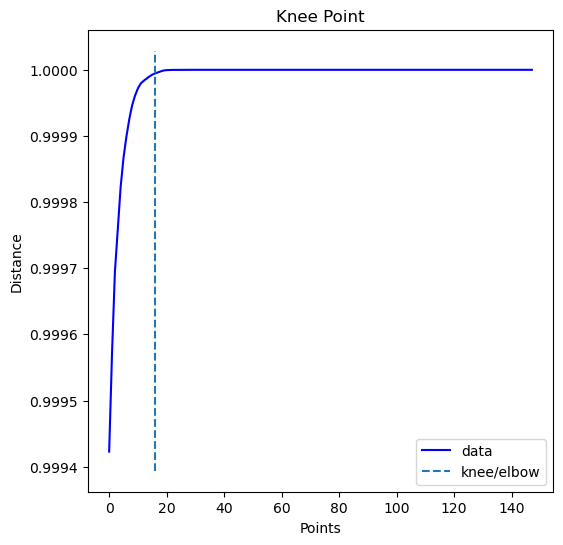

Knee Locator k = 18


In [203]:
# kneed algorithm to find elbow point:
from kneed import KneeLocator

i = np.arange(len(var_ratio))
variance_ratio= list(var_ratio.values())
components=  list(var_ratio.keys())
knee = KneeLocator(i, variance_ratio, S=1, curve='concave', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()
k= components[knee.knee]
print('Knee Locator k =', k)

In [205]:
# Reducing the dimensions of the data 
pca_final=PCA(n_components=18,random_state=42)

reduced=pca_final.fit_transform(X_scaled)

In [206]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(reduced, y)

In [207]:
report_pca = evaluate_models(X_res,y_res, models)

Random Forest
Model Performance for Training Dataset:
Accuracy Score : 0.9993
Precision Score : 1.0000
Recall Score : 0.9986
F1 Score : 0.9993
ROC Score : 0.9993
Total Cost : 500.0000
-----------------------------------
Random Forest
Model Performance for Test Dataset:
Accuracy Score : 0.9556
Precision Score : 0.9440
Recall Score : 0.9695
F1 Score : 0.9566
ROC Score : 0.9555
Total Cost : 3210.0000
-----------------------------------
Decision Tree
Model Performance for Training Dataset:
Accuracy Score : 0.9993
Precision Score : 1.0000
Recall Score : 0.9986
F1 Score : 0.9993
ROC Score : 0.9993
Total Cost : 500.0000
-----------------------------------
Decision Tree
Model Performance for Test Dataset:
Accuracy Score : 0.9408
Precision Score : 0.9364
Recall Score : 0.9470
F1 Score : 0.9416
ROC Score : 0.9408
Total Cost : 5270.0000
-----------------------------------
Gradient Boosting
Model Performance for Training Dataset:
Accuracy Score : 0.9448
Precision Score : 0.9424
Recall Score : 0.94

In [208]:
report_pca

Model Name   Cost
0           Random Forest   3210
6           XGBClassifier   3970
1           Decision Tree   5270
5  K-Neighbors Classifier   5740
2       Gradient Boosting   6390
7     AdaBoost Classifier   9970
3     Logistic Regression  24150
4                     SVC  63390

# Final Model

In [209]:
from prettytable import PrettyTable

pt=PrettyTable()
pt.field_names=["Model","Imputation_method","Total_cost"]
pt.add_row(["XGBClassifier","Simple Imputer-Constant","1150"])
pt.add_row(["XGBClassifier","Mice","680"])
pt.add_row(["XGBClassifier","Knn-Imputer","1330"])
pt.add_row(["Random Forest","Simple Imputer-Mean","710"])
pt.add_row(["XGBClassifier","Median","1320"])
pt.add_row(["Random Forest","PCA+MICE","3210"])
print(pt)

+---------------+-------------------------+------------+
|     Model     |    Imputation_method    | Total_cost |
+---------------+-------------------------+------------+
| XGBClassifier | Simple Imputer-Constant |    1150    |
| XGBClassifier |           Mice          |    680     |
| XGBClassifier |       Knn-Imputer       |    1330    |
| Random Forest |   Simple Imputer-Mean   |    710     |
| XGBClassifier |          Median         |    1320    |
| Random Forest |         PCA+MICE        |    3210    |
+---------------+-------------------------+------------+


**Report**
- From the final report we can see than XGBClassifier with MICE as imputation technique has performed the best with cost of 680

In [217]:
final_model=XGBClassifier()

In [219]:
X_mice=X.copy()

In [220]:
import miceforest as mf
kernel=mf.ImputationKernel(X_mice,save_all_iterations=True,random_state=90)
X_mice=kernel.complete_data()

In [221]:
scaled_pipeline=Pipeline(steps=[
    ('Scaler',RobustScaler())
])
X_mice_scaled=scaled_pipeline.fit_transform(X_mice)

In [222]:
smt=SMOTETomek(random_state=45,sampling_strategy='auto')
X_res,y_res=smt.fit_resample(X_mice_scaled,y)

In [226]:
X_train,X_test,y_train,y_test=train_test_split(X_res,y_res,test_size=0.2,random_state=78)
final_model=final_model.fit(X_train,y_train)
y_test_pred=final_model.predict(X_test)


In [229]:
print("Final XGBoost Classifier Accuracy Score (Train) :", final_model.score(X_train,y_train))
print("Final XGBoost Classifier Accuracy Score (Test) :", accuracy_score(y_test_pred,y_test))

Final XGBoost Classifier Accuracy Score (Train) : 1.0
Final XGBoost Classifier Accuracy Score (Test) : 0.9858196256381169


In [231]:
print("Final XGBoost Classifier Cost Metric(Test) :",total_cost(y_test, y_test_pred))

Final XGBoost Classifier Cost Metric(Test) : 1060


In [232]:
confusion_matrix(y_test, y_test_pred)

array([[847,  16],
       [  9, 891]], dtype=int64)

## The best Model is XGBoost Classifier with 98.58% accuracy and cost of 1060